## Setup

##### Mount Drive

In [ ]:
# Copyright (C) <2025>  <The Ohio State University>

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>;.

%reset -f
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### Setup cobrapy

In [ ]:
pip install cobra==0.29.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.8/141.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 15.7 MB/s eta 0:00:00


In [ ]:
pip install gurobipy==11.0.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 44.8 MB/s eta 0:00:00


In [ ]:
import os

os.environ['GRB_LICENSE_FILE'] = '/content/drive/MyDrive/work/data/virocells/modeling-env/gurobi.lic'

In [ ]:
# pip install cplex

In [ ]:
pip install Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 35.9 MB/s eta 0:00:00


In [ ]:
# pip install ipywidgets

In [ ]:
import cobra
from cobra.io import load_model
from cobra.io import read_sbml_model
import re
import pandas as pd
import Levenshtein
import re
import itertools
import numpy as np
import matplotlib.pyplot as plt
import copy
from copy import deepcopy
from collections import defaultdict
import json
from scipy.interpolate import make_interp_spline
from scipy.spatial.distance import euclidean
import itertools
from scipy.stats.mstats import gmean
import math
import os
import ipywidgets as widgets
from IPython.display import display
from collections import deque
import time
import Levenshtein
import seaborn as sns
from scipy.stats import linregress
import pickle
import itertools
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import TwoSlopeNorm
from cobra.io import save_json_model
from optlang import Constraint
import sympy as sp
import gurobipy
from cobra.flux_analysis import find_blocked_reactions
import csv

In [ ]:
epsilon = np.finfo(float).eps # to keep from dividing by 0

##### Functions

In [ ]:
# @title
#sets fluxes through exchange reactions to 0
def no_intake(my_model):
  my_model_1 = copy.deepcopy(my_model)

  for reaction in my_model_1.reactions:
      if 'EX_' in  reaction.id:
          reaction.lower_bound=0
  return my_model_1

def no_carbon_intake(my_model):
  my_model_1 = copy.deepcopy(my_model)

  for reaction in my_model_1.reactions:
      if 'EX_' in  reaction.id:
        exchange_metabolite = my_model_1.metabolites.get_by_id("_".join(reaction.id.split("_")[1:]))
        if 'C' in exchange_metabolite.elements:
          reaction.lower_bound=0
  return my_model_1


#difference between two numbers
def calculate_normalized_difference(x, y):
  if abs(x-y) < 10**(-6):
    return 0
  else:
    return (x-y)/(abs(x)+abs(y)) #epsilon is a really tiny number of the order ~ 10^-16

#calculate the ratio of two numbers
def calculate_ratio(x, y):
  return (x+epsilon)/(y+epsilon) # to keep from dividing by 0 if y is 0


# computes the maximum value of various biomass precursors
def maximize_met_production(wt_model, mu_model, met_list, met_max_dict):
    def run_pfba(model):
        return cobra.flux_analysis.pfba(model)

    def get_biomass_yield(solution):
        biomass_rxn = bof_dict[model_name]
        return solution.fluxes[biomass_rxn]

    def add_biomass_constraint(model, lb_factor=0.9, ub_factor=1, name_prefix=""):
      model_copy = copy.deepcopy(model)
      opt_val = model_copy.optimize().objective_value
      obj_expr = model_copy.solver.objective.expression
      constraint = Constraint(expression=obj_expr, lb=lb_factor * opt_val, ub=ub_factor * opt_val, name=f"{name_prefix}_LB")
      model_copy.solver.add(constraint)
      return model_copy

    def maximize_met_flux(model, met_id):
        with model as sim_model:
            met = sim_model.metabolites.get_by_id(met_id)
            sim_model.add_boundary(met, type="demand", reaction_id="met_demand")
            demand_reaction = sim_model.reactions.get_by_id("met_demand")
            sim_model.objective = sim_model.problem.Objective(demand_reaction.flux_expression, direction="max")
            try:
              sol = sim_model.optimize().fluxes["met_demand"]
            except gurobipy.GurobiError as e:
              print(f"Optimization failed for metabolite {met_id}: {e}")
              sol = 0
            return sol

    # --- Compute biomass yields with different methods ---
    pfba_wt_sol = run_pfba(wt_model)
    biomass_wt = get_biomass_yield(pfba_wt_sol)

    pfba_mu_sol = run_pfba(mu_model)
    biomass_mu = get_biomass_yield(pfba_mu_sol)

    moma_lin_sol = cobra.flux_analysis.moma(mu_model, solution=pfba_wt_sol, linear=True)
    biomass_moma_lin = get_biomass_yield(moma_lin_sol)

    moma_nonlin_sol = cobra.flux_analysis.moma(mu_model, solution=pfba_wt_sol, linear=False)
    biomass_moma_nonlin = get_biomass_yield(moma_nonlin_sol)

    # Store biomass yields relative to wild-type
    met_max_dict["biomass_reaction"].append([
        [biomass_wt, biomass_mu],
        [biomass_wt, biomass_moma_lin],
        [biomass_wt, biomass_moma_nonlin]
    ])

    # --- Prepare models for precursor maximization ---
    fba_wt_model = add_biomass_constraint(wt_model, name_prefix="FBA_WT")
    fba_mu_model = add_biomass_constraint(mu_model, name_prefix="FBA_MU")

    # --- Loop over each metabolite to compute maximum production yields ---
    for met_id in met_list:
        # Maximize the production of met_id for each model variant.
        met_yield_wt = maximize_met_flux(fba_wt_model, met_id)
        met_yield_mu = maximize_met_flux(fba_mu_model, met_id)
        met_yield_lin_moma = None
        met_yield_nonlin_moma = None

        # Store the yields as a set of relative comparisons to the wild-type simulation.
        met_max_dict[met_id].append([
            [met_yield_wt, met_yield_mu],
            [met_yield_wt, met_yield_lin_moma],
            [met_yield_wt, met_yield_nonlin_moma]
        ])

    return


# set nutritional environment by contraining intake fluxes
def set_nutritional_environment(my_model, my_medium, condition=""):
  model = copy.deepcopy(my_model)
  model_reactions = [item.id for item in model.reactions]

  if "ecoli" not in model_name: model =  no_intake(model)
  else:
    model =  no_carbon_intake(model)
    translation_model = read_sbml_model(working_directory + "/models/CBA18_RAST_defined.xml")
    translation_model.solver.configuration.verbosity = 0
    translation_mets = [item.id for item in translation_model.metabolites]

  with open(my_medium) as f:
    f.readline()
    for line in f:
      parts = line.split("\t")

      if "ecoli" not in model_name: exchange_reaction = ["EX_" + parts[0] + "_e0"]
      else:
        if parts[0] + "_c0" in translation_mets:
          bigg_id = translation_model.metabolites.get_by_id(parts[0] + "_c0").annotation.get("bigg.metabolite", None)
          if isinstance(bigg_id, list): exchange_reaction = ["EX_" + item + "_e" for item in bigg_id]
          elif isinstance(bigg_id, str): exchange_reaction = ["EX_" + bigg_id + "_e"]
          else:
            print (parts[1] + " does not map to a BiGG id in translation model")
            continue
        elif parts[0] + "_e0" in translation_mets:
          bigg_id = translation_model.metabolites.get_by_id(parts[0] + "_e0").annotation.get("bigg.metabolite", None)
          if isinstance(bigg_id, list): exchange_reaction = ["EX_" + item + "_e" for item in bigg_id]
          elif isinstance(bigg_id, str): exchange_reaction = ["EX_" + bigg_id + "_e"]
          else:
            print (parts[1] + " does not map to a BiGG id in translation model")
            continue
        else:
          print (parts[1] + " does not map to a BiGG id in translation model")
          continue

      min_flux = abs(float(parts[3]))
      max_flux = abs(float(parts[4]))

      for rxn in exchange_reaction:
        if rxn in model_reactions:
          model.reactions.get_by_id(rxn).bounds = (-max_flux, min_flux)
        else: print (parts[1] + " exchange reaction not found in model")

  if condition == "_oxygen_limited":
    fba_soln = cobra.flux_analysis.pfba(model)

    if "ecoli" not in model_name:
      oxygen_uptake = 0.8 * fba_soln.fluxes["EX_cpd00007_e0"] #setting to 80% of maximum respiratory capacity predicted by FBA
      model.reactions.get_by_id("EX_cpd00007_e0").bounds = (oxygen_uptake,100)
    else:
      oxygen_uptake = 0.8 * fba_soln.fluxes["EX_o2_e"] #setting to 80% of maximum respiratory capacity predicted by FBA
      model.reactions.get_by_id("EX_o2_e").bounds = (oxygen_uptake,100)

  return model

# process quantitative growth data file provided by Marion
def process_quantitative_growth_data(file_name="growth_and_mutant_data/raw/quantitative_growth.tsv"):
  df = pd.read_csv(file_name, sep="\t", dtype={'Strain_new_name': str})
  df['Strain_new_name'] = df['Strain_new_name'].replace(['1840', '1.84E+03'], '184e1')

  grouped_df = df.groupby(['Strain_new_name', 'C_source'])['r'].agg(['mean', 'std', 'count']).reset_index()
  grouped_df.columns = ['Strain_new_name', 'C_source', 'mean r', 'std r', 'count r']
  grouped_df['sem r'] = grouped_df['std r'] / np.sqrt(grouped_df['count r'])

  mean_df = grouped_df.pivot(index='Strain_new_name', columns='C_source', values='mean r')
  sem_df = grouped_df.pivot(index='Strain_new_name', columns='C_source', values='sem r')

  # Get the row corresponding to 'Cba18'
  cba18_mean = mean_df.loc['Cba18']
  cba18_sem = sem_df.loc['Cba18']

  # Create uncertainty_relative_mean_df by propagating the uncertainties
  relative_mean_df = mean_df.div(cba18_mean, axis=1)
  uncertainty_relative_mean_df = (sem_df / mean_df).add((cba18_sem / cba18_mean), axis=1) * relative_mean_df

  def save_tsv(df, filename):
    df.to_csv(filename, sep='\t', float_format='%.2f')

  # Save the DataFrames as TSV files
  save_tsv(mean_df, 'growth_and_mutant_data/processed/growth.tsv')
  save_tsv(sem_df, 'growth_and_mutant_data/processed/growth_uncertainty.tsv')
  save_tsv(relative_mean_df, 'growth_and_mutant_data/processed/relative_growth.tsv')
  save_tsv(uncertainty_relative_mean_df, 'growth_and_mutant_data/processed/relative_growth_uncertainty.tsv')

#save table
def save_array_as_tsv(data_array, col_names, row_names, file_path):

  # Create a DataFrame from the numpy array
  df = pd.DataFrame(data_array, index=row_names, columns=col_names)

  # Round the entries to 3 decimal places
  df = df.round(6)

  # Save the DataFrame as a TSV file
  df.to_csv(file_path, sep='\t', index=True, header=True)

  print(f"Array saved as {file_path}")


def abbreviate_pathways(pathway, length=30):
  if len(pathway) > length:
    return pathway[:length] + '...'
  else:
    return pathway


def convert_RAST_to_bigg(my_model, my_dict):
  bigg_dict = {}
  for rxn in my_model.reactions:
    bigg_reactions = rxn.annotation.get("bigg.reaction", rxn.id)

    if type(bigg_reactions) == list:
      for bigg_rxn in bigg_reactions:
        if bigg_rxn in bigg_dict: print("duplicate reaction. check manually for issues")
        bigg_dict[bigg_rxn] = my_dict[rxn.id]
    else:
      if bigg_reactions in bigg_dict: print("duplicate reaction. check manually for issues")
      bigg_dict[bigg_reactions] = my_dict[rxn.id]

  return bigg_dict

def remove_c0(my_dict):
  return {key.replace("_c0", ""): my_dict[key] for key in my_dict.keys()}

def add_c0(my_dict):
    new_dict = {}
    for key in my_dict.keys():
        # Check if this is a reaction ID (starts with 'rxn') and doesn't already have a compartment suffix
        if (key.startswith('rxn') or key.startswith("DM_cpd") ) and not ('_c0' in key or '_e0' in key or '_' in key[3:]):
            # Add the '_c0' suffix
            new_dict[key + '_c0'] = my_dict[key]
        else:
            # Keep the key as is
            new_dict[key] = my_dict[key]
    return new_dict


def calculate_production(metabolite, model, flux_distribution):

  total_production = 0.0
  total_consumption = 0.0

  for reaction in model.reactions:
      flux = flux_distribution[reaction.id]
      stoichiometry = reaction.metabolites.get(model.metabolites.get_by_id(metabolite), 0)

      # Only include reactions where the metabolite is produced
      if (stoichiometry > 0 and flux > 0) or (stoichiometry < 0 and flux < 0):
          total_production += stoichiometry * flux

      #reaction were metabolite is consumed
      if (stoichiometry > 0 and flux < 0) or (stoichiometry < 0 and flux > 0):
          total_consumption += stoichiometry * flux

  if round(total_production, 5) != -1 * round(total_consumption, 5):
      print(f"production is {total_production} but consumption is {total_consumption} for {metabolite}")

  return total_production


def calculate_perturbation(metabolite, model, flux_distribution_MU, flux_distribution_WT):

  perturbation = 0.0
  reactions_present = 0

  for reaction in model.reactions:
      flux_mu = flux_distribution_MU[reaction.id]
      flux_wt = flux_distribution_WT[reaction.id]
      stoichiometry = reaction.metabolites.get(model.metabolites.get_by_id(metabolite), 0)

      # Only include reactions where the metabolite is produced
      if stoichiometry != 0 and (flux_mu != 0 or flux_wt != 0):
        reactions_present +=1
        perturbation  += abs(stoichiometry) * abs(flux_mu - flux_wt)

  if reactions_present != 0:
    perturbation = perturbation/reactions_present

  return perturbation

def do_intervals_overlap(interval1, interval2):
    start1, end1 = interval1
    start2, end2 = interval2
    return start1 <= end2 and start2 <= end1

def calculate_fva_distance(range1, range2):
    # distance is 0 if ranges overlap
    if do_intervals_overlap(range1, range2):
        return 0

    # Sort the ranges so range1 is the lower one
    if range1[0] > range2[0]:
        range1, range2 = range2, range1

    # Calculate the absolute distance between ranges
    distance = range2[0] - range1[1]

    return distance

def convert_flux_to_fva_format(flux_file):
    # Load the flux file
    with open(flux_file, 'r') as f:
        flux_values = json.load(f)

    flux_values = add_c0(flux_values)

    # Create FVA format
    fva_format = {
        "minimum": {},
        "maximum": {}
    }

    # Set both minimum and maximum to the same flux value
    for rxn_id, flux_value in flux_values.items():
        fva_format["minimum"][rxn_id] = flux_value
        fva_format["maximum"][rxn_id] = flux_value

    return fva_format

## Collect Data

##### Load model

In [ ]:
#@title {display-mode: "form"}

#@markdown Threonine adolase is present in CBA18 but was not included in the KBase model. Adding it allows CBA18 to grow in glucose when the Phosphoglycerate dehydrogenase is knocked out which is consistent with experiments.

working_directory = "/content/drive/MyDrive/work/data/virocells/my_analysis/version_1/CBA_mutants"

os.chdir(working_directory)

# other models = ["CBA18_defined_wo_rxn05472", "CBA18_two_or_more_defined", "CBA18_RAST_glucose", "CBA18_RAST_auxomedia"]
model_name = "CBA18_RAST_defined" #@param ["CBA18_RAST_defined", "ecoli/iML1515", "ecoli/iJO1366"] {allow-input: false}

file_name = working_directory + "/models/" + model_name + ".xml"

model_0 = read_sbml_model(file_name)
# model_0.solver.problem.Params.OutputFlag = 0
model_0.solver.configuration.verbosity = 0

curation = "_add_threonine_adolase" #@param ["","_add_threonine_adolase", "_add_adolase_and_transporters"] {allow-input: false}

if curation == "_add_threonine_adolase":
  ecoli_RAST = read_sbml_model(working_directory + "/models/ecoli/ecoliRAST.xml")
  model_0.add_reactions([ecoli_RAST.reactions.get_by_id("rxn00541_c0")])
  model_0.reactions.get_by_id("rxn00541_c0").gene_reaction_rule = "M666_RS13845"

if curation == "_add_adolase_and_transporters":
  ecoli_RAST = read_sbml_model(working_directory + "/models/ecoli/ecoliRAST.xml")

  #adolase
  model_0.add_reactions([ecoli_RAST.reactions.get_by_id("rxn00541_c0")])
  model_0.reactions.get_by_id("rxn00541_c0").gene_reaction_rule = "M666_RS13845"

  #serine_transporter
  model_0.add_reactions([ecoli_RAST.reactions.get_by_id("EX_cpd00054_e0")])
  model_0.add_reactions([ecoli_RAST.reactions.get_by_id("rxn05307_c0")])

  #threonine transporter
  model_0.add_reactions([ecoli_RAST.reactions.get_by_id("EX_cpd00161_e0")])
  model_0.add_reactions([ecoli_RAST.reactions.get_by_id("rxn05300_c0")])

# make model similar to ecoli by adding constraint on ATP maintainance
if model_name == "ecoli/iML1515" or model_name == "ecoli/iJO1366":
  model_0.reactions.get_by_id("ATPM").bounds = (0, 1000.0)
  #model_0.reactions.get_by_id("rxn00062_c0").bounds = (6.86, 1000.0) #this reaction is ATPM in ecoli model

model_0.optimize();

print("Model Name: " + model_name)

model_0


ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.


Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2604132
Academic license 2604132 - for non-commercial use only - registered to ow___@buckeyemail.osu.edu


ERROR:cobra.io.sbml:'' is not a valid SBML 'SId'.


Model Name: CBA18_RAST_defined


Name,
Memory address,7ee8876ed710
Number of metabolites,1200
Number of reactions,1295
Number of genes,848
Number of groups,0
Objective expression,1.0*bio1_biomass - 1.0*bio1_biomass_reverse_6e711
Compartments,"c0, e0"


##### Display information about mutants

In [ ]:
#@title {display-mode: "form"}

#@markdown This cell displays only when the the CBA18 model is loaded. Mutant genes include M666_RS15505, M666_RS13880 and M666_RS17370. They affect the following metabolic reactions:

#this is not ideal. you should automate the creation of this list
#mutant_reaction_eq = ["D-Glucosamine1-phosphate [c0] <=> D-Glucosamine phosphate [c0]", "D-mannose-6-phosphate [c0] <=> D-Mannose1-phosphate [c0]", "Acetyl-CoA [c0] + Glycine [c0] --> CoA [c0] + L-2-Amino-acetoacetate [c0]", "NAD [c0] + 3-Phosphoglycerate [c0] <=> NADH [c0] + H+ [c0] + 3-Phosphonooxypyruvate [c0]"]

reaction_gene_mapping = {"rxn01485_c0": "M666_RS15505", "rxn01329_c0": "M666_RS15505", "rxn00274_c0": "M666_RS13880", "rxn01101_c0":"M666_RS17370"}
if model_name != "ecoli/iML1515" and model_name != "ecoli/iJO1366":
  full_set_of_mutations = set(["M666_RS07700", "M666_RS16755", "M666_RS20120", "M666_RS18590", "M666_RS01685", "M666_RS02270", "M666_RS02280",
                          "M666_RS02275", "M666_RS15505", "M666_RS01050", "M666_RS01055", "M666_RS02285", "M666_RS15505", "M666_RS15505",
                          "M666_RS01425", "M666_RS01720", "M666_RS15505", "M666_RS08865", "M666_RS15505", "M666_RS13880", "M666_RS13880",
                          "M666_RS17370"])
  mutant_genes_in_model = full_set_of_mutations.intersection(set([i.id for i in model_0.genes]))

  mutant_reactions = ["rxn01485_c0", "rxn01329_c0", "rxn00274_c0", "rxn01101_c0"]


  mutant_info_dict = {"name": [model_0.reactions.get_by_id(i).name for i in mutant_reactions],
                      "has_flux": [abs(model_0.reactions.get_by_id(i).flux)>0 for i in mutant_reactions],
                      "gene": [model_0.reactions.get_by_id(i).gene_reaction_rule for i in mutant_reactions],
                      "BioCyc": [model_0.reactions.get_by_id(i).annotation["biocyc"] for i in mutant_reactions],
                      "KEGG": [model_0.reactions.get_by_id(i).annotation["kegg.reaction"] for i in mutant_reactions]}

  print("Metabolic Genes Impacted: " + ", ".join(list(mutant_genes_in_model)))
  display(pd.DataFrame(mutant_info_dict, index=mutant_reactions))

Metabolic Genes Impacted: M666_RS15505, M666_RS17370, M666_RS13880


,name,has_flux,gene,BioCyc,KEGG
rxn01485_c0,"D-Glucosamine 1-phosphate 1,6-phosphomutase [c0]",True,M666_RS15505,META:5.4.2.10-RXN,R02060
rxn01329_c0,"D-mannose 6-phosphate 1,6-phosphomutase [c0]",False,M666_RS15505,META:PHOSMANMUT-RXN,R01818
rxn00274_c0,Acetyl-CoA:glycine C-acetyltransferase [c0],False,M666_RS04130 and M666_RS13880,META:AKBLIG-RXN,R00371
rxn01101_c0,3-Phospho-D-glycerate:NAD+ 2-oxidoreductase [c0],True,M666_RS06810 and M666_RS17370 and M666_RS17960,META:PGLYCDEHYDROG-RXN,R01513


##### Read in quantitative growth data and other input data

In [ ]:
# @title
# relative growth rates
if model_name != "ecoli/iML1515":
  defined_mets = ["D-Glucose", "D-Lactose", "Maltose", "Sucrose", "D-Fructose", "L-Glutamic-acid", "Salicin"]
  defined_mets_wo_Salicin = ["D-Glucose", "D-Lactose", "Maltose", "Sucrose", "D-Fructose", "L-Glutamic-acid"]

else:
  defined_mets = ["D-Glucose", "D-Lactose", "Maltose", "D-Fructose", "L-Glutamic-acid"]
  defined_mets_wo_Salicin = defined_mets

# mapping mutant ids to reactions within the model that they affect
id_mapping = {"184a5": "rxn01485_c0", "181a6": "rxn01485_c0", "181a7": "rxn01485_c0",
              "184b1": "rxn01485_c0", "184c1": "rxn01485_c0", "184f1": "rxn01101_c0"}

process_quantitative_growth_data()

rel_growth = pd.read_csv("growth_and_mutant_data/processed/relative_growth.tsv", sep="\t", index_col=0)
rel_growth_unc = pd.read_csv("growth_and_mutant_data/processed/relative_growth_uncertainty.tsv", sep="\t", index_col=0)
abs_growth = pd.read_csv("growth_and_mutant_data/processed/growth.tsv", sep="\t", index_col=0)
abs_growth_unc = pd.read_csv("growth_and_mutant_data/processed/growth_uncertainty.tsv", sep="\t", index_col=0)

new_columns = {"D-glucose": "D-Glucose", "alpha-Lactose": "D-Lactose", "maltose": "Maltose", "sucrose": "Sucrose",
               "D-fructose": "D-Fructose", "L-glutamic acid": "L-Glutamic-acid", "salicin": "Salicin", "MLB":"LB_wo_glycine"}

rel_growth.rename(columns=new_columns, inplace=True)
rel_growth_unc.rename(columns=new_columns, inplace=True)
abs_growth.rename(columns=new_columns, inplace=True)
abs_growth_unc.rename(columns=new_columns, inplace=True)

rel_growth = rel_growth[defined_mets + ["LB_wo_glycine"]].loc[list(id_mapping.keys())]
rel_growth_unc = rel_growth_unc[defined_mets + ["LB_wo_glycine"]].loc[list(id_mapping.keys())]
abs_growth_wt = abs_growth[defined_mets + ["LB_wo_glycine"]].loc[["Cba18"]]
abs_growt_wt_unc = abs_growth_unc[defined_mets + ["LB_wo_glycine"]].loc[["Cba18"]]

#####################################################
#kegg annotations
kegg_reaction_module_dict = defaultdict(list)
kegg_module_reaction_dict = defaultdict(set)
kegg_module_description = {}
with open("../../tables/kegg/kegg_reaction_module.tsv", "r") as f:
  for line in f:
    reaction, module = line.strip("\n").split("\t")
    kegg_reaction_module_dict[reaction.strip("rn:")].append(module.strip("md:"))
    kegg_module_reaction_dict[module.strip("md:")].add(reaction.strip("rn:"))

with open("../../tables/kegg/kegg_modules.tsv", "r") as f:
  for line in f:
    module, description = line.strip("\n").split("\t")
    kegg_module_description[module] = description

kegg_annotations = {
    i.id: i.annotation["kegg.reaction"] if isinstance(i.annotation["kegg.reaction"], list)
          else [i.annotation["kegg.reaction"]]
    for i in model_0.reactions if "kegg.reaction" in i.annotation
}
kegg_reactions_in_model = set().union(*list(kegg_annotations.values()))

#####################################################
#biocyc annotations

metacyc_reaction_module_dict = defaultdict(list)
metacyc_module_reaction_dict = defaultdict(set)
metacyc_module_description = {}
with open("../../tables/metacyc/pathway_reactions.tsv", "r") as f:
  for line in f:
    module, reaction_string = line.strip("\n").split("\t")
    reactions = reaction_string.split(" // ")

    for rxn in reactions: metacyc_reaction_module_dict[rxn].append(module)
    metacyc_module_reaction_dict[module] = set(reactions)

with open("../../tables/metacyc/pathway_names.tsv", "r") as f:
  for line in f:
    module, description = line.strip("\n").split("\t")
    metacyc_module_description[module] = description

metacyc_annotations = {
    i.id: [j.strip("META:") for j in i.annotation['biocyc']] if isinstance(i.annotation['biocyc'], list)
          else [i.annotation['biocyc'].strip("META:")]
    for i in model_0.reactions if 'biocyc' in i.annotation
}
metacyc_reactions_in_model = set().union(*list(metacyc_annotations.values()))

##### Create mutant model

In [ ]:
#@title {display-mode: "form"}

#@markdown mutant with a hyphen use thresholds obtained from CBA18 experiment

#["LB-Marine", "LB-Marine_Glycine_Limited", "D-Glucose", "D-Lactose", "Maltose", "Sucrose", "D-Fructose", "L-Glutamic-acid", "Salicin", "combined_defined", "all_relevant", "LB", "LB-Argonne", "Glycine", "auxo_media", "Gelatin", "Iota-Carrageenan", "Casamino-acids"]
#carbon_source = "D-Glucose" #@param ["D-Glucose", "D-Lactose", "Maltose", "Sucrose", "D-Fructose", "L-Glutamic-acid", "Salicin", "LB/LB", "LB/LB_wo_serine", "LB/LB_wo_glycine", "LB/LB_wo_threonine", "LB/LB_plus_serine", "LB/LB_plus_glycine", "LB/LB_plus_threonine"]  {allow-input: false}

#["rxn01485_c0", "rxn01485_c0-181a7", "rxn01329_c0", "rxn00274_c0", "rxn01101_c0"]
CBA_mutant = "rxn01101_c0" #@param #["rxn01485_c0-181a7", "rxn01101_c0"] {allow-input: false}
media_condition = "_oxygen_limited" #@param ["", "_oxygen_limited"]
media_supplement = "" #@param ["", "_plus_formate"]


rast_to_bigg = {"rxn01485_c0":"PGAMT", "rxn01329_c0":"PMANM", "rxn00274_c0": "GLYAT", "rxn01101_c0": "PGCD"}

model_1 =  copy.deepcopy(model_0)
mutant_model = deepcopy(model_1)
wild_type_model = deepcopy(model_1)

if "ecoli" not in model_name: mutant_model.reactions.get_by_id(CBA_mutant).bounds = (0,0) #for CBA
else: mutant_model.reactions.get_by_id(rast_to_bigg[CBA_mutant]).bounds = (0,0) # for ecoli

Read LP format model from file /tmp/tmpgnh1k10q.lp
Reading time = 0.03 seconds
: 1200 rows, 2590 columns, 11374 nonzeros
Read LP format model from file /tmp/tmpc47hrzis.lp
Reading time = 0.05 seconds
: 1200 rows, 2590 columns, 11374 nonzeros
Read LP format model from file /tmp/tmpd8wxzucq.lp
Reading time = 0.05 seconds
: 1200 rows, 2590 columns, 11374 nonzeros


##### Extract metabolites in biomass objective

In [ ]:
# @title

bof_dict = {"CBA18_RAST_defined":"bio1_biomass", "ecoli/iML1515":"BIOMASS_Ec_iML1515_core_75p37M", "ecoli/iJO1366":"BIOMASS_Ec_iJO1366_core_53p95M"}
bof_to_mutant_rxns = {"bio1_biomass": list(rast_to_bigg.keys()), "BIOMASS_Ec_iML1515_core_75p37M": list(rast_to_bigg.values()), "BIOMASS_Ec_iJO1366_core_53p95M":list(rast_to_bigg.values())}

if model_name == "ecoli/iML1515":
  all_precursors = [met.id for met in model_1.reactions.get_by_id("BIOMASS_Ec_iML1515_core_75p37M").metabolites]

elif model_name == "ecoli/iJO1366":
  all_precursors = [met.id for met in model_1.reactions.get_by_id("BIOMASS_Ec_iJO1366_core_53p95M").metabolites]

else:
  macro_mols = {'DNA': 'cpd11461_c0', 'Protein': 'cpd11463_c0', 'mRNA': 'cpd11462_c0', 'Biomass':'cpd11416_c0'}
  make_macro = {'DNA': 'rxn05294_c0', 'Protein': 'rxn05296_c0', 'mRNA': 'rxn05295_c0', 'Biomass':'bio1_biomass'}

  biomass_mets_all = model_1.reactions.get_by_id("bio1_biomass").metabolites
  biomass_mets = {item:biomass_mets_all[item] for item in biomass_mets_all.keys() if 'C' in item.elements or item.id in list(macro_mols.values())}
  biomass_mets_ids = {item.id:(item.name, biomass_mets[item]) for item in biomass_mets.keys()}
  biomass_precursors = set(biomass_mets_ids.keys())

  # metabolites in mRNA synthesis reaction
  mRNA_mets_all = model_1.reactions.get_by_id("rxn05295_c0").metabolites
  mRNA_mets = {item:mRNA_mets_all[item] for item in mRNA_mets_all.keys() if 'C' in item.elements or item.id in list(macro_mols.values())}
  mRNA_mets_ids = {item.id:(item.name, mRNA_mets[item]) for item in mRNA_mets.keys()}
  mRNA_precursors = set(mRNA_mets_ids.keys())

  # metabolites in protein synthesis reaction
  prot_mets_all = model_1.reactions.get_by_id("rxn05296_c0").metabolites
  prot_mets = {item:prot_mets_all[item] for item in prot_mets_all.keys() if 'C' in item.elements or item.id in list(macro_mols.values())}
  prot_mets_ids = {item.id:(item.name, prot_mets[item]) for item in prot_mets.keys()}
  prot_precursors = set(prot_mets_ids.keys())

  # metabolites in DNA synthesis reaction
  DNA_mets_all = model_1.reactions.get_by_id("rxn05294_c0").metabolites
  DNA_mets = {item:DNA_mets_all[item] for item in DNA_mets_all.keys() if 'C' in item.elements or item.id in list(macro_mols.values())}
  DNA_mets_ids = {item.id:(item.name, DNA_mets[item]) for item in DNA_mets.keys()}
  DNA_precursors = set(DNA_mets_ids.keys())

  # small molecules that act as precursors for the production of macromolecules
  all_precursors = list(biomass_precursors | mRNA_precursors | prot_precursors | DNA_precursors)


##### Maximize the production of biomass metabolites in wild-type and mutant dataset

In [ ]:

save_new_tables = "if_necessary" #@param ["if_necessary", "yes", "no"] {allow-input: false}

for met in defined_mets + ["LB/LB", "LB/LB_wo_serine", "LB/LB_wo_glycine", "LB/LB_wo_threonine", "LB/LB_plus_serine", "LB/LB_plus_glycine", "LB/LB_plus_threonine"]:

    media_file =  f"growth_media/defined{media_supplement}/" + met + ".tsv"
    max_precursor_dict = defaultdict(list)
    max_precursor_yield_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/max_precursors/" + met.split("/")[-1] + "_" + CBA_mutant + media_condition + ".json"

    if save_new_tables == "yes" or (not os.path.exists(max_precursor_yield_file) and save_new_tables != "no"):
      wild_type_model_x = set_nutritional_environment(wild_type_model, media_file, condition=media_condition)
      mutant_model_x = set_nutritional_environment(mutant_model, media_file, condition=media_condition)

      maximize_met_production(wild_type_model_x, mutant_model_x, all_precursors, max_precursor_dict)

      with open(max_precursor_yield_file, 'w') as file:
        json.dump(max_precursor_dict, file)


##### Store flux data for escher visualization (the web version of escher only has maps for ecoli/iJO1366)

In [ ]:
save_new_tables = "if_necessary" #@param ["if_necessary", "yes", "no"] {allow-input: false}

save_json_model(wild_type_model, working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/escher_fluxes/model.json")

for met in defined_mets + ["LB/LB", "LB/LB_wo_serine", "LB/LB_wo_glycine", "LB/LB_wo_threonine", "LB/LB_plus_serine", "LB/LB_plus_glycine", "LB/LB_plus_threonine"]:

  media_file =  f"growth_media/defined{media_supplement}/" + met + ".tsv"
  escher_flux_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/escher_fluxes/" + met + "/" + CBA_mutant + media_condition

  if save_new_tables == "yes" or (not os.path.exists(escher_flux_file+ "_norm_diff.json") and save_new_tables != "no"):

    wild_type_model_x = set_nutritional_environment(wild_type_model, media_file, condition=media_condition)
    mutant_model_x = set_nutritional_environment(mutant_model, media_file, condition=media_condition)

    # flux data for wild type
    wt_flux_data = dict(cobra.flux_analysis.pfba(wild_type_model_x).fluxes)
    if "ecoli" not in model_name:
      with open(escher_flux_file + "_WT.json", 'w') as f:
        json.dump(remove_c0(wt_flux_data), f)
      with open(escher_flux_file + "_WT_Bigg.json", 'w') as f:
        json.dump(convert_RAST_to_bigg(wild_type_model_x, wt_flux_data), f)
    else:
      with open(escher_flux_file + "_WT.json", 'w') as f:
        json.dump(wt_flux_data, f)


    # flux data for mutant
    mu_flux_data_from_MOMA = dict(cobra.flux_analysis.moma(model=mutant_model_x, solution=cobra.flux_analysis.pfba(wild_type_model_x), linear=False).fluxes)
    if "ecoli" not in model_name:
      with open(escher_flux_file + "_MU.json", 'w') as f:
        json.dump(remove_c0(mu_flux_data_from_MOMA), f)
      with open(escher_flux_file + "_MU_Bigg.json", 'w') as f:
        json.dump(convert_RAST_to_bigg(mutant_model_x, mu_flux_data_from_MOMA), f)
    else:
      with open(escher_flux_file + "_MU.json", 'w') as f:
        json.dump(mu_flux_data_from_MOMA, f)

    # difference in fluxes between the wild type and the mutant
    diff_flux_data = {key: mu_flux_data_from_MOMA[key] - wt_flux_data[key] for key in wt_flux_data.keys()}
    if "ecoli" not in model_name:
      with open(escher_flux_file + "_diff.json", 'w') as f:
        json.dump(remove_c0(diff_flux_data), f)
      with open(escher_flux_file + "_diff_Bigg.json", 'w') as f:
        json.dump(convert_RAST_to_bigg(wild_type_model_x, diff_flux_data), f)
    else:
      with open(escher_flux_file + "_diff.json", 'w') as f:
        json.dump(diff_flux_data, f)


    # normalized difference in fluxes between wild_type and the mutant
    norm_diff_flux_data = {key:  calculate_normalized_difference(mu_flux_data_from_MOMA[key], wt_flux_data[key])  for key in wt_flux_data.keys()}
    if "ecoli" not in model_name:
      with open(escher_flux_file + "_norm_diff.json", 'w') as f:
        json.dump(remove_c0(norm_diff_flux_data), f)
      with open(escher_flux_file + "_norm_diff_Bigg.json", 'w') as f:
        json.dump(convert_RAST_to_bigg(wild_type_model_x, norm_diff_flux_data), f)
    else:
      with open(escher_flux_file + "_norm_diff.json", 'w') as f:
        json.dump(norm_diff_flux_data, f)


##### Fluxes in WT vs Mutant

In [ ]:
save_new_tables = "if_necessary" #@param ["if_necessary", "yes", "no"] {allow-input: false}

flux_file_diff = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/fluxes/" + CBA_mutant + "_difference" + media_condition + ".json"
flux_file_norm_diff = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/fluxes/" + CBA_mutant + "_normalized_difference" + media_condition + ".json"
flux_file_ratio = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/fluxes/" + CBA_mutant + "_ratio" + media_condition + ".json"

flux_file_path_exists = os.path.exists(flux_file_diff) and os.path.exists(flux_file_norm_diff) and os.path.exists(flux_file_ratio)

rxn_fluxes_diff = defaultdict(list)
rxn_fluxes_norm_diff = defaultdict(list)
rxn_fluxes_ratio = defaultdict(list)

exchange_w_C = [i.id for i in wild_type_model.boundary if "C" in wild_type_model.metabolites.get_by_id("_".join(i.id.split("_")[1:])).elements]
exchange_all = [i.id for i in wild_type_model.boundary]
all_rxns = [i.id for i in wild_type_model.reactions]


if save_new_tables == "yes" or (not flux_file_path_exists and save_new_tables != "no"):
  rxn_fluxes_diff["all_rxns"] = rxn_fluxes_norm_diff["all_rxns"] = rxn_fluxes_ratio["all_rxns"] = all_rxns
  rxn_fluxes_diff["boundary"] = rxn_fluxes_norm_diff["boundary"] = rxn_fluxes_ratio["boundary"] = exchange_w_C
  rxn_fluxes_diff["internal"] = rxn_fluxes_norm_diff["internal"] = rxn_fluxes_ratio["internal"] = list(set(all_rxns) - set(exchange_all))

  for met in defined_mets + ["LB/LB", "LB/LB_wo_serine", "LB/LB_wo_glycine", "LB/LB_wo_threonine", "LB/LB_plus_serine", "LB/LB_plus_glycine", "LB/LB_plus_threonine"]:
    media_file =  f"growth_media/defined{media_supplement}/" + met + ".tsv"

    mutant_model_x = set_nutritional_environment(mutant_model, media_file, condition=media_condition)
    wild_type_model_x = set_nutritional_environment(wild_type_model, media_file, condition=media_condition)

    fba_solution_wt = cobra.flux_analysis.pfba(wild_type_model_x).fluxes

    fba_solution_mut = cobra.flux_analysis.pfba(mutant_model_x).fluxes
    moma_linear_soln = cobra.flux_analysis.moma(model=mutant_model_x, solution=cobra.flux_analysis.pfba(wild_type_model_x), linear=True).fluxes
    moma_soln = cobra.flux_analysis.moma(model=mutant_model_x, solution=cobra.flux_analysis.pfba(wild_type_model_x), linear=False).fluxes

    for rxn in all_rxns:
      fba_diff = (fba_solution_mut[rxn]-fba_solution_wt[rxn])
      moma_linear_diff= (moma_linear_soln[rxn]-fba_solution_wt[rxn])
      moma_diff = (moma_soln[rxn]-fba_solution_wt[rxn])

      fba_norm_diff = calculate_normalized_difference(fba_solution_mut[rxn],fba_solution_wt[rxn])
      moma_linear_norm_diff= calculate_normalized_difference(moma_linear_soln[rxn],fba_solution_wt[rxn])
      moma_norm_diff = calculate_normalized_difference(moma_soln[rxn],fba_solution_wt[rxn])

      fba_ratio = calculate_ratio(fba_solution_mut[rxn],fba_solution_wt[rxn])
      moma_linear_ratio= calculate_ratio(moma_linear_soln[rxn],fba_solution_wt[rxn])
      moma_ratio = calculate_ratio(moma_soln[rxn],fba_solution_wt[rxn])

      rxn_fluxes_diff[met].append([fba_diff, moma_linear_diff, moma_diff])
      rxn_fluxes_norm_diff[met].append([fba_norm_diff, moma_linear_norm_diff, moma_norm_diff])
      rxn_fluxes_ratio[met].append([fba_ratio, moma_linear_ratio, moma_ratio])


  with open(flux_file_diff, 'w') as f:
    json.dump(rxn_fluxes_diff, f)

  with open(flux_file_norm_diff, 'w') as f:
    json.dump(rxn_fluxes_norm_diff, f)

  with open(flux_file_ratio, 'w') as f:
    json.dump(rxn_fluxes_ratio, f)


##### FVA in WT vs Mutant

In [ ]:
save_new_tables = "if_necessary" #@param ["if_necessary", "yes", "no"] {allow-input: false}

fva_lin_moma_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/FVA/" + CBA_mutant + "_lin_MOMA" + media_condition + ".json"
fva_fba_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/FVA/" + CBA_mutant + "_FBA" + media_condition + ".json"

fva_lin_moma_dict = dict()
fva_fba_dict = dict()

fva_file_path_exists = os.path.exists(fva_lin_moma_file) and os.path.exists(fva_fba_file)

if save_new_tables == "yes" or (not fva_file_path_exists and save_new_tables != "no"):

  for met in defined_mets + ["LB/LB", "LB/LB_wo_serine", "LB/LB_wo_glycine", "LB/LB_wo_threonine", "LB/LB_plus_serine", "LB/LB_plus_glycine", "LB/LB_plus_threonine"]:
    media_file =  f"growth_media/defined{media_supplement}/" + met + ".tsv"

    #metabolic models
    wild_type_model_fba = set_nutritional_environment(wild_type_model, media_file, condition=media_condition)

    mutant_model_fba = set_nutritional_environment(mutant_model, media_file, condition=media_condition)

    mutant_model_lin_moma = set_nutritional_environment(mutant_model, media_file, condition=media_condition)
    cobra.flux_analysis.add_moma(model=mutant_model_lin_moma, solution=cobra.flux_analysis.pfba(wild_type_model_fba), linear=True)

    #Flux variability analysis (FVA) using default parameter values
    # default values are pfba_factor = None and fraction_of_optimum = 0.7, but changing these for a test
    fva_wt = cobra.flux_analysis.variability.flux_variability_analysis(wild_type_model_fba, reaction_list = None, loopless = False,
                                                                       fraction_of_optimum = 1.0, pfba_factor = 1, processes = None).to_dict()
    fva_mu_fba = cobra.flux_analysis.variability.flux_variability_analysis(mutant_model_fba, reaction_list = None, loopless = False,
                                                                           fraction_of_optimum = 1.0, pfba_factor = 1, processes = None).to_dict()
    fva_mu_lin_moma = cobra.flux_analysis.variability.flux_variability_analysis(mutant_model_lin_moma, reaction_list = None, loopless = False,
                                                                                fraction_of_optimum = 1.0, pfba_factor = None, processes = None).to_dict()

    fva_fba_dict[met]= {"wild_type":fva_wt,  "mutant": fva_mu_fba}
    fva_lin_moma_dict[met]= {"wild_type":fva_wt,  "mutant": fva_mu_lin_moma}

  with open(fva_lin_moma_file, 'w') as f:
      json.dump(fva_lin_moma_dict, f)

  with open(fva_fba_file, 'w') as f:
      json.dump(fva_fba_dict, f)


##### Compute Shadow prices

In [ ]:
save_new_tables = "if_necessary" #@param ["if_necessary", "yes", "no"] {allow-input: false}

shadow_prices_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/shadow_prices/" + CBA_mutant + media_condition + ".json"
shadow_price_dict = defaultdict(list)

all_metabolites = [i.id for i in wild_type_model.metabolites]
shadow_price_dict["all_metabolites"] = all_metabolites
shadow_price_dict["frameworks"] = ["wild_type", "mutant", "moma_linear", "moma"]

if save_new_tables == "yes" or (not os.path.exists(shadow_prices_file) and save_new_tables != "no"):

  for c_source in defined_mets + ["LB/LB", "LB/LB_wo_serine", "LB/LB_wo_glycine", "LB/LB_wo_threonine", "LB/LB_plus_serine", "LB/LB_plus_glycine", "LB/LB_plus_threonine"]:

    media_file =  f"growth_media/defined{media_supplement}/" + c_source + ".tsv"

    wild_type_model_x = set_nutritional_environment(wild_type_model, media_file, condition=media_condition)

    #mutant models
    mutant_model_x = set_nutritional_environment(mutant_model, media_file, condition=media_condition)

    moma_linear_model = set_nutritional_environment(mutant_model, media_file, condition=media_condition)
    cobra.flux_analysis.add_moma(model=moma_linear_model, solution=cobra.flux_analysis.pfba(wild_type_model_x), linear=True)

    moma_model = set_nutritional_environment(mutant_model, media_file, condition=media_condition)
    cobra.flux_analysis.add_moma(model=moma_model, solution=cobra.flux_analysis.pfba(wild_type_model_x), linear=False)


    wild_type_model_x.optimize()
    mutant_model_x.optimize()
    moma_linear_model.optimize()
    moma_model.optimize()

    for met_id in all_metabolites:
      shadow_price_dict[c_source].append([wild_type_model_x.metabolites.get_by_id(met_id).shadow_price,
                                          mutant_model_x.metabolites.get_by_id(met_id).shadow_price,
                                          moma_linear_model.metabolites.get_by_id(met_id).shadow_price,
                                          moma_model.metabolites.get_by_id(met_id).shadow_price])

  with open(shadow_prices_file, 'w') as f:
    json.dump(shadow_price_dict, f)


##### Cofactor and other metabolite production analysis

In [ ]:
save_new_tables = "if_necessary" #@param ["if_necessary", "yes", "no"] {allow-input: false}

met_production_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/metabolite_production/" + CBA_mutant + media_condition + ".json"
met_production_dict = defaultdict(list)

all_metabolites = [i.id for i in model_0.metabolites]
met_production_dict["all_metabolites"] = all_metabolites
met_production_dict["frameworks"] = ["Wild Type FBA", "Mutant FBA", "Linear MOMA", "MOMA"]

if save_new_tables == "yes" or (not os.path.exists(met_production_file) and save_new_tables != "no"):

  for c_source in defined_mets + ["LB/LB", "LB/LB_wo_serine", "LB/LB_wo_glycine", "LB/LB_wo_threonine", "LB/LB_plus_serine", "LB/LB_plus_glycine", "LB/LB_plus_threonine"]:

    media_file =  f"growth_media/defined{media_supplement}/" + c_source + ".tsv"

    wild_type_model_x = set_nutritional_environment(wild_type_model, media_file, condition=media_condition)
    mutant_model_x = set_nutritional_environment(mutant_model, media_file, condition=media_condition)

    #mutant models
    fba_solution_wt = dict(cobra.flux_analysis.pfba(wild_type_model_x).fluxes)

    fba_solution_mut = dict(cobra.flux_analysis.pfba(mutant_model_x).fluxes)
    moma_linear_soln = dict(cobra.flux_analysis.moma(model=mutant_model_x, solution=cobra.flux_analysis.pfba(wild_type_model_x), linear=True).fluxes)
    moma_soln = dict(cobra.flux_analysis.moma(model=mutant_model_x, solution=cobra.flux_analysis.pfba(wild_type_model_x), linear=False).fluxes)

    for met_id in all_metabolites:
      fba_wt_production = calculate_production(met_id, wild_type_model_x, fba_solution_wt)
      fba_mutant_production = calculate_production(met_id, mutant_model_x, fba_solution_mut)
      moma_linear_production = calculate_production(met_id, mutant_model_x, moma_linear_soln)
      moma_production = calculate_production(met_id, mutant_model_x, moma_soln)

      met_production_dict[c_source].append([fba_wt_production, fba_mutant_production, moma_linear_production, moma_production])

  with open(met_production_file, 'w') as f:
    json.dump(met_production_dict, f)

##### metabolite perturbation analysis

In [ ]:
save_new_tables = "if_necessary" #@param ["if_necessary", "yes", "no"] {allow-input: false}

met_perturbation_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/metabolite_perturbation/" + CBA_mutant + media_condition + ".json"
met_perturbation_dict = defaultdict(list)

all_metabolites = [i.id for i in model_0.metabolites]
met_perturbation_dict["all_metabolites"] = all_metabolites
met_perturbation_dict["frameworks"] = ["Mutant FBA", "Linear MOMA", "MOMA"]

if save_new_tables == "yes" or (not os.path.exists(met_perturbation_file) and save_new_tables != "no"):

  for c_source in defined_mets + ["LB/LB", "LB/LB_wo_serine", "LB/LB_wo_glycine", "LB/LB_wo_threonine", "LB/LB_plus_serine", "LB/LB_plus_glycine", "LB/LB_plus_threonine"]:

    media_file =  f"growth_media/defined{media_supplement}/" + c_source + ".tsv"

    wild_type_model_x = set_nutritional_environment(wild_type_model, media_file, condition=media_condition)
    mutant_model_x = set_nutritional_environment(mutant_model, media_file, condition=media_condition)

    #mutant models
    fba_solution_wt = dict(cobra.flux_analysis.pfba(wild_type_model_x).fluxes)

    fba_solution_mut = dict(cobra.flux_analysis.pfba(mutant_model_x).fluxes)
    moma_linear_soln = dict(cobra.flux_analysis.moma(model=mutant_model_x, solution=cobra.flux_analysis.pfba(wild_type_model_x), linear=True).fluxes)
    moma_soln = dict(cobra.flux_analysis.moma(model=mutant_model_x, solution=cobra.flux_analysis.pfba(wild_type_model_x), linear=False).fluxes)

    for met_id in all_metabolites:
      fba_mutant_perturbation = calculate_perturbation(met_id, mutant_model_x, fba_solution_mut, fba_solution_wt)
      moma_linear_perturbation = calculate_perturbation(met_id, mutant_model_x, moma_linear_soln, fba_solution_wt)
      moma_perturbation = calculate_perturbation(met_id, mutant_model_x, moma_soln, fba_solution_wt)

      met_perturbation_dict[c_source].append([fba_mutant_perturbation, moma_linear_perturbation, moma_perturbation])

  with open(met_perturbation_file, 'w') as f:
    json.dump(met_perturbation_dict, f)

##### Write out blocked reactions, dead_end metabolites

In [ ]:
save_new_tables = "if_necessary" #@param ["if_necessary", "yes", "no"] {allow-input: false}


#reactions that cannot carry flux in the network
blocked_rxns_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/other/blocked_reactions.tsv"

# metabolites that cannot be produced or consumed by the network
dead_end_mets_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/other/dead_end_metabolites.tsv"

if save_new_tables == "yes" or (not os.path.exists(blocked_rxns_file) and save_new_tables != "no"):
  blocked_rxns = find_blocked_reactions(model_0, open_exchanges=True)

  dead_end_mets = [
      met for met in model_0.metabolites
      if met.reactions and all(rxn in blocked_rxns for rxn in [i.id for i in met.reactions])
  ]

  with open(dead_end_mets_file , 'w', newline='') as tsvfile:
      writer = csv.writer(tsvfile, delimiter='\t')
      writer.writerow(["metabolite_id", "metabolite_name"])
      for met in dead_end_mets:
          writer.writerow([met.id, met.name])

  with open(blocked_rxns_file , 'w', newline='') as tsvfile:
      writer = csv.writer(tsvfile, delimiter='\t')
      writer.writerow(["metabolite_id", "metabolite_name"])
      for rxn in blocked_rxns:
          writer.writerow([model_0.reactions.get_by_id(rxn).id, model_0.reactions.get_by_id(rxn).name])

##### Write out gapfilled reactions

In [ ]:
#@markdown Figure generated using gapfilling report (have to work on this)

save_new_tables = "if_necessary" #@param ["if_necessary", "yes", "no"] {allow-input: false}

kbase_gapfilling_file = working_directory + "/models/gapfilling_reports/" + model_name + ".json"
gapfilling_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/other/gapfilling_reactions.tsv"

if (save_new_tables == "yes" or (not os.path.exists(gapfilling_file) and save_new_tables != "no")) and "ecoli" not in model_name:

  with open(kbase_gapfilling_file, "r") as f:
      data = json.load(f)
      gapfilling_report = pd.DataFrame(data)

  gapfilling_report[["reaction_id", "media", "gapfilling_sensitivity_id"]].to_csv(gapfilling_file, sep="\t", index=False)

  number_of_gapfilling_reactions = len(set(gapfilling_report["reaction_id"]))
  print("Number of gapfilling reactions: " + str(number_of_gapfilling_reactions))

##### Acetate secretion in Glucose

In [ ]:
# @title
media_file =  f"growth_media/defined{media_supplement}/D-Glucose.tsv"
#media_file =  f"growth_media/defined{media_supplement}/L-Glutamic-acid.tsv"
#media_file =  f"growth_media/defined{media_supplement}/LB/LB_wo_glycine.tsv"

wild_type_model_x = set_nutritional_environment(wild_type_model, media_file, condition=media_condition);
mutant_model_x = set_nutritional_environment(mutant_model, media_file, condition=media_condition)

fba_solution_wt = cobra.flux_analysis.pfba(wild_type_model_x).fluxes

cobra.flux_analysis.add_moma(model=mutant_model_x, solution=cobra.flux_analysis.pfba(wild_type_model_x), linear=False)
mutant_model_x.optimize()
moma_soln = mutant_model_x.optimize().fluxes
wild_type_model_x.optimize()

if "ecoli" not in model_name:
  acetate_production_ratio = dict(moma_soln)["EX_cpd00029_e0"]/dict(fba_solution_wt)["EX_cpd00029_e0"]
else: acetate_production_ratio = dict(moma_soln)["EX_ac_e"]/dict(fba_solution_wt)["EX_ac_e"]

print("at 80% of the full respiratory capactiy, the acetate production ratio in the MU relative to the WT is " + str(acetate_production_ratio))

Read LP format model from file /tmp/tmpxbpvrlv3.lp
Reading time = 0.01 seconds
: 1200 rows, 2590 columns, 11374 nonzeros
Read LP format model from file /tmp/tmpf9zn151f.lp
Reading time = 0.01 seconds
: 1200 rows, 2590 columns, 11374 nonzeros
Read LP format model from file /tmp/tmpfc7rs008.lp
Reading time = 0.02 seconds
: 1200 rows, 2590 columns, 11374 nonzeros
Read LP format model from file /tmp/tmpy62jy9_y.lp
Reading time = 0.01 seconds
: 1200 rows, 2590 columns, 11374 nonzeros
at 80% of the full respiratory capactiy, the acetate production ratio in the MU relative to the WT is 1.2103567786677278


## Generate figures

#### Biomass production in Mutant vs WT

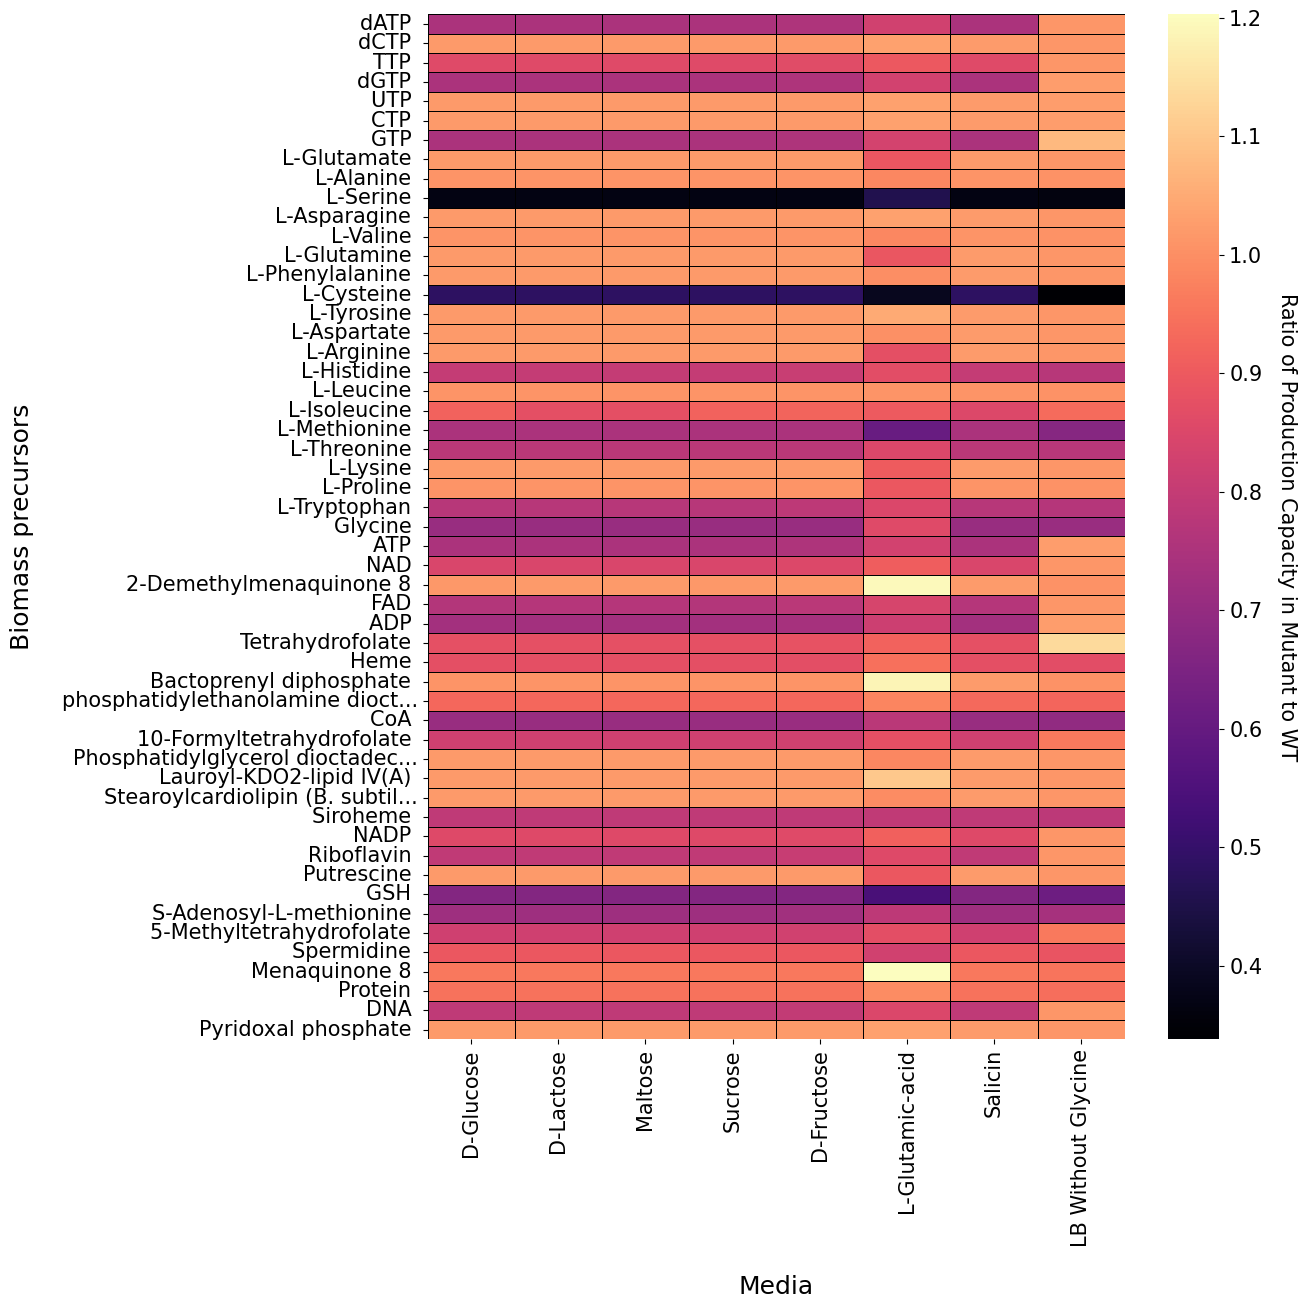

In [ ]:
#@markdown Heatmap showing the ratio of the production capacity of biomass precursors in mutant vs wild-type (can choose mutant)

KO_mutant = "rxn01101_c0" #@param ["rxn01101_c0"]{allow-input: false}
create_figure = "yes" #@param ["yes", "no"] {allow-input: false}

approach = "FBA"
approach_map = {"FBA": 0, "MOMA_linear": 1, "MOMA": 2}

media_list_map_0 = {"LB_wo_serine": "LB Without Serine", "LB_wo_glycine":"LB Without Glycine","LB_wo_threonine":"LB Without Threonine",
                  "LB_plus_serine": "LB Plus Serine", "LB_plus_glycine":"LB Plus Glycine", "LB_plus_threonine":"LB Plus Threonine"}


if create_figure == "yes":
  mutant_dict = {"rxn01101_c0": "phosphoglycerate dehydrogenase (M666_RS17370)"}

  media_list = defined_mets + ["LB_wo_glycine"] #+ ["LB_wo_serine", "LB_wo_threonine", "LB", "LB_plus_glycine", "LB_plus_serine", "LB_plus_threonine"]

  plot_dict = {}

  for item in media_list:
    max_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation+ "/max_precursors/" + item + "_" + KO_mutant + media_condition + ".json"
    with open(max_file, 'r') as f:
      plot_dict[item] = json.load(f)

  if "ecoli" not in model_name:
    unique_to_DNA = DNA_precursors - mRNA_precursors - prot_precursors - biomass_precursors
    unique_to_RNA = mRNA_precursors - DNA_precursors - prot_precursors - biomass_precursors
    unique_to_protein = prot_precursors - DNA_precursors - mRNA_precursors - biomass_precursors
    others = set(all_precursors) - unique_to_DNA - unique_to_RNA - unique_to_protein - {"cpd11416_c0"}
    precursor_list = list(unique_to_DNA) + list(unique_to_RNA) + list(unique_to_protein) + list(others) + ["biomass_reaction"]
  else: precursor_list = list(all_precursors) + ['biomass_reaction']

  filtered_precursors =[]
  data = []
  data_biomass = []
  precursors_not_produced = []

  for my_biomass_met in precursor_list:
    my_list = []
    my_list_for_wt = []

    for media in media_list:
      max_capacity = plot_dict[media][my_biomass_met][0] #there is a square bracket redundancy (e.g. [["1","2"]] to get rid of
      if max_capacity[0] == 0 and max_capacity[1] == 0: precursors_not_produced.append(my_biomass_met)

      # if my_biomass_met != 'biomass_reaction':
      #   mutant_to_wildtype_ratio  = (max_capacity[1]+epsilon)/(max_capacity[0]+epsilon)
      #   my_list.append(mutant_to_wildtype_ratio)
      # else:
      mutant_to_wildtype_ratio  = [(max_capacity[0][1]+epsilon)/(max_capacity[0][0]+epsilon),
                                    (max_capacity[1][1]+epsilon)/(max_capacity[1][0]+epsilon),
                                    (max_capacity[2][1]+epsilon)/(max_capacity[2][0]+epsilon)]
      if my_biomass_met != 'biomass_reaction': my_list.append(mutant_to_wildtype_ratio[approach_map[approach]])
      else: my_list.append(mutant_to_wildtype_ratio)

    #0.95 < element < 1.01
    if  my_biomass_met != 'biomass_reaction' and not any(element>10 for element in my_list) and not all(element==1 for element in my_list) and ('C' in model_0.metabolites.get_by_id(my_biomass_met).elements): #if the production capacity in wt and mutant differ by more than 1%
      filtered_precursors.append(my_biomass_met)
      data.append(my_list)
    if my_biomass_met == 'biomass_reaction':
      data_biomass.append(my_list)

  data_array_biomass = np.array(data_biomass).reshape(-1, 3).T
  data_array = np.array(data)

  col_names = [(media_list_map_0[item] if item in media_list_map_0 else item) for item in media_list] #media_list
  rows = filtered_precursors
  row_names = [abbreviate_pathways(model_1.metabolites.get_by_id(i).name.strip("[c0]")) for i in filtered_precursors]


  # Creating figure
  plt.figure(figsize=(14, 14))


  ax = sns.heatmap(data_array, annot=False, fmt=".2f", cmap='magma', cbar=True, linewidths=.5, linecolor='black',
              xticklabels=col_names, yticklabels=row_names, annot_kws={"size": 12}) #, vmin=0.5, vmax=1

  #save_array_as_tsv(data_array, col_names, row_names, "biomass/precursor_production_capacity.tsv")


  plt.xticks(rotation=90, fontsize = 15)#, fontweight='bold')
  plt.yticks(rotation=0, fontsize = 15)#, fontweight='bold')
  plt.xlabel("Media", fontsize=18, labelpad=20)#, fontweight='bold')
  plt.ylabel("Biomass precursors", fontsize=18, labelpad=20)#, fontweight='bold')
  #plt.title("Biomass Precursor Production in Wild Type vs Mutant\n[" + mutant_dict[KO_mutant]+"]", fontsize=18, pad=30)

  # Adjust color bar position and size
  cbar = ax.collections[0].colorbar
  cbar.ax.tick_params(labelsize=15)
  cbar.ax.set_ylabel('Ratio of Production Capacity in Mutant to WT', rotation=270, fontsize=15, labelpad=25)

  fig = plt.gcf()
  fig.tight_layout(pad=4.0)
  #figure_name = "figures/production_capacity_ratio/" + KO_mutant + model_name.replace("/","") + media_condition + ".svg"
  #plt.savefig(figure_name, dpi=500, bbox_inches="tight", format="svg")

  plt.show()

Array saved as /content/drive/MyDrive/work/data/virocells/my_analysis/version_1/CBA_mutants/simulations/CBA18_RAST_defined_add_threonine_adolase/other/relative_growth_vs_predictions.tsv


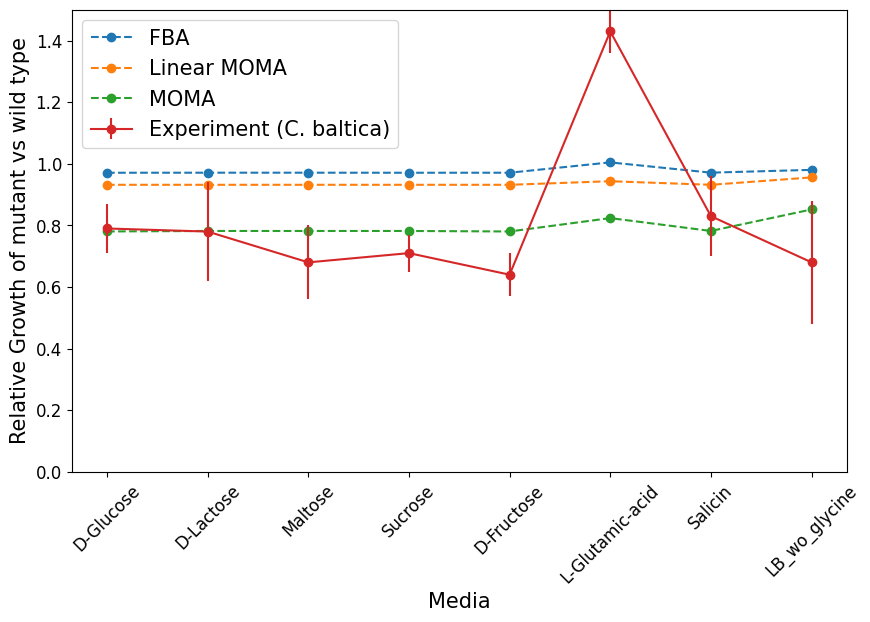

In [ ]:
# @title

#@markdown Line plot showing measured vs predicted relative growth

create_figure = "yes" #@param ["yes", "no"] {allow-input: false}

if create_figure == "yes":
  plt.figure(figsize=(10, 6))

  if KO_mutant == "rxn01101_c0":
    growth_values = list(rel_growth[media_list].loc[list(id_mapping.keys())].loc["184f1"])
    growth_values_unc = list(rel_growth_unc[media_list].loc[list(id_mapping.keys())].loc["184f1"])
  elif KO_mutant == "rxn01485_c0-181a7":
    growth_values = list(rel_growth[media_list].loc[list(id_mapping.keys())].loc["181a7"])
    growth_values_unc = list(rel_growth_unc[media_list].loc[list(id_mapping.keys())].loc["181a7"])

  legend= ["FBA", "Linear MOMA", "MOMA"]

  if True:
    table_path = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/other/relative_growth_vs_predictions.tsv"
    #save_array_as_tsv(data_array, col_names, row_names, table_path)
    data_array_to_save = np.append(data_array_biomass, [growth_values, growth_values_unc], axis=0)
    save_array_as_tsv(data_array_to_save, media_list, legend + ["experiment","uncertainty_in_exp"], table_path)

  for i, label in enumerate(legend):
    plt.plot(media_list, data_array_biomass[i], marker='o', label=label, linestyle='--')
  plt.errorbar(media_list, growth_values, yerr=growth_values_unc, marker='o', label="Experiment (C. baltica)")

  # data_array = np.append(data_array_biomass[:-1], [growth_values, growth_values_unc], axis=0)
  # save_array_as_tsv(data_array, media_list, legend + ["experiment","uncertainty_in_exp"], "biomass/growth_pred_vs_exp.tsv")

  # Adding title and labels
  plt.xlabel('Media', fontsize = 15)
  plt.ylabel("Relative Growth of mutant vs wild type", fontsize=15)
  plt.xticks(rotation=45, fontsize = 12)
  plt.yticks(fontsize = 12)
  plt.ylim(0,1.5)
  plt.legend(fontsize =15)

  figure_name = "figures/relative_growth.svg"
  plt.savefig(figure_name, dpi=500, bbox_inches="tight", format="svg")

#### Fluxes (Boundary and Internal) in Mutant vs WT

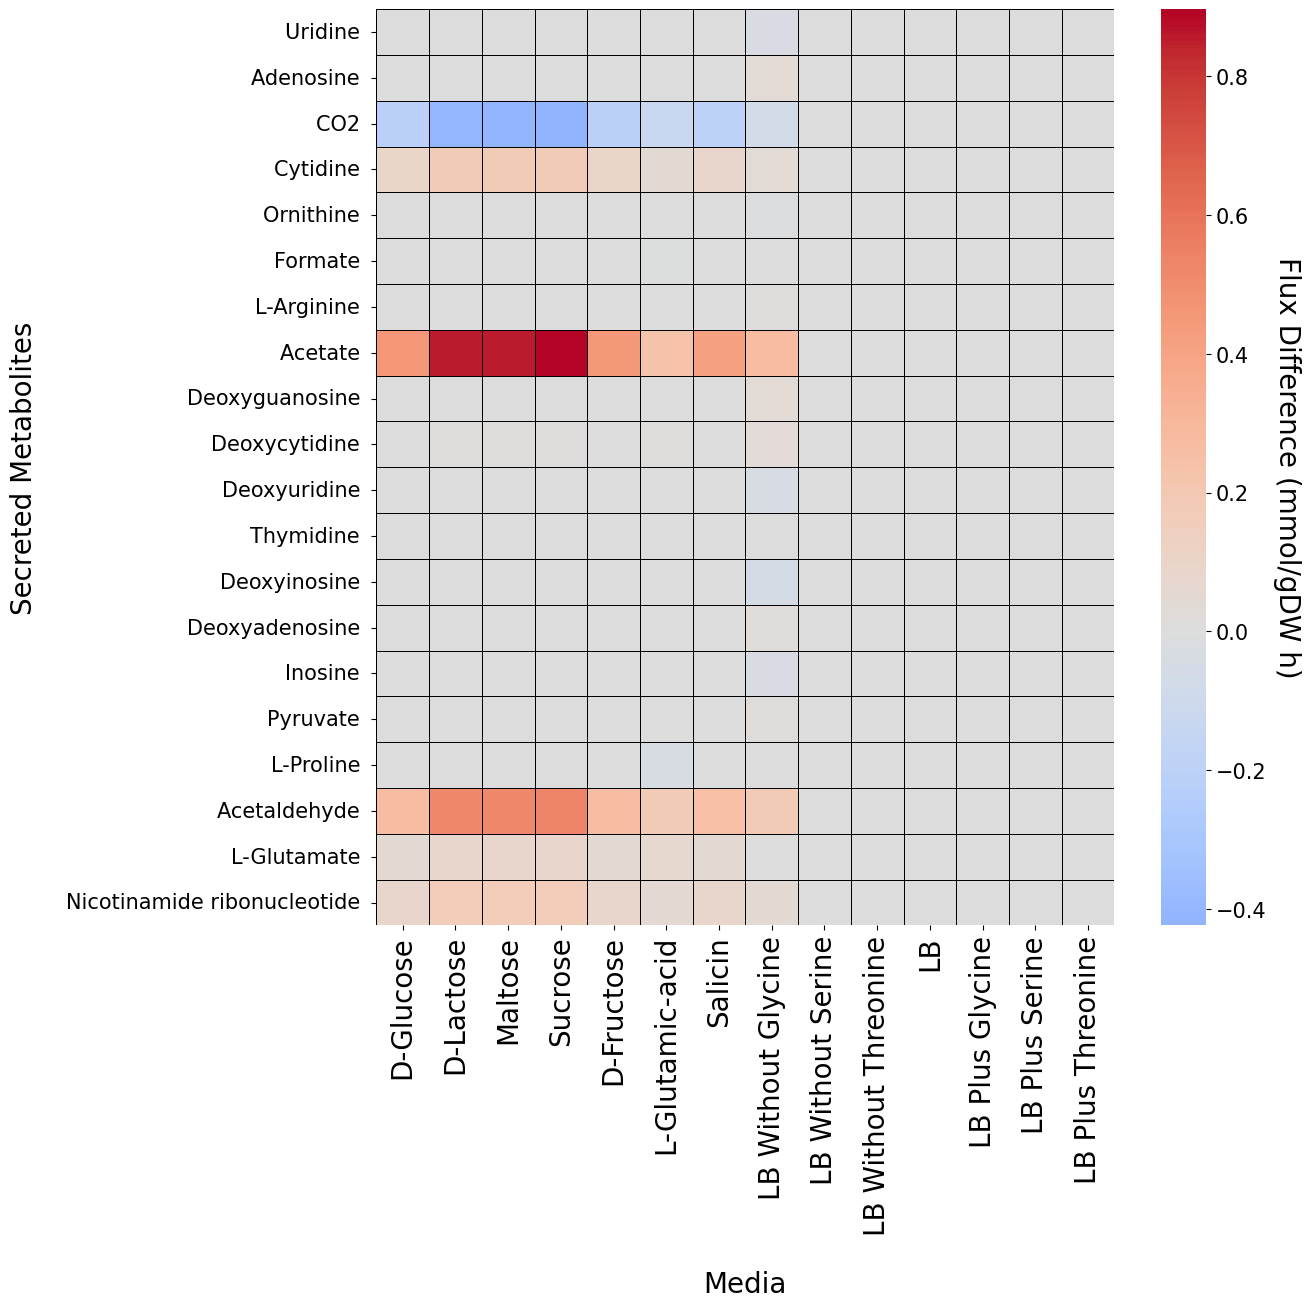

In [ ]:

#@markdown heatmap showing boundary fluxes in the wt vs mutant

mutant = "rxn01101_c0" #@param ["rxn01485_c0-181a7", "rxn01101_c0"]{allow-input: false}
approach = "MOMA" #@param ["FBA", "MOMA_linear", "MOMA"] {allow-input: false}
metric = "difference" #@param ["difference", "normalized_difference", "ratio"] {allow-input: false}
create_figure = "yes" #@param ["yes", "no"] {allow-input: false}

compartment = "boundary"
approach_map = {"FBA": 0, "MOMA_linear": 1, "MOMA": 2}
media_list_map = {"D-Glucose":"D-Glucose", "LB/LB":"LB", "LB/LB_wo_serine": "LB Without Serine", "LB/LB_wo_glycine":"LB Without Glycine","LB/LB_wo_threonine":"LB Without Threonine",
                  "LB/LB_plus_serine": "LB Plus Serine", "LB/LB_plus_glycine":"LB Plus Glycine", "LB/LB_plus_threonine":"LB Plus Threonine"}

flux_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/fluxes/" + mutant + "_" + metric + media_condition + ".json"
difference_flux_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/fluxes/" + mutant + "_difference" + media_condition + ".json"

if create_figure == "yes":
  media_list = defined_mets + ["LB/LB_wo_glycine"] + ["LB/LB_wo_serine", "LB/LB_wo_threonine", "LB/LB", "LB/LB_plus_glycine", "LB/LB_plus_serine", "LB/LB_plus_threonine"]

  with open(flux_file, 'r') as f:
    plot_dict = json.load(f)

  with open(difference_flux_file, 'r') as f:
    helper_plot_dict = json.load(f)

  filtered_rxns =[]
  data = []

  for i in range(len(plot_dict["all_rxns"])):
    my_list = []
    my_helper_list = []
    for media in media_list:
      my_list.append(plot_dict[media][i][approach_map[approach]])
      my_helper_list.append(helper_plot_dict[media][i][approach_map[approach]])

    #if there is a difference between the WT and the mutant
    if not all(round(abs(element),5) == 0 for element in my_helper_list) and (plot_dict["all_rxns"][i] in plot_dict[compartment]):
      filtered_rxns.append(plot_dict["all_rxns"][i])
      data.append(my_list)

  data_array = np.array(data)

  col_names = [(media_list_map[item] if item in media_list_map else item) for item in media_list]
  rows = filtered_rxns
  row_names = [abbreviate_pathways(model_0.metabolites.get_by_id("_".join(i.split("_")[1:])).name.replace("[e0]","").replace("[c0]","")) for i in filtered_rxns]

  #Create Figure
  plt.figure(figsize=(14, 14))

  #norm = TwoSlopeNorm(vmin=data_array.min(), vcenter=0, vmax=data_array.max())

  ax = sns.heatmap(data_array, annot=False, fmt=".3f", cmap='coolwarm', center=0, cbar=True, linewidths=.5, linecolor='black',
              xticklabels=col_names, yticklabels=row_names, annot_kws={"size": 10})

  # save_array_as_tsv(data_array, col_names, row_names, "secretion_fluxes/"+ metric +".tsv")

  plt.xticks(rotation=90, fontsize = 20)#, fontweight='bold')
  plt.yticks(rotation=0, fontsize = 15)#, fontweight='bold')
  plt.xlabel("Media", fontsize=20, labelpad=25) #, fontweight='bold')
  plt.ylabel("Secreted Metabolites", fontsize=20, labelpad=20) #, fontweight='bold')

  # Adjust color bar position and size

  cbar = ax.collections[0].colorbar
  # cbar_ticks = [round(norm.vmin,1), round(norm.vcenter,1), round(norm.vmax,1)]
  # cbar.set_ticks(cbar_ticks)
  cbar.ax.tick_params(labelsize=15)
  if metric == "difference": cbar.ax.set_ylabel('Flux Difference (mmol/gDW h)', rotation=270, fontsize=20, labelpad=25)
  elif metric == "normalized_difference": cbar.ax.set_ylabel('Normalized Flux Difference', rotation=270, fontsize=20, labelpad=25)

  fig = plt.gcf()
  fig.tight_layout(pad=4.0)
  #figure_name = "figures/secretion_fluxes/" + mutant + model_name.replace("/","") + approach + compartment + ".svg"
  #plt.savefig(figure_name, dpi=500, bbox_inches="tight", format="svg")

  plt.show()


<ipython-input-29-cf22a60cf0df>:55: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  fig.tight_layout(pad=4.0)


<Figure size 1400x1400 with 0 Axes>

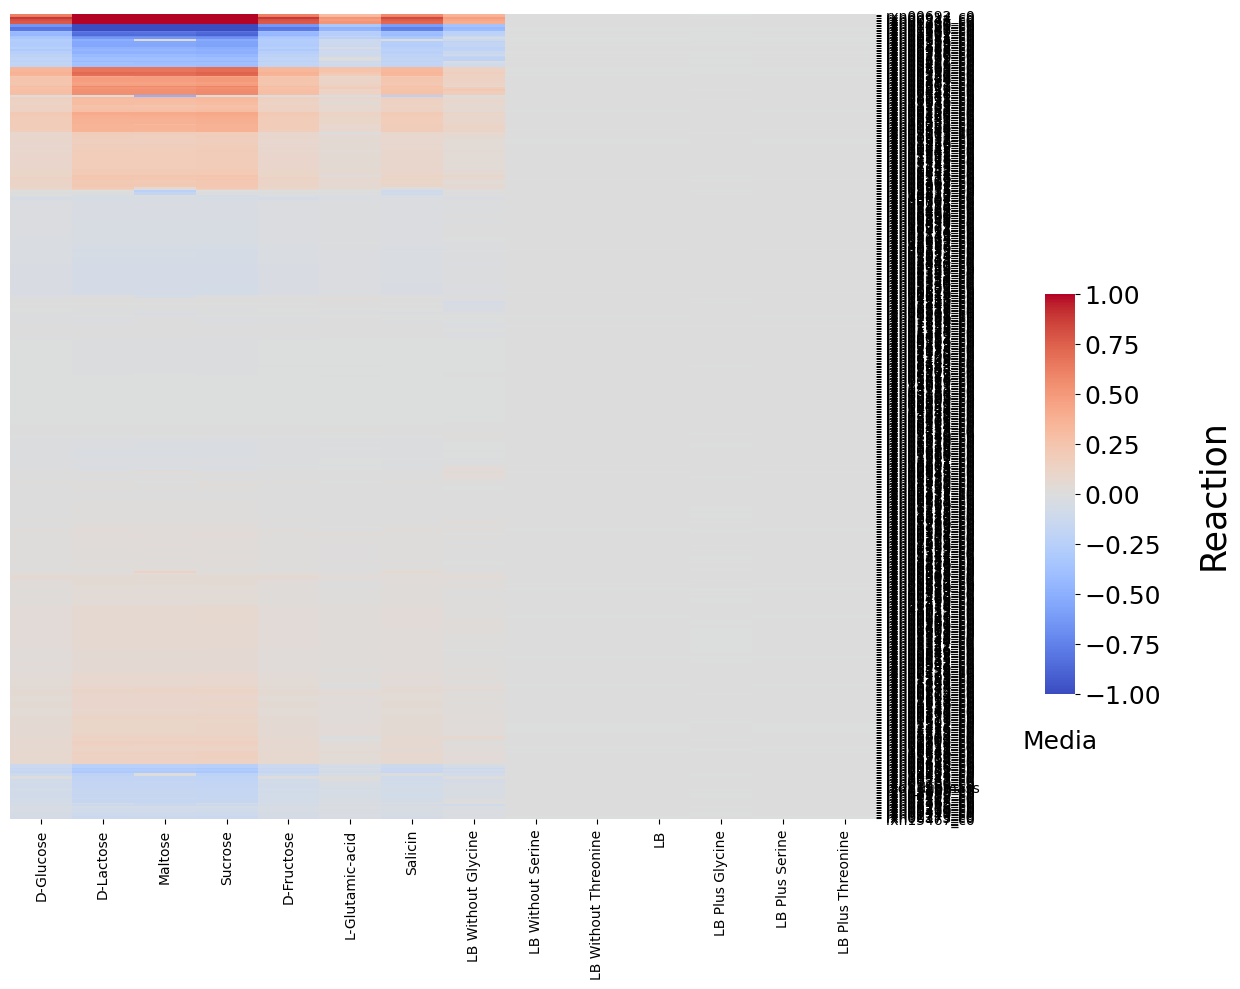

In [ ]:

#@markdown heatmap showing internal fluxes in the wt vs mutant

mutant = "rxn01101_c0" #@param ["rxn01485_c0-181a7", "rxn01101_c0"]{allow-input: false}
approach = "MOMA" #@param ["FBA", "MOMA_linear", "MOMA"] {allow-input: false}
metric = "difference" #@param ["difference", "normalized_difference"] {allow-input: false}
create_figure = "yes" #@param ["yes", "no"] {allow-input: false}

compartment = "internal"
approach_map = {"FBA": 0, "MOMA_linear": 1, "MOMA": 2}

flux_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/fluxes/" + mutant + "_" + metric + media_condition + ".json"

if create_figure == "yes":
  media_list = defined_mets + ["LB/LB_wo_glycine"] + ["LB/LB_wo_serine", "LB/LB_wo_threonine", "LB/LB", "LB/LB_plus_glycine", "LB/LB_plus_serine", "LB/LB_plus_threonine"]

  with open(flux_file, 'r') as f:
    plot_dict = json.load(f)

  filtered_rxns =[]
  data = []

  for i in range(len(plot_dict["all_rxns"])):
    my_list = []
    for media in media_list:
      internal_flux = plot_dict[media][i][approach_map[approach]]
      my_list.append(internal_flux)

    # if WT differes from mutant in any of the growth conditions
    if not all(round(abs(element),2) ==0 for element in my_list) and (plot_dict["all_rxns"][i] in plot_dict[compartment]):
      filtered_rxns.append(plot_dict["all_rxns"][i])
      data.append(my_list)

  data_array = np.array(data)

  col_names = [(media_list_map[item] if item in media_list_map else item) for item in media_list]
  rows = filtered_rxns
  row_names = filtered_rxns

  # Create Figure
  plt.figure(figsize=(14, 14))

  ax= sns.clustermap(data_array, annot=False, cmap='coolwarm', cbar_kws={'label': 'Flux (mmol/gDW h)'}, linewidths=0.0001,
                     linecolor='black', col_cluster=False, row_cluster=True, vmin=-1, vmax=1,
                     dendrogram_ratio=(0.0001, 0), cbar_pos=(1.05, 0.3, 0.03, 0.4), annot_kws={"size": 10},
                     xticklabels=col_names, yticklabels=row_names)

  #save_array_as_tsv(data_array, col_names, row_names, "internal_fluxes/reactions_"+ metric +".tsv")

  plt.xticks(rotation=90, fontsize = 18) #, fontweight='bold')
  plt.yticks(rotation=0, fontsize = 18) #, fontweight='bold')
  plt.xlabel("Media", fontsize=18, labelpad=25) #, fontweight='bold')
  plt.ylabel("Reaction", fontsize=25, labelpad=25) #, fontweight='bold')

  fig = plt.gcf()
  fig.tight_layout(pad=4.0)
  #figure_name = "figures/secretion_fluxes/" + mutant + model_name.replace("/","") + approach + compartment + ".svg"
  #plt.savefig(figure_name, dpi=500, bbox_inches="tight", format="svg")

  plt.show()


<Figure size 1800x1980 with 0 Axes>

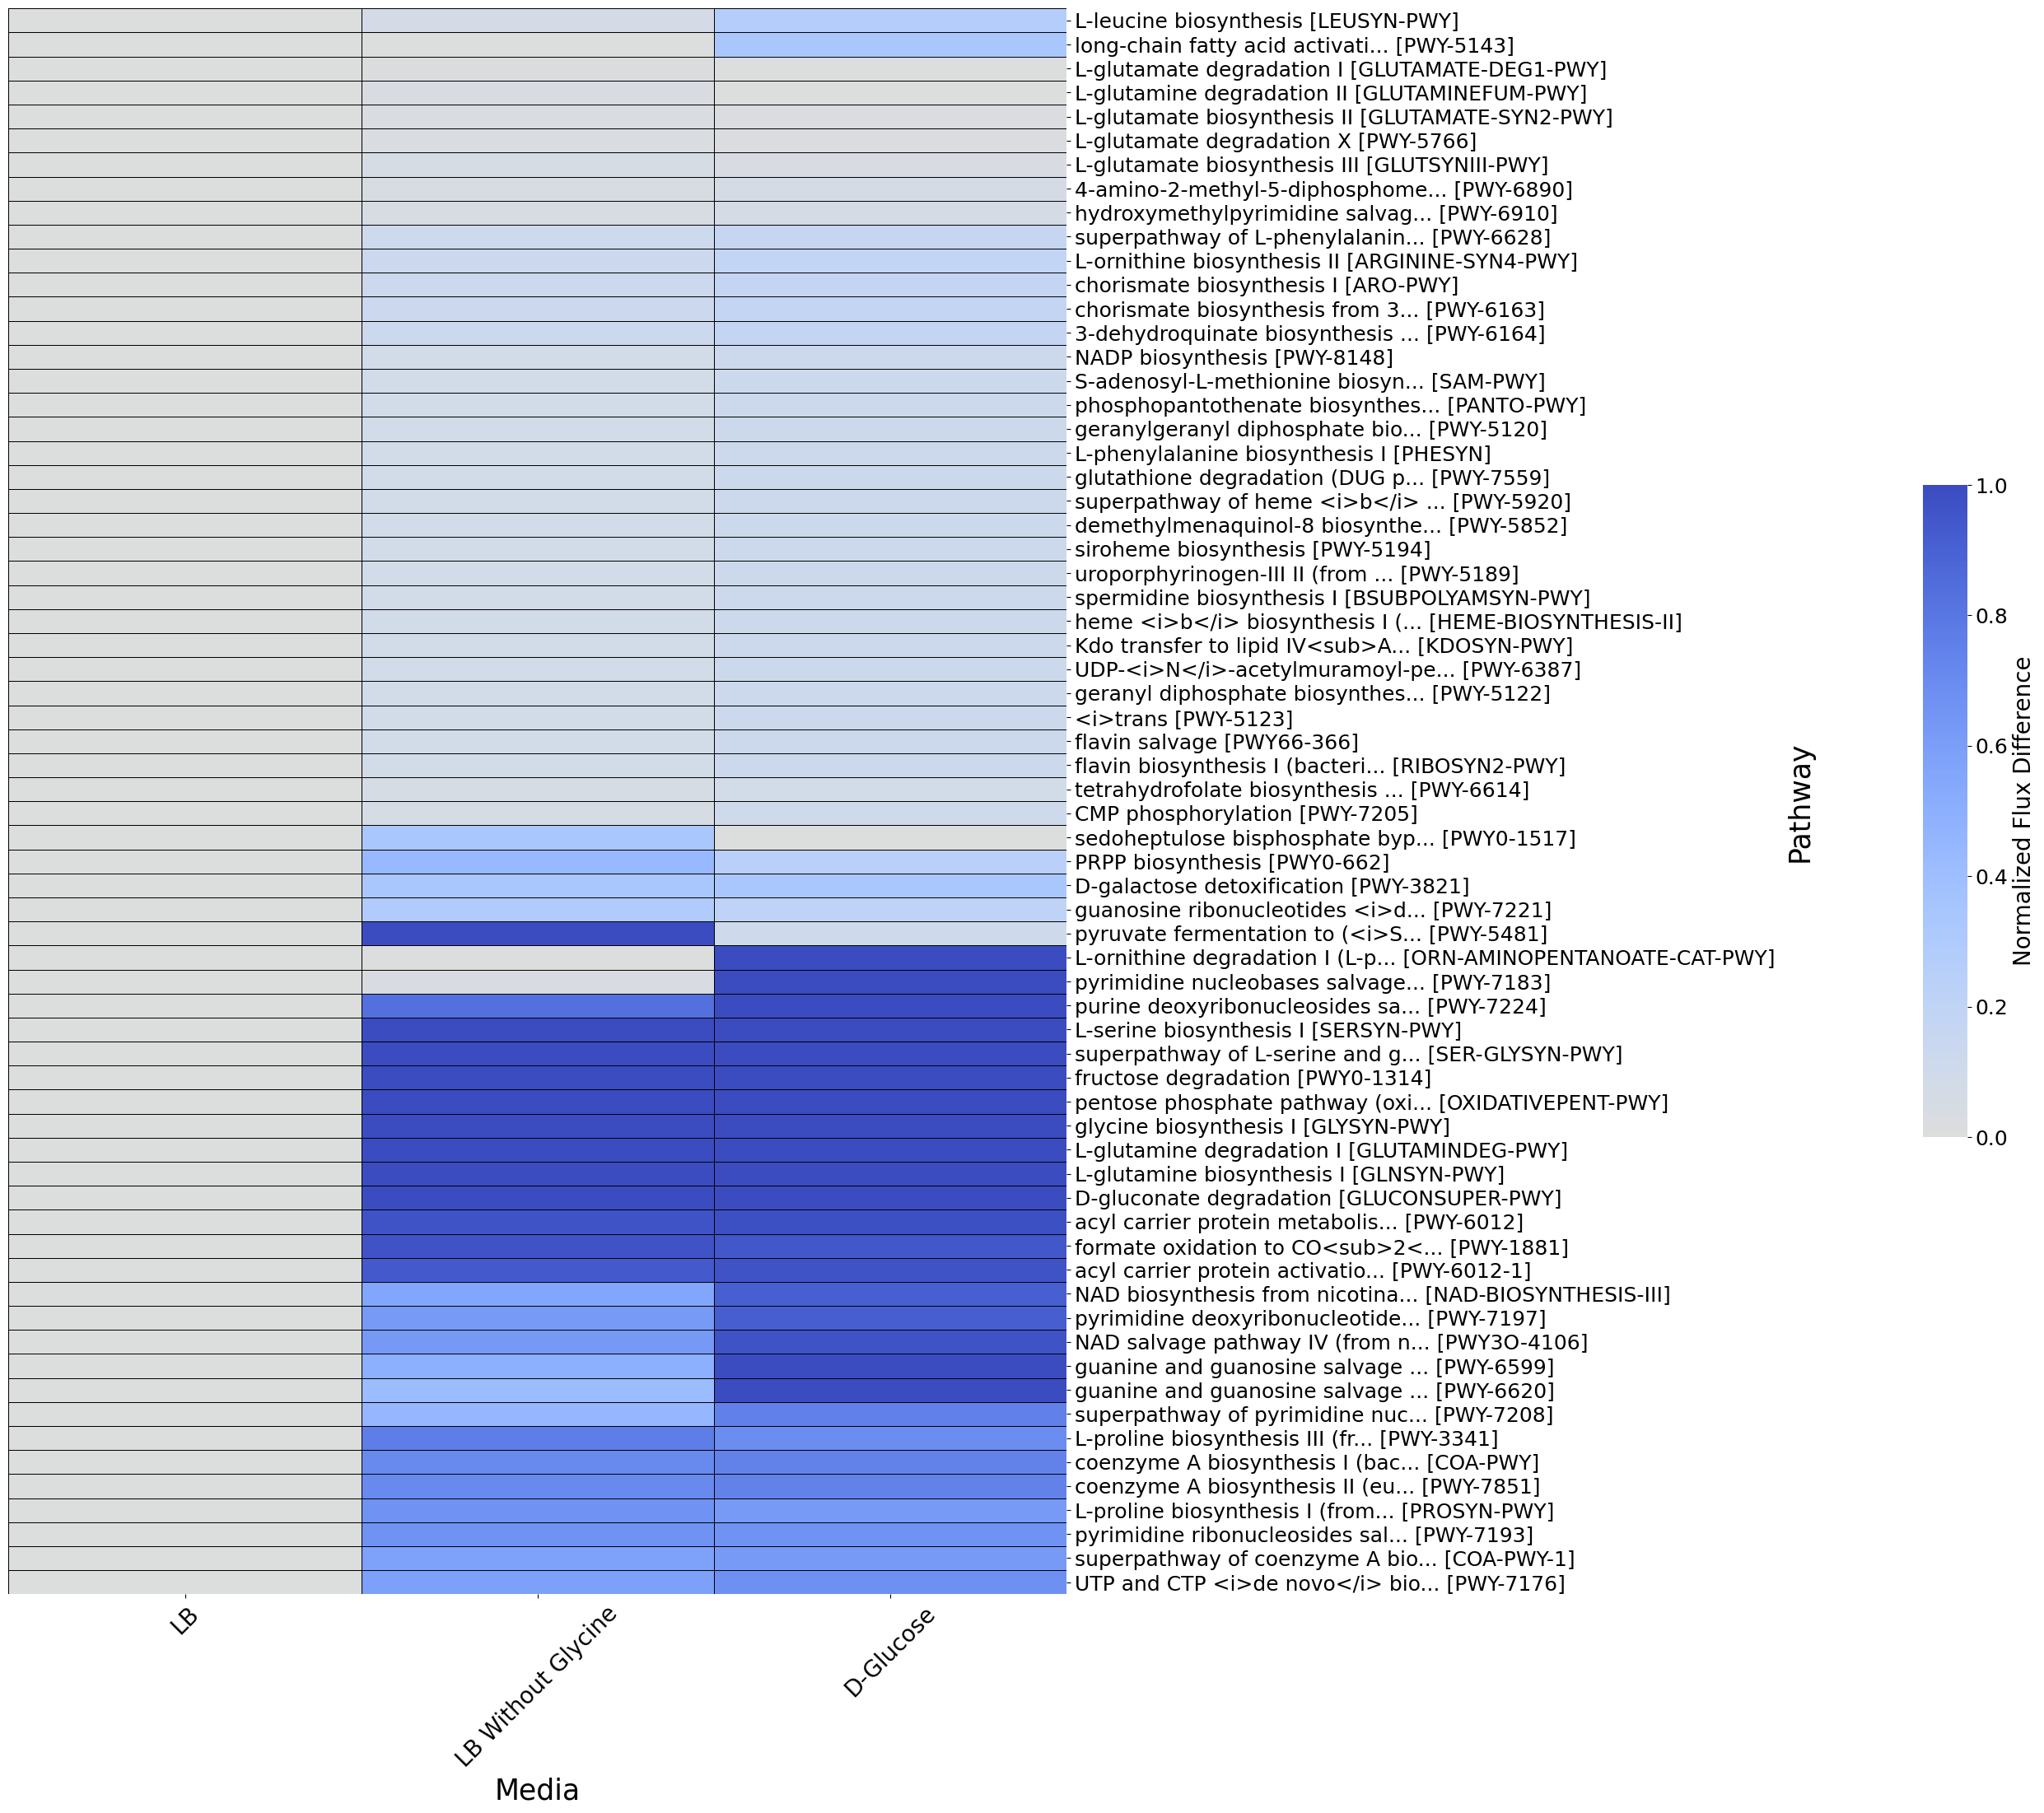

In [ ]:
#@markdown heatmap showing average fluxes in kegg or metacyc modules in WT vs mutant

mutant = "rxn01101_c0" #@param ["rxn01485_c0-181a7", "rxn01101_c0"]{allow-input: false}
approach = "MOMA" #@param ["FBA", "MOMA_linear", "MOMA"] {allow-input: false}
difference_type = "_normalized_difference" #@param ["_difference", "_normalized_difference"] {allow-input: false}
metric = "mean_abs_diff" #@param ["mean_diff", "mean_abs_diff"] {allow-input: false}
create_figure = "yes" #@param ["yes", "no"] {allow-input: false}
database = "metacyc" #@param ["kegg", "metacyc"] {allow-input: false}
pathway_completeness = "1.0" #@param ["0.7", "1.0"] {allow-input: false}

approach_map = {"FBA": 0, "MOMA_linear": 1, "MOMA": 2}

#modules to be excluded because they have plant, archaea or eukaryotes in their description (the descriptions are in kegg_module_description or metacyc_module_description)
module_exclude_list = []#["M00365", "M00366", "M00367", "M00868", "M00580", "M00158", "M00160", "PWY-7851", "COA-PWY-1", "M00157", "M00159"]


if database == "kegg": db_reaction_module_dict, db_module_reaction_dict, db_module_description, db_annotations, db_reactions_in_model = kegg_reaction_module_dict, kegg_module_reaction_dict, kegg_module_description, kegg_annotations, kegg_reactions_in_model
elif database == "metacyc": db_reaction_module_dict, db_module_reaction_dict, db_module_description, db_annotations, db_reactions_in_model = metacyc_reaction_module_dict, metacyc_module_reaction_dict, metacyc_module_description, metacyc_annotations, metacyc_reactions_in_model

flux_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/fluxes/" + mutant + difference_type + media_condition + ".json"

with open(flux_file, 'r') as f:
    plot_dict = json.load(f)

if create_figure == "yes":

  media_list =["LB/LB", "LB/LB_wo_glycine", "D-Glucose" ] # defined_mets + ["LB/LB_wo_glycine"] + ["LB/LB_wo_serine", "LB/LB_wo_threonine", "LB/LB", "LB/LB_plus_glycine", "LB/LB_plus_serine", "LB/LB_plus_threonine"]

  db_mod_dict = defaultdict(list)

  for i in range(len(plot_dict["all_rxns"])):
    seed_rxn = plot_dict["all_rxns"][i]

    if seed_rxn in db_annotations:
      for db_rxn in db_annotations[seed_rxn]:
        if db_rxn in db_reaction_module_dict:
          db_mods = db_reaction_module_dict[db_rxn]

          rxn_flux_list = []
          for media in media_list:
            rxn_flux = plot_dict[media][i][approach_map[approach]]
            rxn_flux_list.append(rxn_flux)

          for db_mod in db_mods:
            db_mod_dict[db_mod].append(rxn_flux_list)

  db_mod_dict = {key: db_mod_dict[key] for key in sorted(db_mod_dict)}
  filtered_db_mods =[]
  data = []

  for mod in db_mod_dict:

    # if metric=="normalized_difference": avg_for_db_mod = [round(np.mean(sublist),2)+0 for sublist in zip(*db_mod_dict[mod])]
    if metric == "mean_abs_diff": avg_for_db_mod = [np.mean([abs(i) for i in sublist]) for sublist in zip(*db_mod_dict[mod])] # average of absolute differences
    if metric == "mean_diff": avg_for_db_mod = [np.mean(sublist) for sublist in zip(*db_mod_dict[mod])] # average of differences

    total_rxns_in_module = len(db_module_reaction_dict[mod])
    those_present_in_model = len(db_module_reaction_dict[mod] & db_reactions_in_model)
    fraction_of_module_present = those_present_in_model/total_rxns_in_module

    # if the fluxes differ between the WT and the mutant
    if not all(round(abs(element),2) == 0 for element in avg_for_db_mod) and fraction_of_module_present >= float(pathway_completeness) and mod not in module_exclude_list:
      filtered_db_mods.append(mod)
      data.append(avg_for_db_mod)

  data_array = np.array(data)

  col_names = [(media_list_map[item] if item in media_list_map else item) for item in media_list]
  rows = filtered_db_mods
  row_names = [abbreviate_pathways(db_module_description[i].split(",")[0]) + " ["+i+"] " for i in rows] #

  #creating figure
  plt.figure(figsize=(18, max(14, len(filtered_db_mods)*0.3)))

  # ax = sns.clustermap(data_array, annot=False, cmap='coolwarm', linewidths=0.5,
  #                    linecolor='black', col_cluster=False, row_cluster=True, center=0,
  #                    dendrogram_ratio=(0.0001, 0), cbar_pos=(1.05, 0.3, 0.03, 0.4), annot_kws={"size": 10},
  #                    xticklabels=col_names, yticklabels=row_names)


  ax = sns.clustermap(data_array,
                    annot=False,
                    cmap='coolwarm_r',
                    linewidths=0.5,
                    linecolor='black',
                    col_cluster=False,
                    row_cluster=True,
                    center=0,
                    dendrogram_ratio=(0.0001, 0),  # Adjust for better proportions
                    cbar_pos=(1.3, 0.3, 0.03, 0.4),  # Reposition colorbar
                    xticklabels=col_names,
                    yticklabels=row_names,
                    figsize=(18, max(14, len(filtered_db_mods)*0.3)))  # Set figsize here too

  if database == "metacyc" and False: #only use with MOMA
    table_path = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/other/metacyc_pathway_fluxes/" + metric + "_at_"+ pathway_completeness + "_completeness.tsv"
    save_array_as_tsv(data_array, col_names, row_names, table_path)

  ax.ax_heatmap.set_xlabel('Media', fontsize = 25)
  ax.ax_heatmap.set_ylabel('Pathway', fontsize = 25 )
  ax.ax_heatmap.tick_params(axis='y', labelsize=18, rotation=0)
  ax.ax_heatmap.tick_params(axis='x', labelsize=20, rotation=45)

  cbar = ax.fig.axes[-1]  # Access the colorbar axis
  cbar.tick_params(labelsize=18)
  if  difference_type == "difference": cbar.set_ylabel('Flux Difference (mmol/gDW h)', fontsize=20)
  elif  difference_type == "_normalized_difference": cbar.set_ylabel('Normalized Flux Difference', fontsize=20)


  figure_name = "figures/pathway.svg"
  plt.savefig(figure_name, dpi=500, bbox_inches="tight", format="svg")

  plt.show()


#### Flux Variability Analysis

<ipython-input-152-95713a71cff5>:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


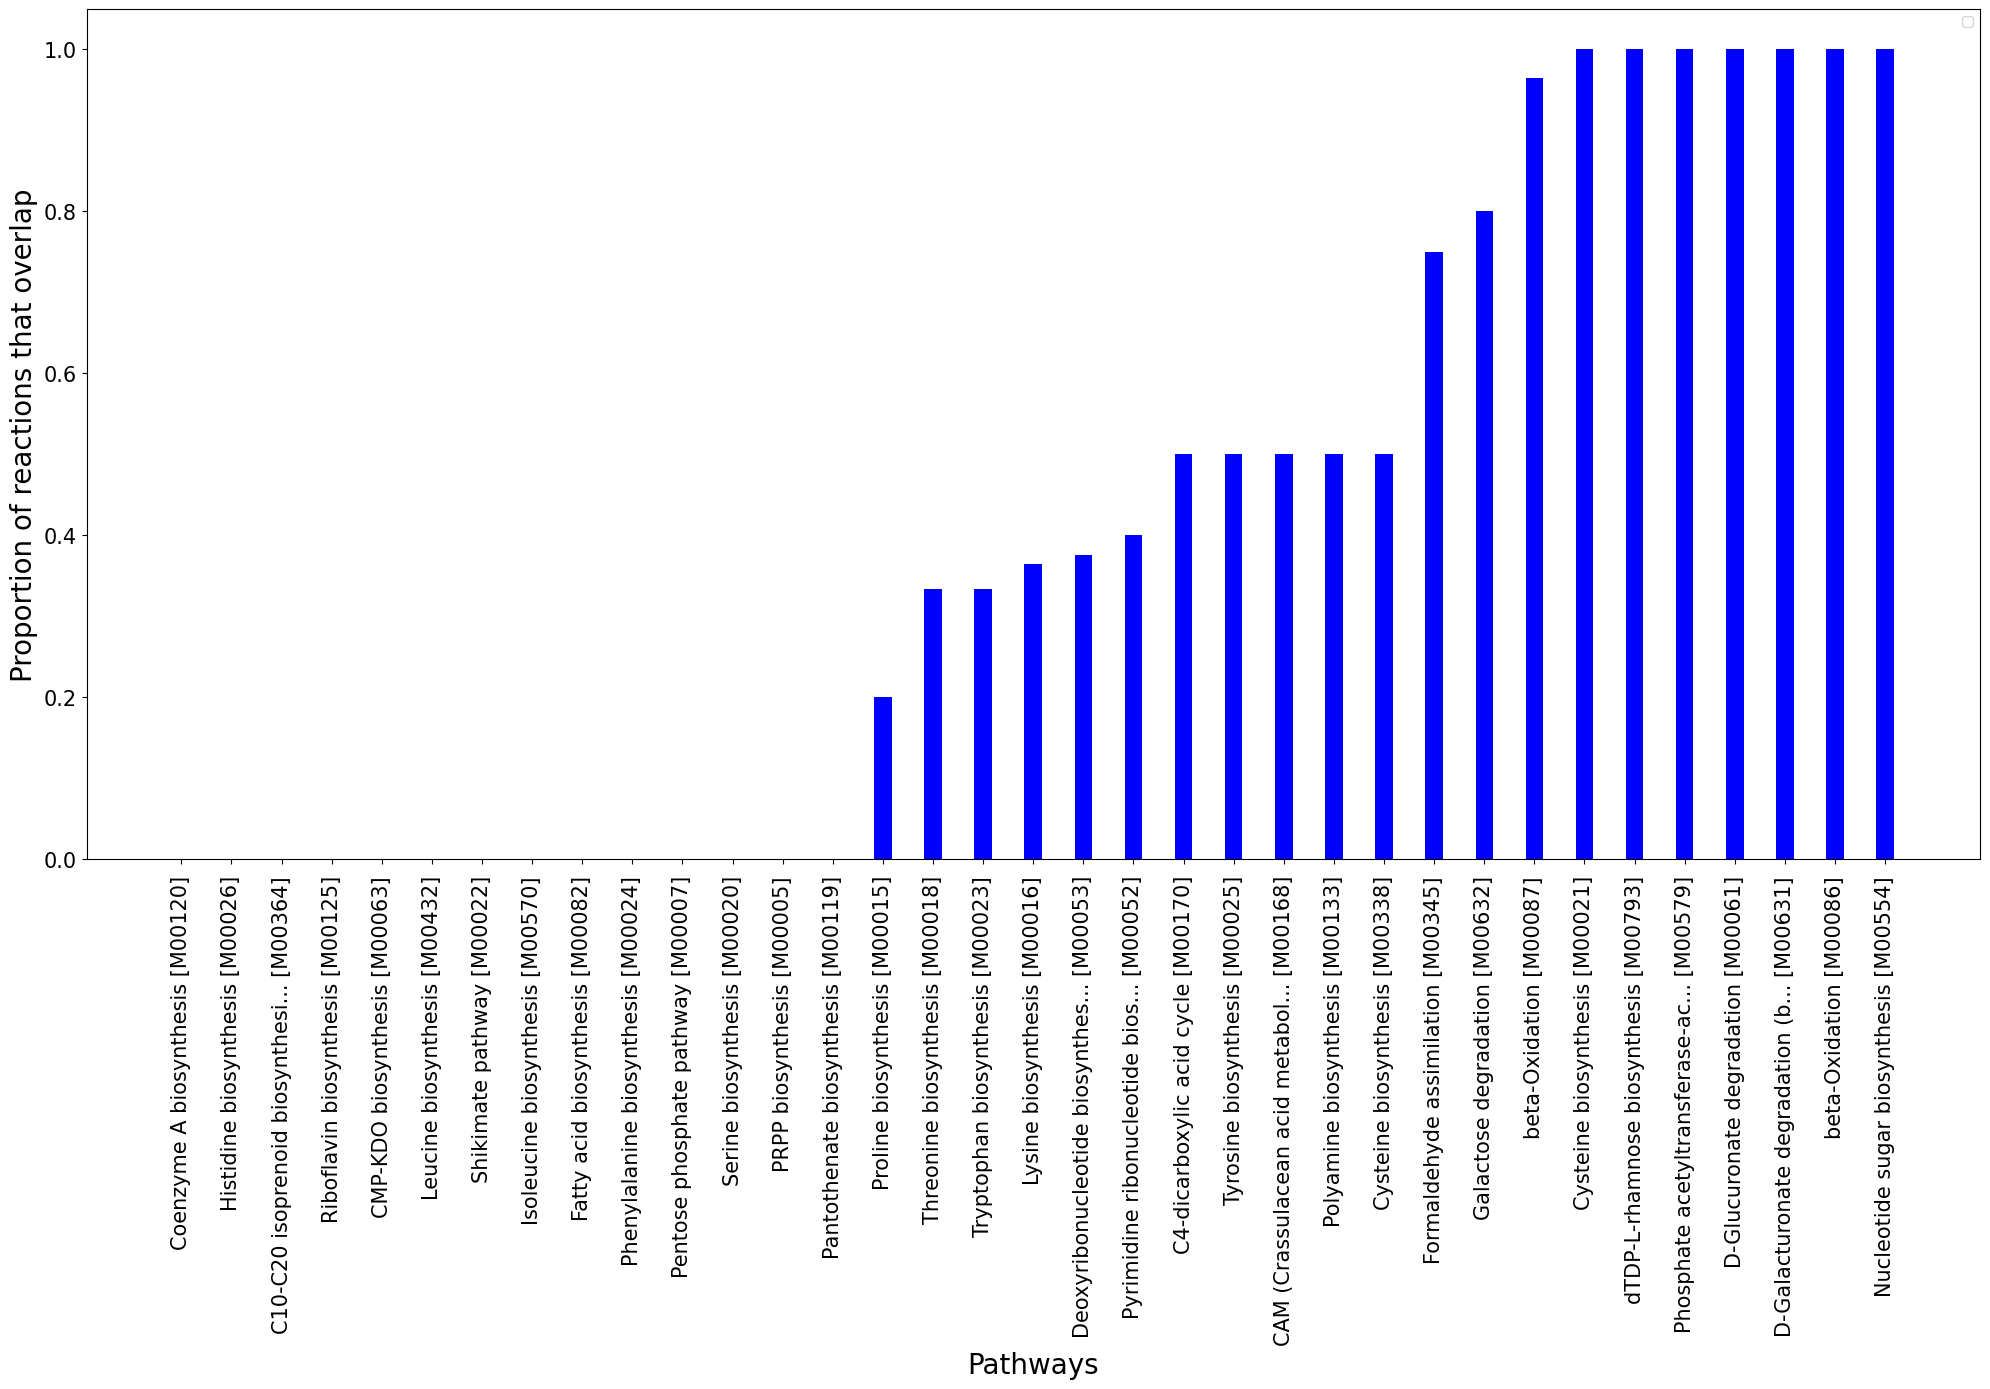

In [ ]:
#@markdown metabolic conflict

mutant = "rxn01101_c0" #@param ["rxn01485_c0-181a7", "rxn01101_c0"]{allow-input: false}
approach = "FBA" #@param ["FBA", "lin_MOMA"] {allow-input: false}
carbon_source = 'LB/LB_wo_glycine' #@param ['D-Glucose', 'D-Lactose', 'Maltose', 'Sucrose', 'D-Fructose', 'L-Glutamic-acid', 'Salicin', 'LB/LB', 'LB/LB_wo_serine', 'LB/LB_wo_glycine', 'LB/LB_wo_threonine', 'LB/LB_plus_serine', 'LB/LB_plus_glycine', 'LB/LB_plus_threonine']
create_figure = "yes" #@param ["yes", "no"] {allow-input: false}
database = "kegg" #@param ["kegg", "metacyc"] {allow-input: false}
pathway_completeness = "1.0" #@param ["0.7", "1.0"] {allow-input: false}

fva_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/FVA/" + CBA_mutant + "_" + approach + media_condition + ".json"

with open(fva_file, 'r') as f: plot_dict = json.load(f)[carbon_source]

if database == "kegg": db_reaction_module_dict, db_module_reaction_dict, db_module_description, db_annotations, db_reactions_in_model = kegg_reaction_module_dict, kegg_module_reaction_dict, kegg_module_description, kegg_annotations, kegg_reactions_in_model
elif database == "metacyc": db_reaction_module_dict, db_module_reaction_dict, db_module_description, db_annotations, db_reactions_in_model = metacyc_reaction_module_dict, metacyc_module_reaction_dict, metacyc_module_description, metacyc_annotations, metacyc_reactions_in_model

if create_figure == "yes":
  fva_overlap_dict = dict()

  for rxn in model_0.reactions:
    wt_range = (plot_dict["wild_type"]["minimum"][rxn.id], plot_dict["wild_type"]["maximum"][rxn.id])
    mutant_range = (plot_dict["mutant"]["minimum"][rxn.id], plot_dict["mutant"]["maximum"][rxn.id])

    fva_overlap_dict[rxn.id] = do_intervals_overlap(wt_range, mutant_range)

  mod_fva_dict = defaultdict(list)
  for seed_rxn in fva_overlap_dict:
    for db_rxn in db_annotations.get(seed_rxn, []):
      for db_mod in db_reaction_module_dict.get(db_rxn, []):
        mod_fva_dict[db_mod].append(fva_overlap_dict[seed_rxn])


  filtered_mod_fva_dict = dict()

  for mod in mod_fva_dict:

    proportion_with_fva_overlap = sum(mod_fva_dict[mod])/len(mod_fva_dict[mod])

    total_rxns_in_module = len(db_module_reaction_dict[mod])
    those_present_in_model = len(db_module_reaction_dict[mod] & db_reactions_in_model)
    fraction_of_module_present = those_present_in_model/total_rxns_in_module

    # if the fluxes differ between the WT and the mutant
    if fraction_of_module_present >= float(pathway_completeness) and mod not in module_exclude_list:
      filtered_mod_fva_dict[mod] = proportion_with_fva_overlap

  filtered_mod_fva_dict = dict(sorted(filtered_mod_fva_dict.items(), key=lambda item: item[1]))

  ############ create bar chart
  # Get top 20 pathways with the most conflict between the mutant and the WT
  pathways_with_most_conflict = list(filtered_mod_fva_dict.items())[:]

  # Extract keys, wt values, and mutant values
  pathway_names = [abbreviate_pathways(db_module_description.get(i[0], i[0]).split(",")[0]) + " ["+i[0]+"] " for i in pathways_with_most_conflict]
  fva_overlap_values = [item[1] for item in pathways_with_most_conflict]

  #creating figure
  plt.figure(figsize=(20, 14))

  x = range(len(pathway_names))  # Positions for the bars
  width = 0.35  # Width of the bars

  plt.bar(x, fva_overlap_values, width, color='blue')

  # Add labels and legend
  plt.xlabel('Pathways', fontsize=20)
  plt.ylabel('Proportion of reactions that overlap', fontsize=20)
  plt.xticks(x, pathway_names, rotation=90, fontsize = 15)
  plt.yticks(rotation=0, fontsize =15)
  plt.legend()

  # Show the plot
  plt.tight_layout()
  plt.show()


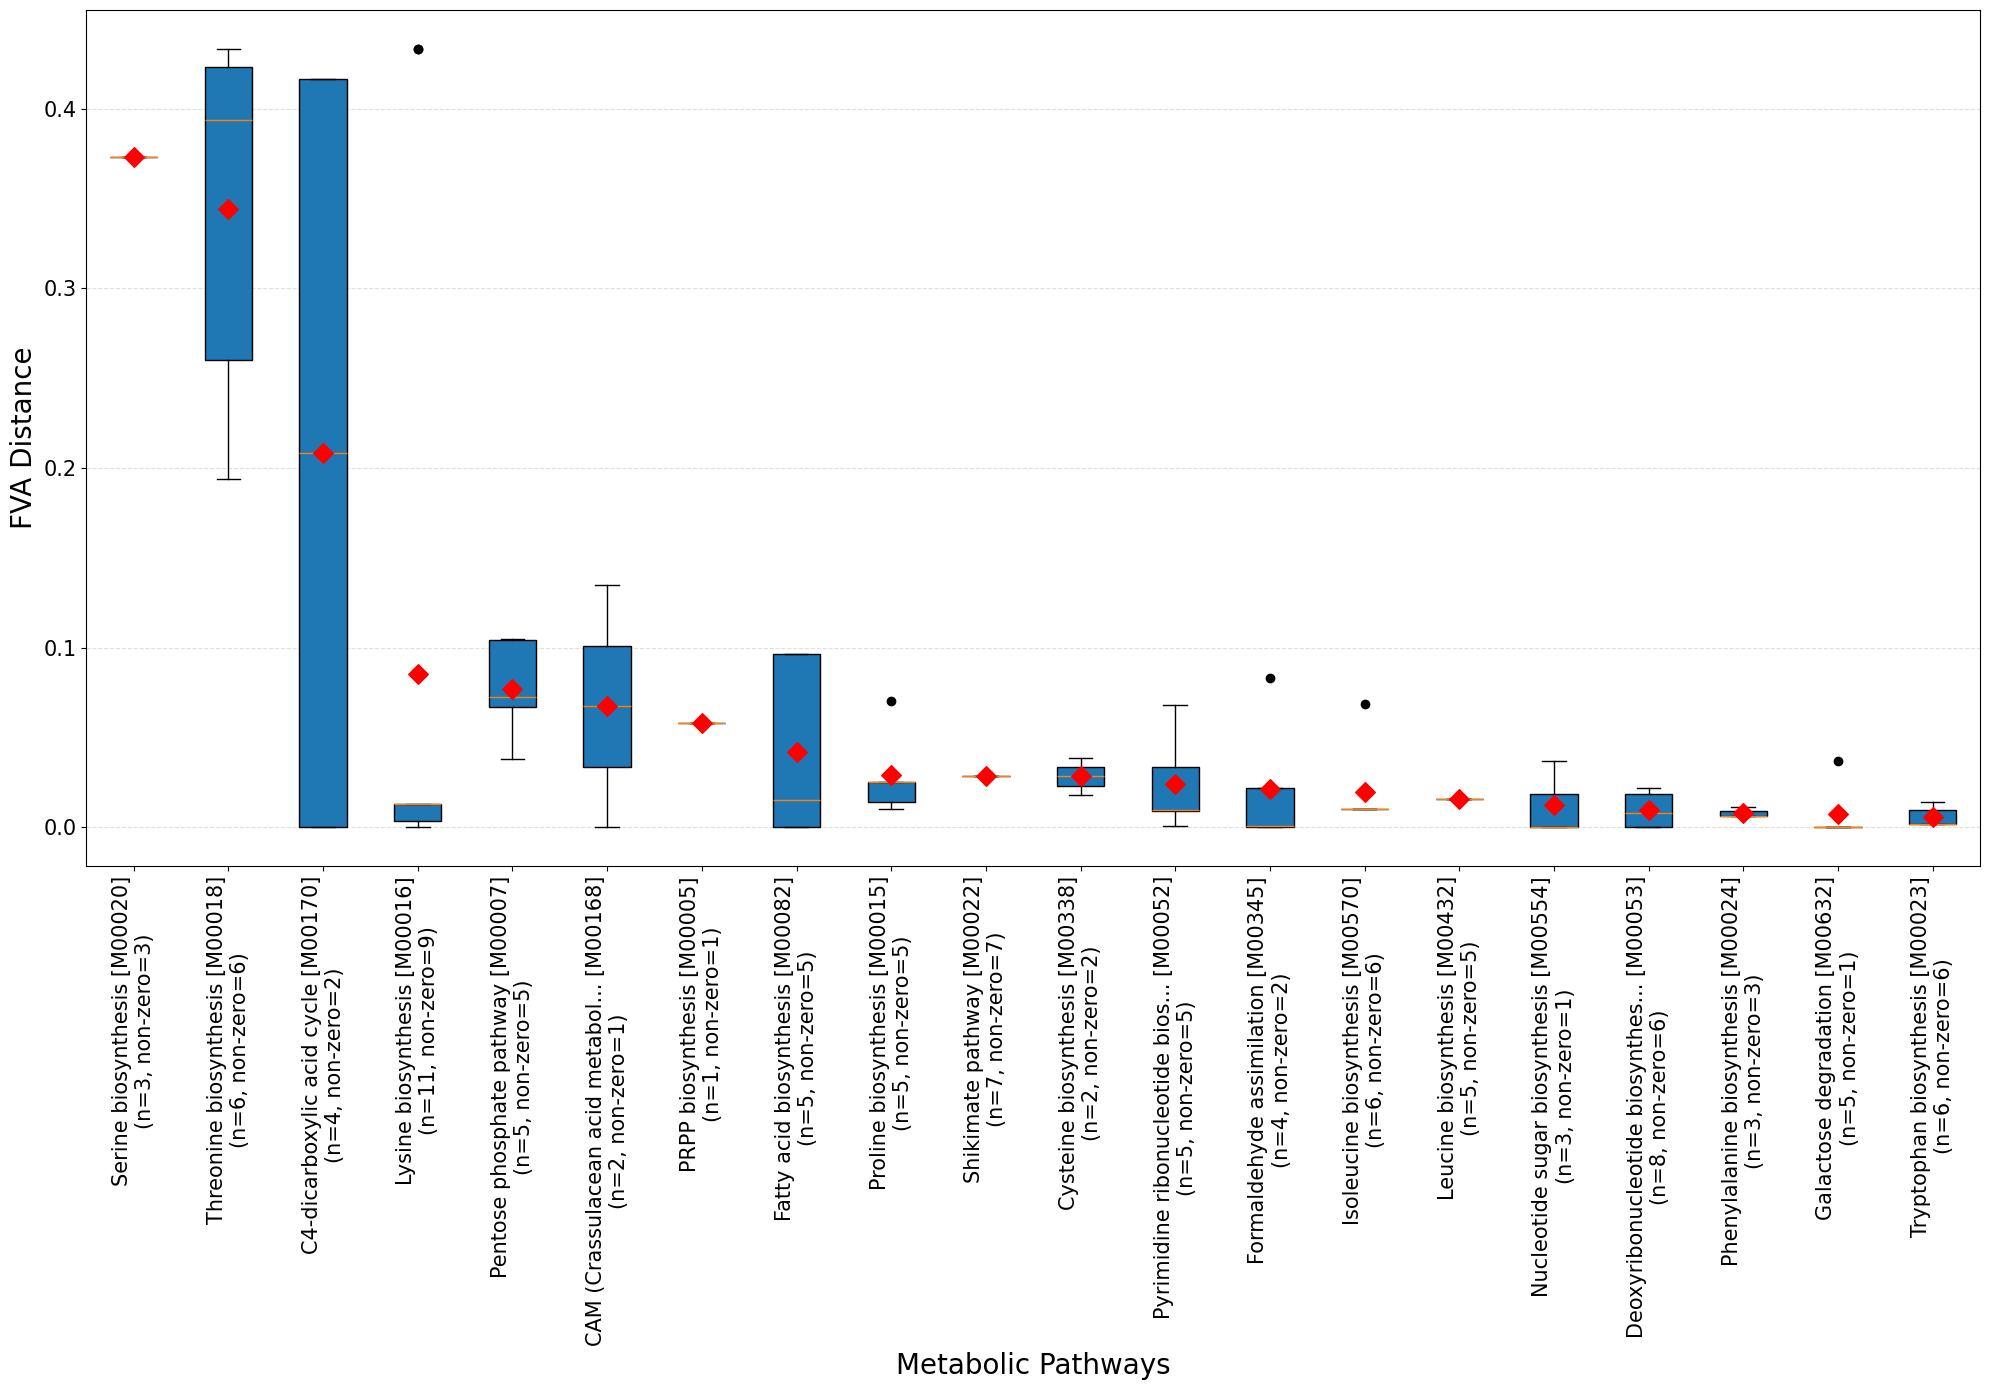

In [ ]:
#@markdown FVA distances

mutant = "rxn01101_c0" #@param ["rxn01485_c0-181a7", "rxn01101_c0"]{allow-input: false}
approach = "MOMA" #@param ["FBA", "lin_MOMA", "MOMA"] {allow-input: false}
carbon_source = 'LB/LB_wo_glycine' #@param ['D-Glucose', 'D-Lactose', 'Maltose', 'Sucrose', 'D-Fructose', 'L-Glutamic-acid', 'Salicin', 'LB/LB', 'LB/LB_wo_serine', 'LB/LB_wo_glycine', 'LB/LB_wo_threonine', 'LB/LB_plus_serine', 'LB/LB_plus_glycine', 'LB/LB_plus_threonine']
create_figure = "yes" #@param ["yes", "no"] {allow-input: false}
database = "kegg" #@param ["kegg", "metacyc"] {allow-input: false}
pathway_completeness = "1.0" #@param ["0.7", "1.0"] {allow-input: false}

# Load data based on approach
if approach != "MOMA":
  fva_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/FVA/" + CBA_mutant + "_" + approach + media_condition + ".json"
  with open(fva_file, 'r') as f: plot_dict = json.load(f)[carbon_source]
else:
  plot_dict = dict()
  fva_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/FVA/" + CBA_mutant + "_FBA" + media_condition + ".json"
  with open(fva_file, 'r') as f: plot_dict["wild_type"] = json.load(f)[carbon_source]["wild_type"]

  moma_fba_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/escher_fluxes/" + carbon_source + "/" + CBA_mutant + media_condition + "_MU.json"
  plot_dict["mutant"] = convert_flux_to_fva_format(moma_fba_file)

# Select appropriate database dictionaries
if database == "kegg":
  db_reaction_module_dict, db_module_reaction_dict, db_module_description, db_annotations, db_reactions_in_model = kegg_reaction_module_dict, kegg_module_reaction_dict, kegg_module_description, kegg_annotations, kegg_reactions_in_model
elif database == "metacyc":
  db_reaction_module_dict, db_module_reaction_dict, db_module_description, db_annotations, db_reactions_in_model = metacyc_reaction_module_dict, metacyc_module_reaction_dict, metacyc_module_description, metacyc_annotations, metacyc_reactions_in_model

if create_figure == "yes":
  # Calculate FVA distances for all reactions
  fva_distance_dict = dict()
  for rxn in model_0.reactions:
    wt_range = (plot_dict["wild_type"]["minimum"][rxn.id], plot_dict["wild_type"]["maximum"][rxn.id])
    mutant_range = (plot_dict["mutant"]["minimum"][rxn.id], plot_dict["mutant"]["maximum"][rxn.id])
    fva_distance_dict[rxn.id] = calculate_fva_distance(wt_range, mutant_range)

  # Group distances by module/pathway
  mod_fva_dist_dict = defaultdict(list)
  for seed_rxn in fva_distance_dict:
    for db_rxn in db_annotations.get(seed_rxn, []):
      for db_mod in db_reaction_module_dict.get(db_rxn, []):
        mod_fva_dist_dict[db_mod].append(fva_distance_dict[seed_rxn])

  # Filter modules based on pathway completeness
  filtered_mod_fva_dist_dict = dict()
  for mod in mod_fva_dist_dict:
    total_rxns_in_module = len(db_module_reaction_dict[mod])
    those_present_in_model = len(db_module_reaction_dict[mod] & db_reactions_in_model)
    fraction_of_module_present = those_present_in_model/total_rxns_in_module

    if fraction_of_module_present >= float(pathway_completeness) and mod not in module_exclude_list:
      filtered_mod_fva_dist_dict[mod] = mod_fva_dist_dict[mod]

  # Calculate statistics for each pathway
  pathway_stats = {}
  for mod, distances in filtered_mod_fva_dist_dict.items():
    if not distances:
        continue
    # Only calculate needed statistics
    mean_dist = np.mean(distances)
    std_dist = np.std(distances)
    count = len(distances)
    non_zero_count = sum(1 for d in distances if d > 0)

    pathway_stats[mod] = {
        'mean': mean_dist,
        'std': std_dist,
        'count': count,
        'non_zero_count': non_zero_count
    }

  # Sort pathways by mean distance and take top 20
  sorted_mods = sorted(pathway_stats.keys(), key=lambda mod: pathway_stats[mod]['mean'], reverse=True)[:20]

  # Prepare data for boxplot
  boxplot_data = [filtered_mod_fva_dist_dict[mod] for mod in sorted_mods]

  # Create formatted pathway labels
  pathway_labels = []
  for mod in sorted_mods:
    pathway_name = abbreviate_pathways(db_module_description.get(mod, mod).split(",")[0]) + " [" + mod + "]"
    count = pathway_stats[mod]['count']
    non_zero_count = pathway_stats[mod]['non_zero_count']
    pathway_labels.append(f"{pathway_name}\n(n={count}, non-zero={non_zero_count})")

  # Get means for annotation
  means = [pathway_stats[mod]['mean'] for mod in sorted_mods]
  stds = [pathway_stats[mod]['std'] for mod in sorted_mods]

  # Create figure
  plt.figure(figsize=(20, 14))

  # Create boxplot
  bp = plt.boxplot(boxplot_data, patch_artist=True, showfliers=True,
                  flierprops={'marker': 'o', 'markersize': 6, 'markerfacecolor': 'black'})

  # Add mean markers
  for i, mean in enumerate(means):
    plt.scatter(i+1, mean, marker='D', color='red', s=100, zorder=3)

  # Add labels and customize plot
  plt.xticks(range(1, len(pathway_labels)+1), pathway_labels, rotation=90, fontsize=15)
  plt.yticks(fontsize=15)
  plt.ylabel('FVA Distance', fontsize=20)
  plt.xlabel('Metabolic Pathways', fontsize=20)
  plt.grid(axis='y', linestyle='--', alpha=0.4)

  # Show the plot
  plt.tight_layout()
  plt.show()

In [ ]:
model_0.reactions.get_by_id("rxn02201_c0")

Reaction identifier,rxn02201_c0
Name,"2-amino-4-hydroxy-6-hydroxymethyl-7,8-dihydropteridine-diphosphate:4-aminobenzoate..."
Memory address,0x7de1686a8510
Stoichiometry,cpd00443_c0 + cpd02920_c0 --> cpd00012_c0 + cpd00067_c0 + cpd00683_c0 ABEE [c0] + 2-Amino-4-hydroxy-6-hydroxymethyl-7-8-dihydropteridinediphosphate [c0] --> PPi [c0] + H+ [c0] + Dihydropteroate [c0]
GPR,M666_RS00280 or M666_RS07930
Lower bound,0.0
Upper bound,1000.0


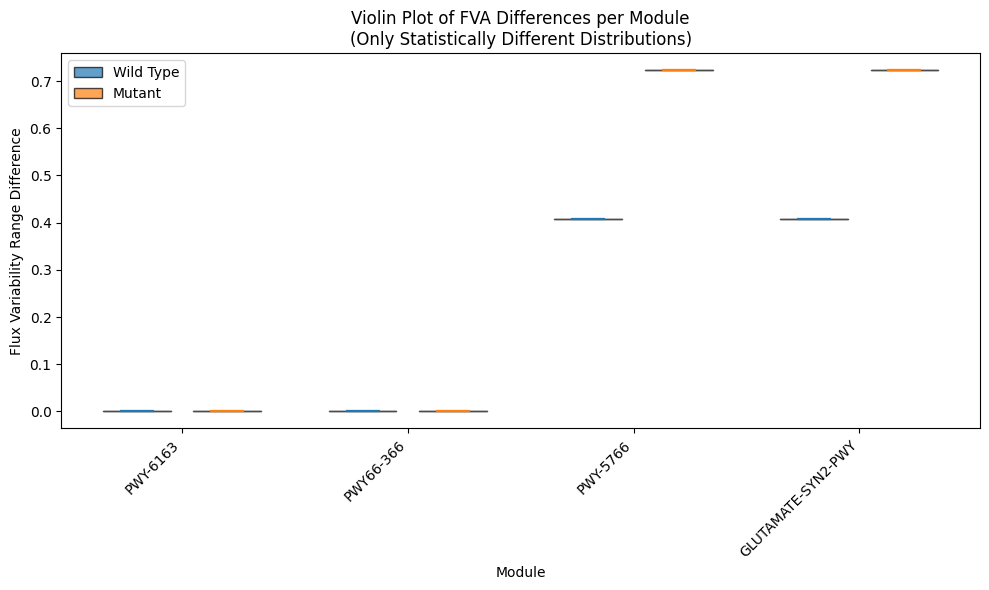

In [ ]:
#@markdown magnitude of FVA ranges
from scipy import stats
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_rel

mutant = "rxn01101_c0" #@param ["rxn01485_c0-181a7", "rxn01101_c0"]{allow-input: false}
approach = "FBA" #@param ["FBA", "lin_MOMA"] {allow-input: false}
carbon_source = 'Salicin' #@param ['D-Glucose', 'D-Lactose', 'Maltose', 'Sucrose', 'D-Fructose', 'L-Glutamic-acid', 'Salicin', 'LB/LB', 'LB/LB_wo_serine', 'LB/LB_wo_glycine', 'LB/LB_wo_threonine', 'LB/LB_plus_serine', 'LB/LB_plus_glycine', 'LB/LB_plus_threonine']
create_figure = "yes" #@param ["yes", "no"] {allow-input: false}
database = "metacyc" #@param ["kegg", "metacyc"] {allow-input: false}
pathway_completeness = "1.0" #@param ["0.7", "1.0"] {allow-input: false}

fva_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/FVA/" + CBA_mutant + "_" + approach + media_condition + ".json"

with open(fva_file, 'r') as f: plot_dict = json.load(f)[carbon_source]

if database == "kegg": db_reaction_module_dict, db_module_reaction_dict, db_module_description, db_annotations, db_reactions_in_model = kegg_reaction_module_dict, kegg_module_reaction_dict, kegg_module_description, kegg_annotations, kegg_reactions_in_model
elif database == "metacyc": db_reaction_module_dict, db_module_reaction_dict, db_module_description, db_annotations, db_reactions_in_model = metacyc_reaction_module_dict, metacyc_module_reaction_dict, metacyc_module_description, metacyc_annotations, metacyc_reactions_in_model

if create_figure == "yes":
  fva_difference_dict = dict()

  for rxn in model_0.reactions:
    wt_diff = plot_dict["wild_type"]["maximum"][rxn.id] - plot_dict["wild_type"]["minimum"][rxn.id]
    mutant_diff = plot_dict["mutant"]["maximum"][rxn.id] - plot_dict["mutant"]["minimum"][rxn.id]

    fva_difference_dict[rxn.id] = (wt_diff, mutant_diff)

  mod_fva_diff = defaultdict(list)
  for seed_rxn in fva_overlap_dict:
    for db_rxn in db_annotations.get(seed_rxn, []):
      for db_mod in db_reaction_module_dict.get(db_rxn, []):
        mod_fva_diff[db_mod].append(fva_difference_dict[seed_rxn])

  mod_fva_diff = {db_mod: list(map(list, zip(*mod_fva_diff[db_mod]))) for db_mod in mod_fva_diff}
  filtered_mod_fva_diff = dict()

  for mod in mod_fva_diff:

    total_rxns_in_module = len(db_module_reaction_dict[mod])
    those_present_in_model = len(db_module_reaction_dict[mod] & db_reactions_in_model)
    fraction_of_module_present = those_present_in_model/total_rxns_in_module

    # if the fluxes differ between the WT and the mutant
    if fraction_of_module_present >= float(pathway_completeness) and mod not in module_exclude_list:
      filtered_mod_fva_diff[mod] = mod_fva_diff[mod]

  statistically_diff_mods = dict()
  for mod, data in filtered_mod_fva_diff.items():
    #statistically_diff_mods[mod] = data
    wt_data, mutant_data = data  # each is a list of differences for the module
    # Only test modules with enough data points
    if len(wt_data) < 2 or len(mutant_data) < 2:
        continue
    #stat, p_value = mannwhitneyu(wt_data, mutant_data, alternative='two-sided')
    stat, p_value = ttest_rel(wt_data, mutant_data)
    if p_value < 0.05:
        statistically_diff_mods[mod] = data


  # Update our dictionary to the filtered modules.
  filtered_mod_fva_diff = statistically_diff_mods

  # Prepare data for plotting.
  modules = list(filtered_mod_fva_diff.keys())
  num_modules = len(modules)

  # For each module, extract the lists for wild_type and mutant.
  wild_data = [filtered_mod_fva_diff[mod][0] for mod in modules]
  mutant_data = [filtered_mod_fva_diff[mod][1] for mod in modules]

  # Set up x-axis positions for each module group.
  group_positions = list(range(1, num_modules + 1))
  offset = 0.2  # offset to separate the two violins per module.
  positions_wild = [pos - offset for pos in group_positions]
  positions_mutant = [pos + offset for pos in group_positions]

  # Create the figure.
  fig, ax = plt.subplots(figsize=(max(10, num_modules * 1.5), 6))

  # Create the violin plots.
  parts_wild = ax.violinplot(wild_data, positions=positions_wild, widths=0.3, showmeans=True)
  parts_mutant = ax.violinplot(mutant_data, positions=positions_mutant, widths=0.3, showmeans=True)

  # Set colors using the default color cycle.
  default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
  wild_color = default_colors[0]
  mutant_color = default_colors[1] if len(default_colors) > 1 else default_colors[0]

  for pc in parts_wild['bodies']:
      pc.set_facecolor(wild_color)
      pc.set_edgecolor('black')
      pc.set_alpha(0.7)
  for pc in parts_mutant['bodies']:
      pc.set_facecolor(mutant_color)
      pc.set_edgecolor('black')
      pc.set_alpha(0.7)

  # Set x-ticks to be at the center of each module group and label with module names.
  ax.set_xticks(group_positions)
  ax.set_xticklabels(modules, rotation=45, ha='right')
  ax.set_xlabel("Module")
  ax.set_ylabel("Flux Variability Range Difference")
  ax.set_title("Violin Plot of FVA Differences per Module\n(Only Statistically Different Distributions)")

  # Create custom legend entries.
  from matplotlib.patches import Patch
  legend_handles = [Patch(facecolor=wild_color, edgecolor='black', label='Wild Type', alpha=0.7),
                    Patch(facecolor=mutant_color, edgecolor='black', label='Mutant', alpha=0.7)]
  ax.legend(handles=legend_handles)

  plt.tight_layout()
  plt.show()


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


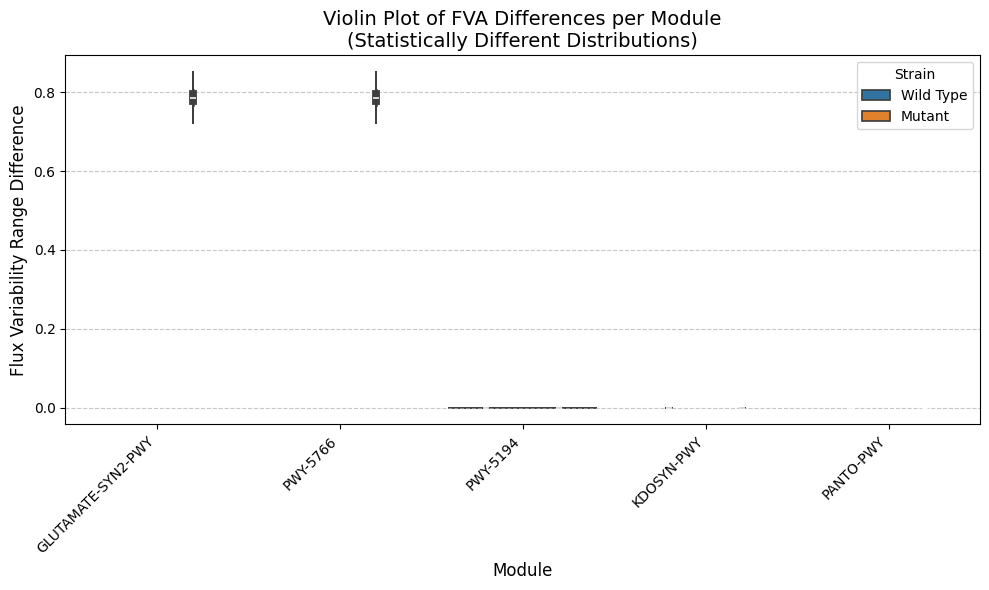

In [ ]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
from scipy.stats import ttest_rel

mutant = "rxn01101_c0" #@param ["rxn01485_c0-181a7", "rxn01101_c0"]{allow-input: false}
approach = "FBA" #@param ["FBA", "lin_MOMA"] {allow-input: false}
carbon_source = 'LB/LB_wo_glycine' #@param ['D-Glucose', 'D-Lactose', 'Maltose', 'Sucrose', 'D-Fructose', 'L-Glutamic-acid', 'Salicin', 'LB/LB', 'LB/LB_wo_serine', 'LB/LB_wo_glycine', 'LB/LB_wo_threonine', 'LB/LB_plus_serine', 'LB/LB_plus_glycine', 'LB/LB_plus_threonine']
create_figure = "yes" #@param ["yes", "no"] {allow-input: false}
database = "metacyc" #@param ["kegg", "metacyc"] {allow-input: false}
pathway_completeness = "1.0" #@param ["0.7", "1.0"] {allow-input: false}


# Load the FVA data
fva_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/FVA/" + CBA_mutant + "_" + approach + media_condition + ".json"
with open(fva_file, 'r') as f:
    plot_dict = json.load(f)[carbon_source]

# Set up database-specific variables.
if database == "kegg":
    db_reaction_module_dict = kegg_reaction_module_dict
    db_module_reaction_dict = kegg_module_reaction_dict
    db_module_description = kegg_module_description
    db_annotations = kegg_annotations
    db_reactions_in_model = kegg_reactions_in_model
elif database == "metacyc":
    db_reaction_module_dict = metacyc_reaction_module_dict
    db_module_reaction_dict = metacyc_module_reaction_dict
    db_module_description = metacyc_module_description
    db_annotations = metacyc_annotations
    db_reactions_in_model = metacyc_reactions_in_model

if create_figure == "yes":
    # Compute FVA range differences for each reaction.
    fva_difference_dict = {}
    for rxn in model_0.reactions:
        wt_diff = plot_dict["wild_type"]["maximum"][rxn.id] - plot_dict["wild_type"]["minimum"][rxn.id]
        mutant_diff = plot_dict["mutant"]["maximum"][rxn.id] - plot_dict["mutant"]["minimum"][rxn.id]
        fva_difference_dict[rxn.id] = (wt_diff, mutant_diff)

    # Group differences by module using the reaction annotations.
    mod_fva_diff = defaultdict(list)
    for seed_rxn in fva_overlap_dict:
        for db_rxn in db_annotations.get(seed_rxn, []):
            for db_mod in db_reaction_module_dict.get(db_rxn, []):
                mod_fva_diff[db_mod].append(fva_difference_dict[seed_rxn])

    # For each module, separate the WT and Mutant differences.
    mod_fva_diff = {db_mod: list(map(list, zip(*vals))) for db_mod, vals in mod_fva_diff.items()}

    # Filter modules based on pathway completeness and exclusion list.
    filtered_mod_fva_diff = {}
    for mod, data in mod_fva_diff.items():
        total_rxns_in_module = len(db_module_reaction_dict[mod])
        those_present_in_model = len(db_module_reaction_dict[mod] & db_reactions_in_model)
        fraction_of_module_present = those_present_in_model / total_rxns_in_module
        if fraction_of_module_present >= float(pathway_completeness) and mod not in module_exclude_list:
            filtered_mod_fva_diff[mod] = data

    # Further filter to keep only modules that are statistically different between WT and Mutant.
    statistically_diff_mods = {}
    for mod, data in filtered_mod_fva_diff.items():
        wt_data, mutant_data = data  # each is a list of differences for the module
        if len(wt_data) < 2 or len(mutant_data) < 2:
            continue
        stat, p_value = ttest_rel(wt_data, mutant_data)
        if p_value < 0.05:
            statistically_diff_mods[mod] = data

    # Use only statistically significant modules.
    filtered_mod_fva_diff = statistically_diff_mods

    # Organize the data into a long-form DataFrame.
    rows = []
    for mod, data in filtered_mod_fva_diff.items():
        wt_data, mutant_data = data
        for val in wt_data:
            rows.append({"Module": mod, "Strain": "Wild Type", "FVA_Difference": val})
        for val in mutant_data:
            rows.append({"Module": mod, "Strain": "Mutant", "FVA_Difference": val})
    fva_df = pd.DataFrame(rows)

    # Optional: sort modules by the median FVA difference in the mutant.
    sorted_modules = (
        fva_df[fva_df["Strain"]=="Mutant"]
        .groupby("Module")["FVA_Difference"]
        .median()
        .sort_values(ascending=False)
        .index
    )
    fva_df["Module"] = pd.Categorical(fva_df["Module"], categories=sorted_modules, ordered=True)

    # Create the violin plot with both WT and Mutant data.
    plt.figure(figsize=(max(10, len(sorted_modules) * 1.5), 6))
    ax = sns.violinplot(data=fva_df, x="Module", y="FVA_Difference", hue="Strain", split=False)
    ax.set_xlabel("Module", fontsize=12)
    ax.set_ylabel("Flux Variability Range Difference", fontsize=12)
    ax.set_title("Violin Plot of FVA Differences per Module\n(Statistically Different Distributions)", fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()



In [ ]:
#@markdown Violin plot showing shadow prices for metabolites in different pathway. (Can choose carbon source)

mutant = "rxn01101_c0" #@param ["rxn01485_c0-181a7", "rxn01101_c0"]{allow-input: false}
mutant_modeling_approach = "MOMA" #@param ["FBA", "MOMA_linear", "MOMA"] {allow-input: false}
database = "kegg" #@param ["kegg", "metacyc"] {allow-input: false}
strain = "Mutant" #@param ["Mutant", "Wild Type", "both"] {allow-input: false}
carbon_source = 'LB/LB_wo_glycine' #@param ['D-Glucose', 'D-Lactose', 'Maltose', 'Sucrose', 'D-Fructose', 'L-Glutamic-acid', 'Salicin', 'LB/LB', 'LB/LB_wo_serine', 'LB/LB_wo_glycine', 'LB/LB_wo_threonine', 'LB/LB_plus_serine', 'LB/LB_plus_glycine', 'LB/LB_plus_threonine']

create_figure = "yes" #@param ["yes", "no"] {allow-input: false}

approach_map = {"FBA": 1, "MOMA_linear": 2, "MOMA": 3}

############################################################
shadow_prices_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/shadow_prices/" + CBA_mutant + media_condition + ".json"

if database == "kegg": db_reaction_module_dict, db_module_reaction_dict, db_module_description, db_annotations, db_reactions_in_model = kegg_reaction_module_dict, kegg_module_reaction_dict, kegg_module_description, kegg_annotations, kegg_reactions_in_model
elif database == "metacyc": db_reaction_module_dict, db_module_reaction_dict, db_module_description, db_annotations, db_reactions_in_model = metacyc_reaction_module_dict, metacyc_module_reaction_dict, metacyc_module_description, metacyc_annotations, metacyc_reactions_in_model

module_exclude_list = ["M00365", "M00366", "M00367", "M00868", "M00580", "M00158", "M00160", "PWY-7851", "COA-PWY-1"]

module_shadowP_dict = defaultdict(list)

with open(shadow_prices_file, 'r') as f:
  plot_dict = json.load(f)

shadow_prices = plot_dict[carbon_source]
met_list = plot_dict["all_metabolites"]
met_rxn_dict = {item: [rxn.id for rxn in model_0.metabolites.get_by_id(item).reactions] for item in met_list}

for met_id in met_rxn_dict:
  if met_id in all_mets_produced:
    met_id_index = met_list.index(met_id)
    shadow_price_in_wt = shadow_prices[met_id_index][0]
    shadow_price_in_mu = shadow_prices[met_id_index][approach_map[mutant_modeling_approach]]

    for seed_rxn in met_rxn_dict[met_id]:
      if seed_rxn in db_annotations:
        for db_rxn in db_annotations[seed_rxn]:
          if db_rxn in db_reaction_module_dict:
            db_mods = db_reaction_module_dict[db_rxn]

            for db_mod in db_mods:
              #filter for only modules with reactions that are all present in organism
              fraction_of_module_present = len(db_module_reaction_dict[db_mod] & db_reactions_in_model)/len(db_module_reaction_dict[db_mod])
              if fraction_of_module_present >= 1 and db_mod not in module_exclude_list:
                module_shadowP_dict[db_mod].append([shadow_price_in_wt, shadow_price_in_mu])


##############################
# organize data for figure
data_array = []
for key, values in module_shadowP_dict.items():
    for value in values:
        data_array.append({"Pathway": key, "Strain": "Wild Type", "Shadow Price": value[0]})
        data_array.append({"Pathway": key, "Strain": "Mutant", "Shadow Price": value[1]})

shadow_price_df = pd.DataFrame(data_array)

# Sort the pathways based on the mean shadow price in the mutant
# a positive shadow price in the mutant indicates that a metabolite is limiting for the objective

sorted_pathways = (
    shadow_price_df[shadow_price_df["Strain"] == strain if strain!="both" else shadow_price_df["Strain"] == "Mutant" ]
    .groupby("Pathway")["Shadow Price"]
    .max()
    .sort_values(ascending=False)
    .index
)

# Limit to the first i categories
top_categories = sorted_pathways[:]
shadow_price_df = shadow_price_df[shadow_price_df["Pathway"].isin(top_categories)]
shadow_price_df["Pathway"] = pd.Categorical(shadow_price_df["Pathway"], categories=top_categories, ordered=True)

strain_df = shadow_price_df[(shadow_price_df["Strain"] == strain) & (shadow_price_df["Pathway"].isin(top_categories))]
strain_df.loc[:, "Pathway"] = pd.Categorical(strain_df["Pathway"], categories=top_categories, ordered=True)


# Step 4: Create the violin plot
plt.figure(figsize=(15, 8))

if strain ==  "Mutant" or strain ==  "Wild Type":
  ax = sns.violinplot(data=strain_df, x="Pathway", y="Shadow Price", color="orange",
                      linewidth=1.5, density_norm="width")
  plt.xlabel("Pathway", fontsize=12)
  plt.ylabel("Shadow Price", fontsize=12)

if strain == "both":
  ax = sns.violinplot(data=shadow_price_df, x="Pathway", y="Shadow Price", hue="Strain", split=False)
  plt.xlabel("Pathway", fontsize=12)
  plt.ylabel("Shadow Price", fontsize=12)
  plt.legend(title="Strain")

#plt.legend(title="Strain")


tick_labels = [abbreviate_pathways(db_module_description[pathway].split(",")[0]) + " ["+pathway+"] " for pathway in top_categories]

ax.set_xticks(range(len(top_categories)))
ax.set_xticklabels(tick_labels, rotation=90, ha="right")

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()





#### Metabolite Production (and consumption) in Mutant vs WT

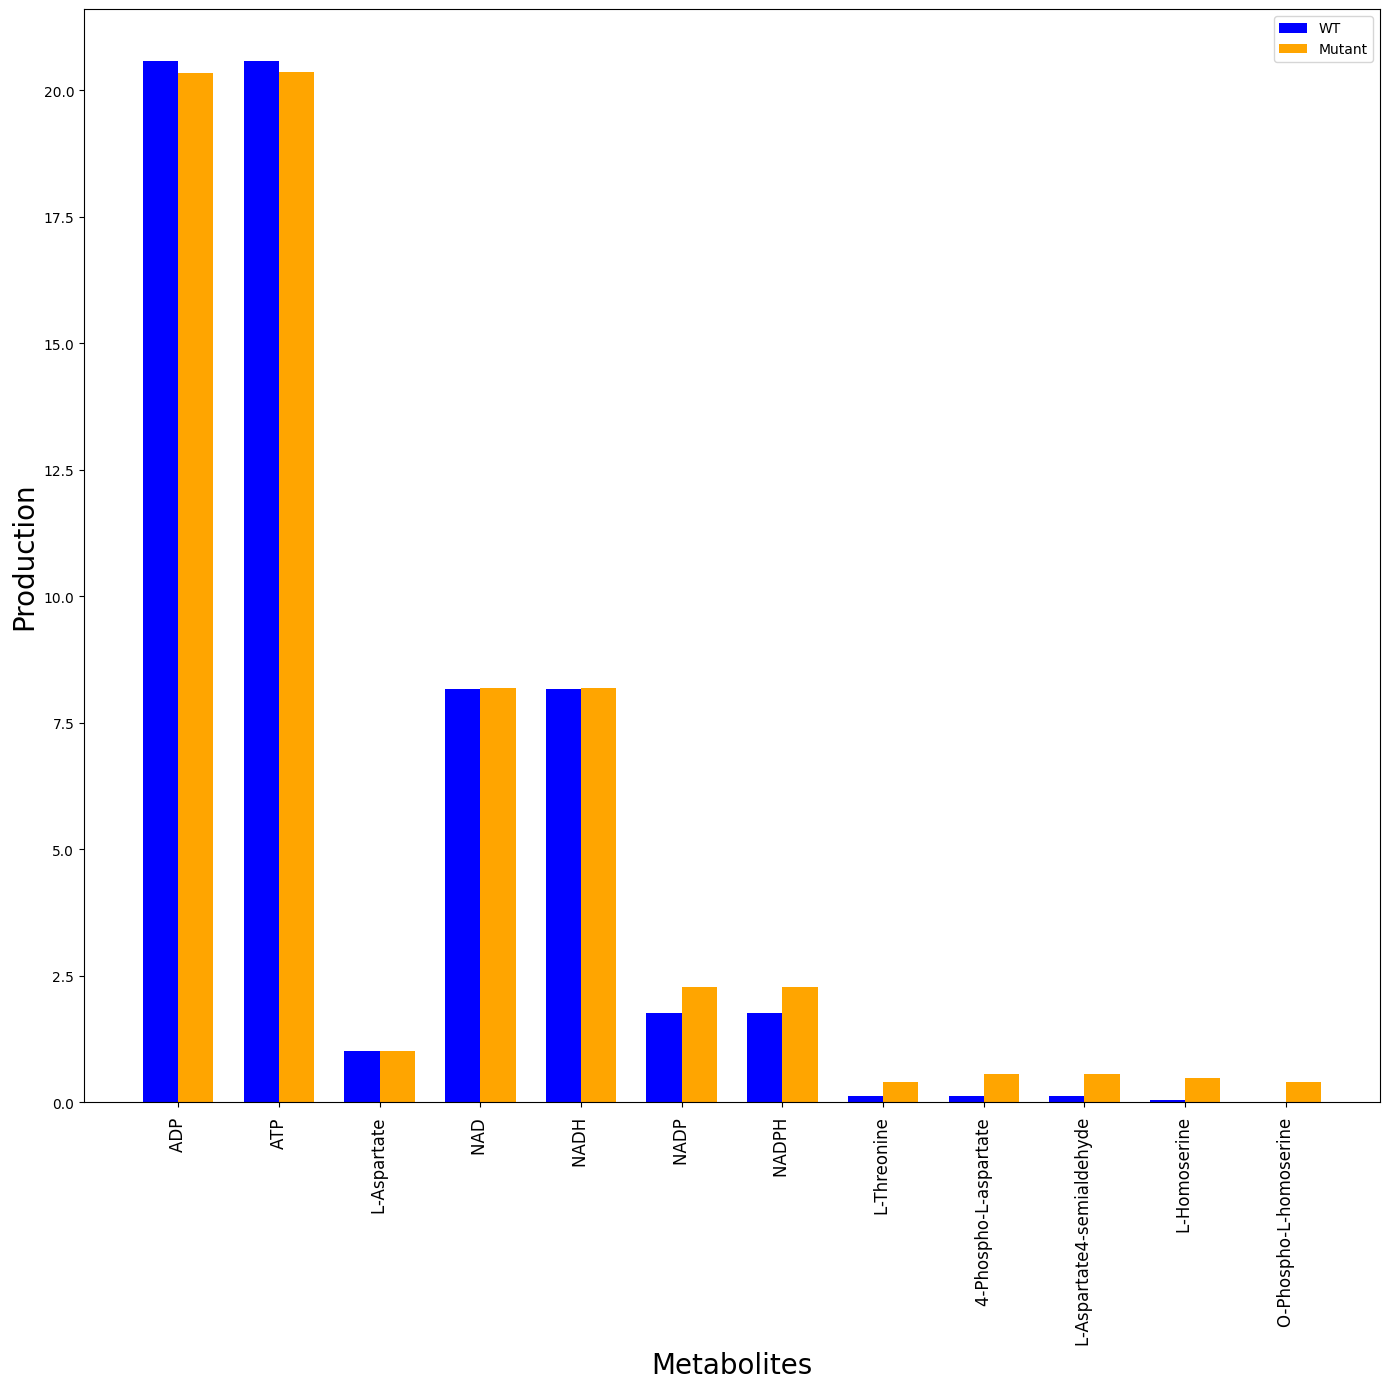

In [ ]:


#@markdown Bar chart the ratio of metabolite production in mutant vs wild-type

mutant = "rxn01101_c0" #@param ["rxn01485_c0-181a7", "rxn01101_c0"]{allow-input: false}
mutant_modeling_approach = "MOMA" #@param ["FBA", "MOMA_linear", "MOMA"] {allow-input: false}
pathway = "Threonine Biosynethesis" #@param ["Coenzyme A Biosynthesis", "Fatty Acid Biosynthesis", "Cysteine Biosynthesis", "Serine Biosynthesis", "Threonine Biosynethesis", "all"]
carbon_source = 'LB/LB_wo_glycine' #@param ['D-Glucose', 'D-Lactose', 'Maltose', 'Sucrose', 'D-Fructose', 'L-Glutamic-acid', 'Salicin', 'LB/LB', 'LB/LB_wo_serine', 'LB/LB_wo_glycine', 'LB/LB_wo_threonine', 'LB/LB_plus_serine', 'LB/LB_plus_glycine', 'LB/LB_plus_threonine']
create_figure = "yes" #@param ["yes", "no"] {allow-input: false}

approach_map = {"FBA": 1, "MOMA_linear": 2, "MOMA": 3}

metabolite_production_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/metabolite_production/" + CBA_mutant + media_condition + ".json"

with open(metabolite_production_file, 'r') as f:
  plot_dict = json.load(f)
met_list = plot_dict["all_metabolites"]

#obtain a list of all metabolites that are produced by the model under all tested conditions
media_list = defined_mets + ["LB/LB"] + ["LB/LB_wo_serine", "LB/LB_wo_glycine", "LB/LB_wo_threonine", "LB/LB_plus_serine", "LB/LB_plus_glycine", "LB/LB_plus_threonine"]
all_mets_produced = set()
for met_id in met_list:
  met_index = met_list.index(met_id)
  for media in media_list:
    production_in_wt = plot_dict[media][met_index][0]
    production_in_mu = plot_dict[media][met_index][approach_map[mutant_modeling_approach]]
    if max(production_in_wt, production_in_mu) > 0:
      all_mets_produced.add(met_id)

metabolite_production = plot_dict[carbon_source]
met_list = plot_dict["all_metabolites"]

pathway_id_dict = {"Coenzyme A Biosynthesis": "M00120",
                  "Fatty Acid Biosynthesis": "M00082",
                  "Cysteine Biosynthesis": "M00021",
                  "Serine Biosynthesis": "M00020",
                  "Threonine Biosynethesis":"M00018"}
if pathway != "all":
  rxns_in_pathway = [key for key, value in kegg_annotations.items() if any(x in value for x in list(kegg_module_reaction_dict[pathway_id_dict[pathway]]))]
  mets_in_pathway = [j.id for j in list(set.union(*list(set(model_0.reactions.get_by_id(i).metabolites.keys()) for i in rxns_in_pathway))) if "C" in j.elements]
else: mets_in_pathway = all_mets_produced

#a figure showing the metabolite production ratios in the mutant relative to the wild type
if create_figure == "yes":

  plot_sub_dict = defaultdict(list)
  for i in range(len(met_list)):
    met_id = met_list[i]
    if (model_0.metabolites.get_by_id(met_id).compartment == "c" or model_0.metabolites.get_by_id(met_id).compartment == "c0") and (met_id in mets_in_pathway) and ('C' in model_0.metabolites.get_by_id(met_id).elements): #in list(key_metabolites.values()):
      production_in_wt = metabolite_production[i][0]
      production_in_mu = metabolite_production[i][approach_map[mutant_modeling_approach]]
      log_production_ratio = np.log(calculate_ratio(production_in_mu, production_in_wt))
      plot_sub_dict[met_id] = [production_in_wt, production_in_mu, log_production_ratio]
  plot_sub_dict = dict(sorted(plot_sub_dict.items(), key=lambda item: item[1][2], reverse=False))

  # Get the first 10 items
  top_x_metabolites = list(plot_sub_dict.items())[:50]

  # Extract keys, wt values, and mutant values
  met_names = [abbreviate_pathways(model_0.metabolites.get_by_id(item[0]).name.replace("[c0]","")) for item in top_x_metabolites]
  wt_values = [item[1][0] for item in top_x_metabolites]
  mutant_values = [item[1][1] for item in top_x_metabolites]
  log_ratio_values = [item[1][2] for item in top_x_metabolites]

  #creating figure
  plt.figure(figsize=(14, 14))

  x = range(len(met_names))  # Positions for the bars
  width = 0.35  # Width of the bars

  plt.bar(x, wt_values, width, label='WT', color='blue')
  plt.bar([i + width for i in x], mutant_values, width, label='Mutant', color='orange')
  #plt.bar(x, log_ratio_values, width, color='orange')

  #plt.bar([i + width for i in x], mutant_values, width, label='Mutant', color='orange')

  # Add labels and legend
  plt.xlabel('Metabolites', fontsize=20)
  plt.ylabel('Production', fontsize=20)
  #plt.xticks(x, met_names, rotation=90, fontsize = 12)  # Center the labels
  plt.xticks([i + width / 2 for i in x], met_names, rotation=90, fontsize = 12)  # Center the labels
  plt.yticks(rotation=0, fontsize =10)
  plt.legend()

  # Show the plot
  plt.tight_layout()
  plt.show()



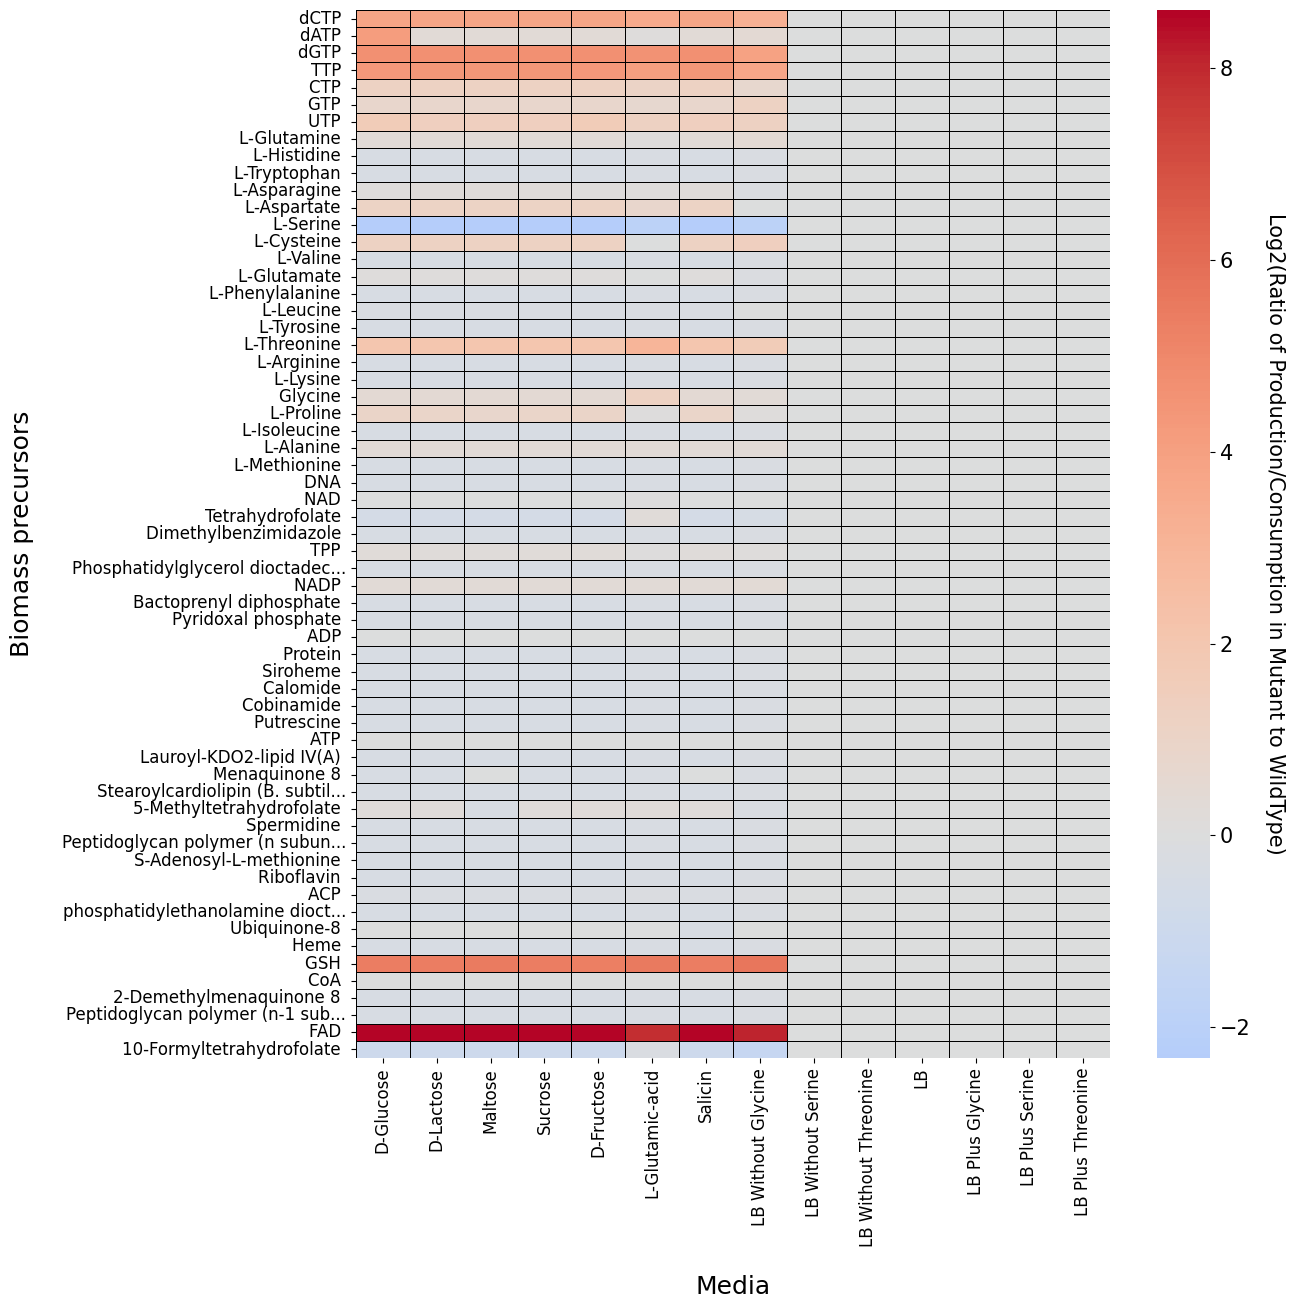

In [ ]:
#@markdown Heatmap showing the log ratio of metabolite production in mutant vs wild-type for metabolites in the biomass function.

KO_mutant = "rxn01101_c0" #@param ["rxn01101_c0"]{allow-input: false}

create_figure = "yes" #@param ["yes", "no"] {allow-input: false}
mutant_modeling_approach = "MOMA" #@param ["FBA", "MOMA_linear", "MOMA"] {allow-input: false}
metabolite_production_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/metabolite_production/" + CBA_mutant + media_condition + ".json"


with open(metabolite_production_file, 'r') as f:
  plot_dict = json.load(f)
met_list = plot_dict["all_metabolites"]

if create_figure == "yes":
  media_list = defined_mets + ["LB/LB_wo_glycine"] + ["LB/LB_wo_serine", "LB/LB_wo_threonine", "LB/LB", "LB/LB_plus_glycine", "LB/LB_plus_serine", "LB/LB_plus_threonine"]

  if "ecoli" not in model_name:
    unique_to_DNA = DNA_precursors - mRNA_precursors - prot_precursors - biomass_precursors
    unique_to_RNA = mRNA_precursors - DNA_precursors - prot_precursors - biomass_precursors
    unique_to_protein = prot_precursors - DNA_precursors - mRNA_precursors - biomass_precursors
    others = set(all_precursors) - unique_to_DNA - unique_to_RNA - unique_to_protein - {"cpd11416_c0"}
    precursor_list = list(unique_to_DNA) + list(unique_to_RNA) + list(unique_to_protein) + list(others) + ["cpd11416_c0"]
  else: precursor_list = list(all_precursors)

  filtered_precursors =[]
  data = []

  for my_biomass_met in precursor_list:
    log_ratio_list = []
    ratio_list = []
    met_index = met_list.index(my_biomass_met)

    for media in media_list:
      metabolite_production = plot_dict[media]
      production_in_wt = metabolite_production[met_index][0]
      production_in_mu = metabolite_production[met_index][approach_map[mutant_modeling_approach]]

      production_ratio = calculate_ratio(production_in_mu, production_in_wt)
      log_production_ratio = np.log2(production_ratio)

      ratio_list.append(production_ratio)
      log_ratio_list.append(log_production_ratio)

    #if not all(0.99 < element < 1.01 for element in ratio_list) and "C" in model_0.metabolites.get_by_id(my_biomass_met).elements and (my_biomass_met in all_mets_produced): #if the production capacity in wt and mutant differ by more than 1%
    #if not all(abs(element)<np.log2(1.5) for element in log_ratio_list) and "C" in model_0.metabolites.get_by_id(my_biomass_met).elements and (my_biomass_met in all_mets_produced):
    if not all(abs(element)== 1 for element in ratio_list) and "C" in model_0.metabolites.get_by_id(my_biomass_met).elements and (my_biomass_met in all_mets_produced):
      filtered_precursors.append(my_biomass_met)
      data.append(log_ratio_list)

  data_array = np.array(data)

  col_names = [(media_list_map[item] if item in media_list_map else item) for item in media_list]
  rows = filtered_precursors
  row_names = [abbreviate_pathways(model_0.metabolites.get_by_id(i).name.replace("[c0]","")) for i in filtered_precursors]


  # Creating figure
  plt.figure(figsize=(14, 14))

  ax = sns.heatmap(data_array, annot=False, fmt=".2f", cmap='coolwarm', center=0, cbar=True, linewidths=.5,
                   linecolor='black', xticklabels=col_names, yticklabels=row_names, annot_kws={"size": 12})

  #save_array_as_tsv(data_array, col_names, row_names, "biomass/precursor_production_capacity.tsv")

  plt.xticks(rotation=90, fontsize = 12)#, fontweight='bold')
  plt.yticks(rotation=0, fontsize = 12)#, fontweight='bold')
  plt.xlabel("Media", fontsize=18, labelpad=20)#, fontweight='bold')
  plt.ylabel("Biomass precursors", fontsize=18, labelpad=20)#, fontweight='bold')
  #plt.title("Biomass Precursor Production in Wild Type vs Mutant\n[" + mutant_dict[KO_mutant]+"]", fontsize=18, pad=30)

  # Adjust color bar position and size
  cbar = ax.collections[0].colorbar
  cbar.ax.tick_params(labelsize=15)
  cbar.ax.set_ylabel('Log2(Ratio of Production/Consumption in Mutant to WildType)', rotation=270, fontsize=15, labelpad=25)

  fig = plt.gcf()
  fig.tight_layout(pad=4.0)
  #figure_name = "figures/production_capacity_ratio/" + KO_mutant + model_name.replace("/","") + media_condition + ".svg"
  #plt.savefig(figure_name, dpi=500, bbox_inches="tight", format="svg")

  plt.show()


#### Metabolite Perturbation

<ipython-input-34-59cd7b0a8567>:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


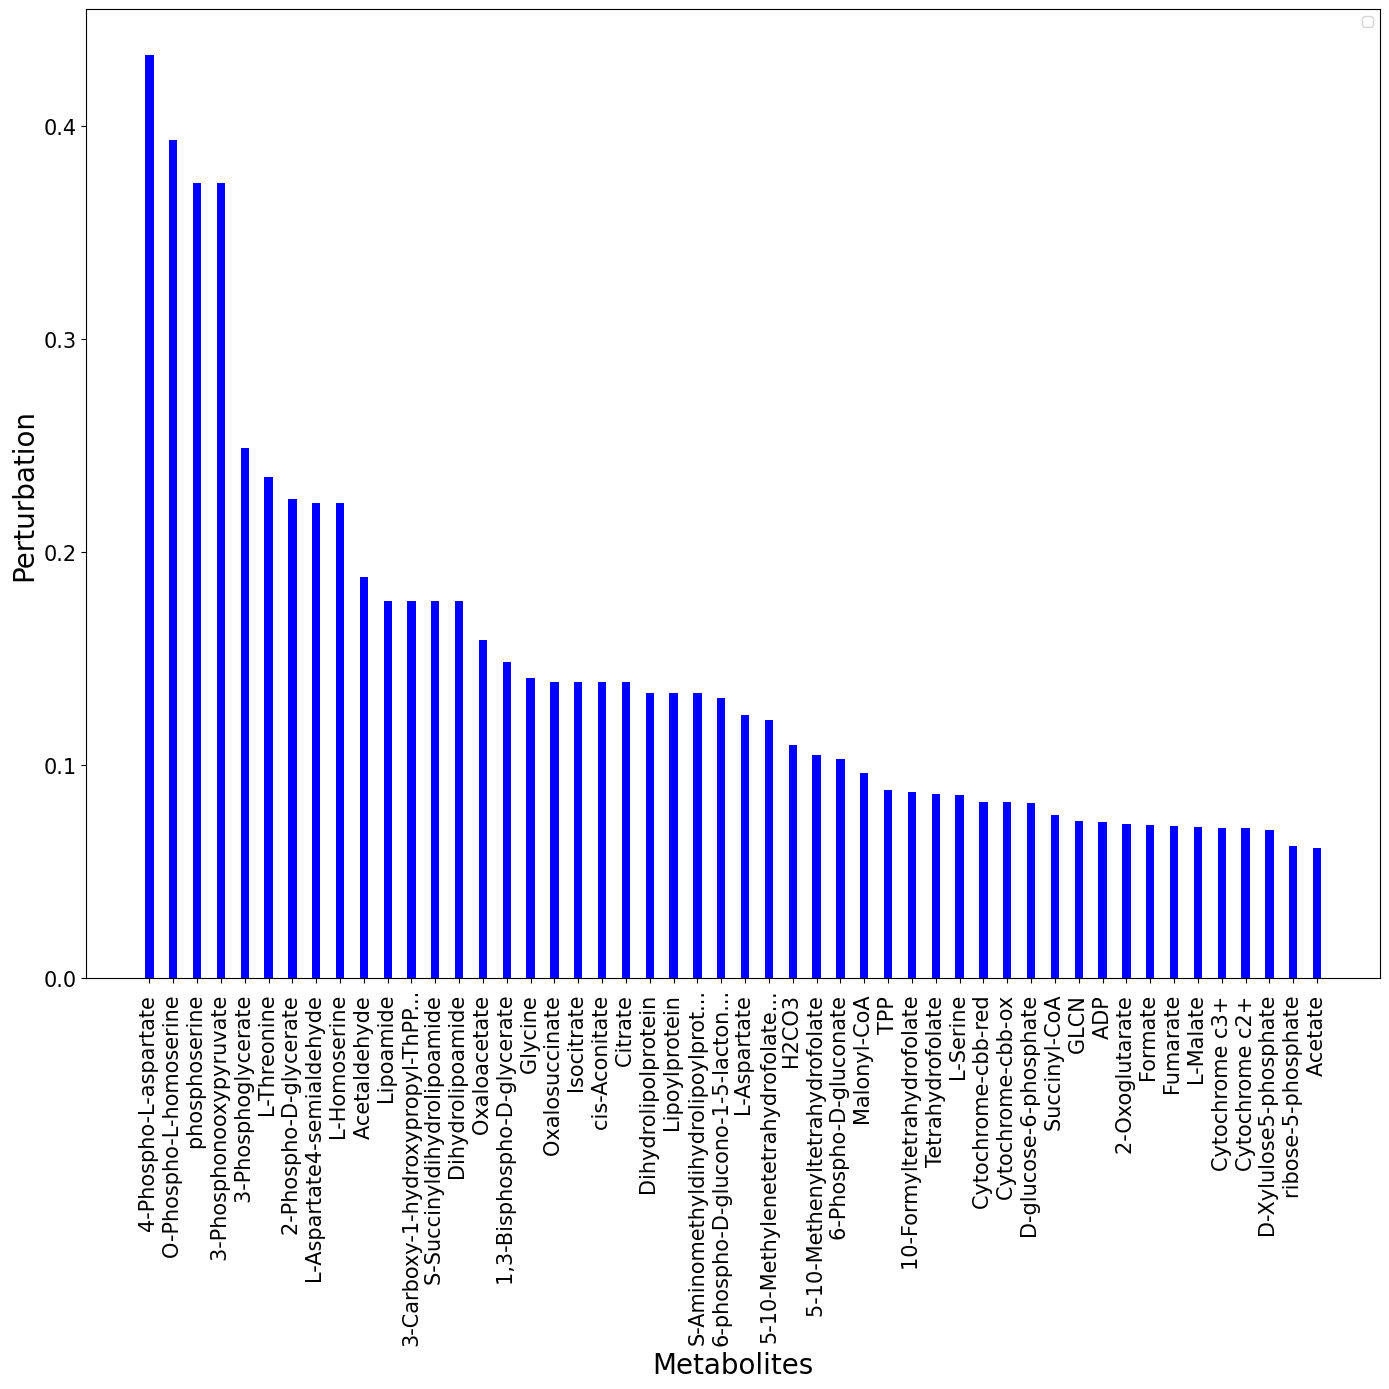

In [ ]:
#@markdown Bar chart the ratio of metabolite production in mutant vs wild-type

mutant = "rxn01101_c0" #@param ["rxn01485_c0-181a7", "rxn01101_c0"]{allow-input: false}
mutant_modeling_approach = "MOMA" #@param ["FBA", "MOMA_linear", "MOMA"] {allow-input: false}
pathway = "all" #@param ["Coenzyme A Biosynthesis", "Fatty Acid Biosynthesis", "Cysteine Biosynthesis", "Serine Biosynthesis", "Threonine Biosynethesis", "all"]
carbon_source = 'LB/LB_wo_glycine' #@param ['D-Glucose', 'D-Lactose', 'Maltose', 'Sucrose', 'D-Fructose', 'L-Glutamic-acid', 'Salicin', 'LB/LB', 'LB/LB_wo_serine', 'LB/LB_wo_glycine', 'LB/LB_wo_threonine', 'LB/LB_plus_serine', 'LB/LB_plus_glycine', 'LB/LB_plus_threonine']
create_figure = "yes" #@param ["yes", "no"] {allow-input: false}

approach_map = {"FBA": 0, "MOMA_linear": 1, "MOMA": 2}

metabolite_perturbation_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/metabolite_perturbation/" + CBA_mutant + media_condition + ".json"

with open(metabolite_perturbation_file, 'r') as f:
  plot_dict = json.load(f)
met_list = plot_dict["all_metabolites"]

#obtain a list of all metabolites that are produced by the model under all tested conditions
media_list = defined_mets + ["LB/LB"] + ["LB/LB_wo_serine", "LB/LB_wo_glycine", "LB/LB_wo_threonine", "LB/LB_plus_serine", "LB/LB_plus_glycine", "LB/LB_plus_threonine"]

metabolite_perturbation = plot_dict[carbon_source]
met_list = plot_dict["all_metabolites"]

pathway_id_dict = {"Coenzyme A Biosynthesis": "M00120",
                  "Fatty Acid Biosynthesis": "M00082",
                  "Cysteine Biosynthesis": "M00021",
                  "Serine Biosynthesis": "M00020",
                  "Threonine Biosynethesis":"M00018"}

if pathway != "all":
  rxns_in_pathway = [key for key, value in kegg_annotations.items() if any(x in value for x in list(kegg_module_reaction_dict[pathway_id_dict[pathway]]))]
  mets_in_pathway = [j.id for j in list(set.union(*list(set(model_0.reactions.get_by_id(i).metabolites.keys()) for i in rxns_in_pathway))) if "C" in j.elements]
else: mets_in_pathway = all_mets_produced

#a figure showing the metabolite production ratios in the mutant relative to the wild type
if create_figure == "yes":

  plot_sub_dict = defaultdict(list)
  for i in range(len(met_list)):
    met_id = met_list[i]
    if (model_0.metabolites.get_by_id(met_id).compartment == "c" or model_0.metabolites.get_by_id(met_id).compartment == "c0") and (met_id in mets_in_pathway) and ('C' in model_0.metabolites.get_by_id(met_id).elements): #in list(key_metabolites.values()):
      met_perturbation = metabolite_perturbation[i][approach_map[mutant_modeling_approach]]
      plot_sub_dict[met_id] = met_perturbation
  plot_sub_dict = dict(sorted(plot_sub_dict.items(), key=lambda item: item[1], reverse=True))

  # Get the first 10 items
  top_x_metabolites = list(plot_sub_dict.items())[:50]

  # Extract keys, wt values, and mutant values
  met_names = [abbreviate_pathways(model_0.metabolites.get_by_id(item[0]).name.replace("[c0]","")) for item in top_x_metabolites]
  perturbation_values = [item[1] for item in top_x_metabolites]

  #creating figure
  plt.figure(figsize=(14, 14))

  x = range(len(met_names))  # Positions for the bars
  width = 0.35  # Width of the bars

  plt.bar(x, perturbation_values, width, color='blue')

  # Add labels and legend
  plt.xlabel('Metabolites', fontsize=20)
  plt.ylabel('Perturbation', fontsize=20)
  #plt.xticks(x, met_names, rotation=90, fontsize = 12)  # Center the labels
  plt.xticks(x, met_names, rotation=90, fontsize = 15)
  plt.yticks(rotation=0, fontsize =15)
  plt.legend()

  # Show the plot
  plt.tight_layout()
  plt.show()



#### Shadow Prices in Mutant

<ipython-input-80-f3250c356dd6>:68: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


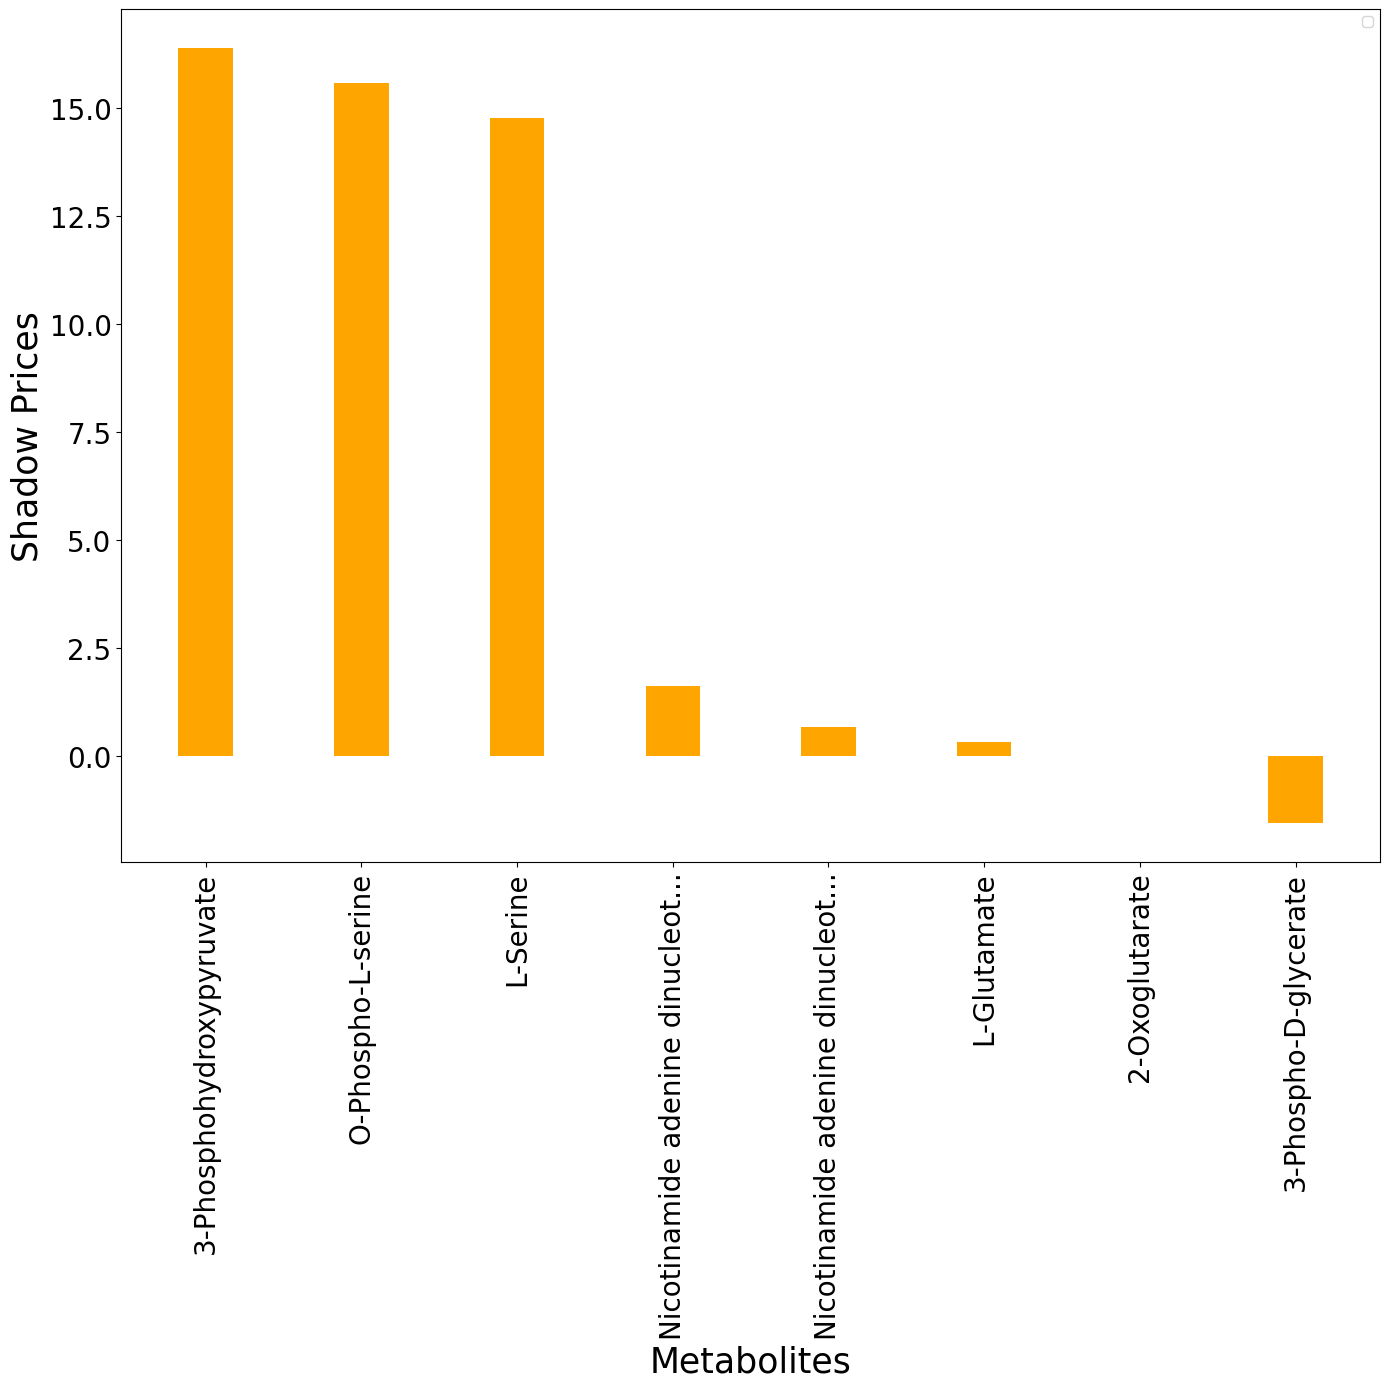

In [ ]:

#@markdown Bar chart showing shadow prices ranked by how positive they are in the mutant (Can choose carbon source)

mutant = "rxn01101_c0" #@param ["rxn01485_c0-181a7", "rxn01101_c0"]{allow-input: false}
mutant_modeling_approach = "MOMA" #@param ["FBA", "MOMA_linear", "MOMA"] {allow-input: false}
pathway = "Serine Biosynthesis" #@param ["Coenzyme A Biosynthesis", "Fatty Acid Biosynthesis", "Cysteine Biosynthesis", "Serine Biosynthesis", "Threonine Biosynethesis", "all"]
carbon_source = 'LB/LB_wo_glycine' #@param ['D-Glucose', 'D-Lactose', 'Maltose', 'Sucrose', 'D-Fructose', 'L-Glutamic-acid', 'Salicin', 'LB/LB', 'LB/LB_wo_serine', 'LB/LB_wo_glycine', 'LB/LB_wo_threonine', 'LB/LB_plus_serine', 'LB/LB_plus_glycine', 'LB/LB_plus_threonine']

create_figure = "yes" #@param ["yes", "no"] {allow-input: false}
approach_map = {"FBA": 1, "MOMA_linear": 2, "MOMA": 3}
pathway_id_dict = {"Coenzyme A Biosynthesis": "M00120",
                  "Fatty Acid Biosynthesis": "M00082",
                  "Cysteine Biosynthesis": "M00021",
                  "Serine Biosynthesis": "M00020",
                  "Threonine Biosynethesis":"M00018"}

if pathway != "all":
  rxns_in_pathway = [key for key, value in kegg_annotations.items() if any(x in value for x in list(kegg_module_reaction_dict[pathway_id_dict[pathway]]))]
  mets_in_pathway = [j.id for j in list(set.union(*list(set(model_0.reactions.get_by_id(i).metabolites.keys()) for i in rxns_in_pathway))) if "C" in j.elements]
else: mets_in_pathway = all_mets_produced

shadow_prices_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/shadow_prices/" + CBA_mutant + media_condition + ".json"

with open(shadow_prices_file, 'r') as f:
  plot_dict = json.load(f)

shadow_prices = plot_dict[carbon_source]
met_list = plot_dict["all_metabolites"]


if create_figure == "yes":

  plot_sub_dict = defaultdict(list)
  for i in range(len(met_list)):
    met_id = met_list[i]
    if (model_0.metabolites.get_by_id(met_id).compartment == "c" or model_0.metabolites.get_by_id(met_id).compartment == "c0") and (met_id in mets_in_pathway) and ('C' in model_0.metabolites.get_by_id(met_id).elements):# list(key_metabolites.values()) :
      shadow_price_in_wt = shadow_prices[i][0]
      shadow_price_in_mu = shadow_prices[i][approach_map[mutant_modeling_approach]]
      #if shadow_price_in_wt < 0 and shadow_price_in_mu > 0:
      plot_sub_dict[met_id] = [shadow_price_in_wt, shadow_price_in_mu]
  plot_sub_dict = dict(sorted(plot_sub_dict.items(), key=lambda item: item[1][1], reverse=True))


  # Get the first 10 items
  top_x_metabolites = list(plot_sub_dict.items())[:50]

  # Extract keys, wt values, and mutant values
  met_names = [abbreviate_pathways(model_0.metabolites.get_by_id(item[0]).name.replace("[c0]","")) for item in top_x_metabolites]
  wt_values = [item[1][0] for item in top_x_metabolites]
  mutant_values = [item[1][1] for item in top_x_metabolites]

  #creating figure
  plt.figure(figsize=(14, 14))

  x = range(len(met_names))  # Positions for the bars
  width = 0.35  # Width of the bars

  #plt.bar(x, wt_values, width, label='WT', color='blue')
  plt.bar(x, mutant_values, width, color='orange')

  #plt.bar([i + width for i in x], mutant_values, width, label='Mutant', color='orange')

  # Add labels and legend
  plt.xlabel('Metabolites', fontsize=25)
  plt.ylabel('Shadow Prices', fontsize=25)
  plt.xticks(x, met_names, rotation=90, fontsize = 20)  # Center the labels
  #plt.xticks([i + width / 2 for i in x], met_names, rotation=90, fontsize = 12)  # Center the labels
  plt.yticks(rotation=0, fontsize =20)
  plt.legend()

  # Show the plot
  plt.tight_layout()
  plt.show()

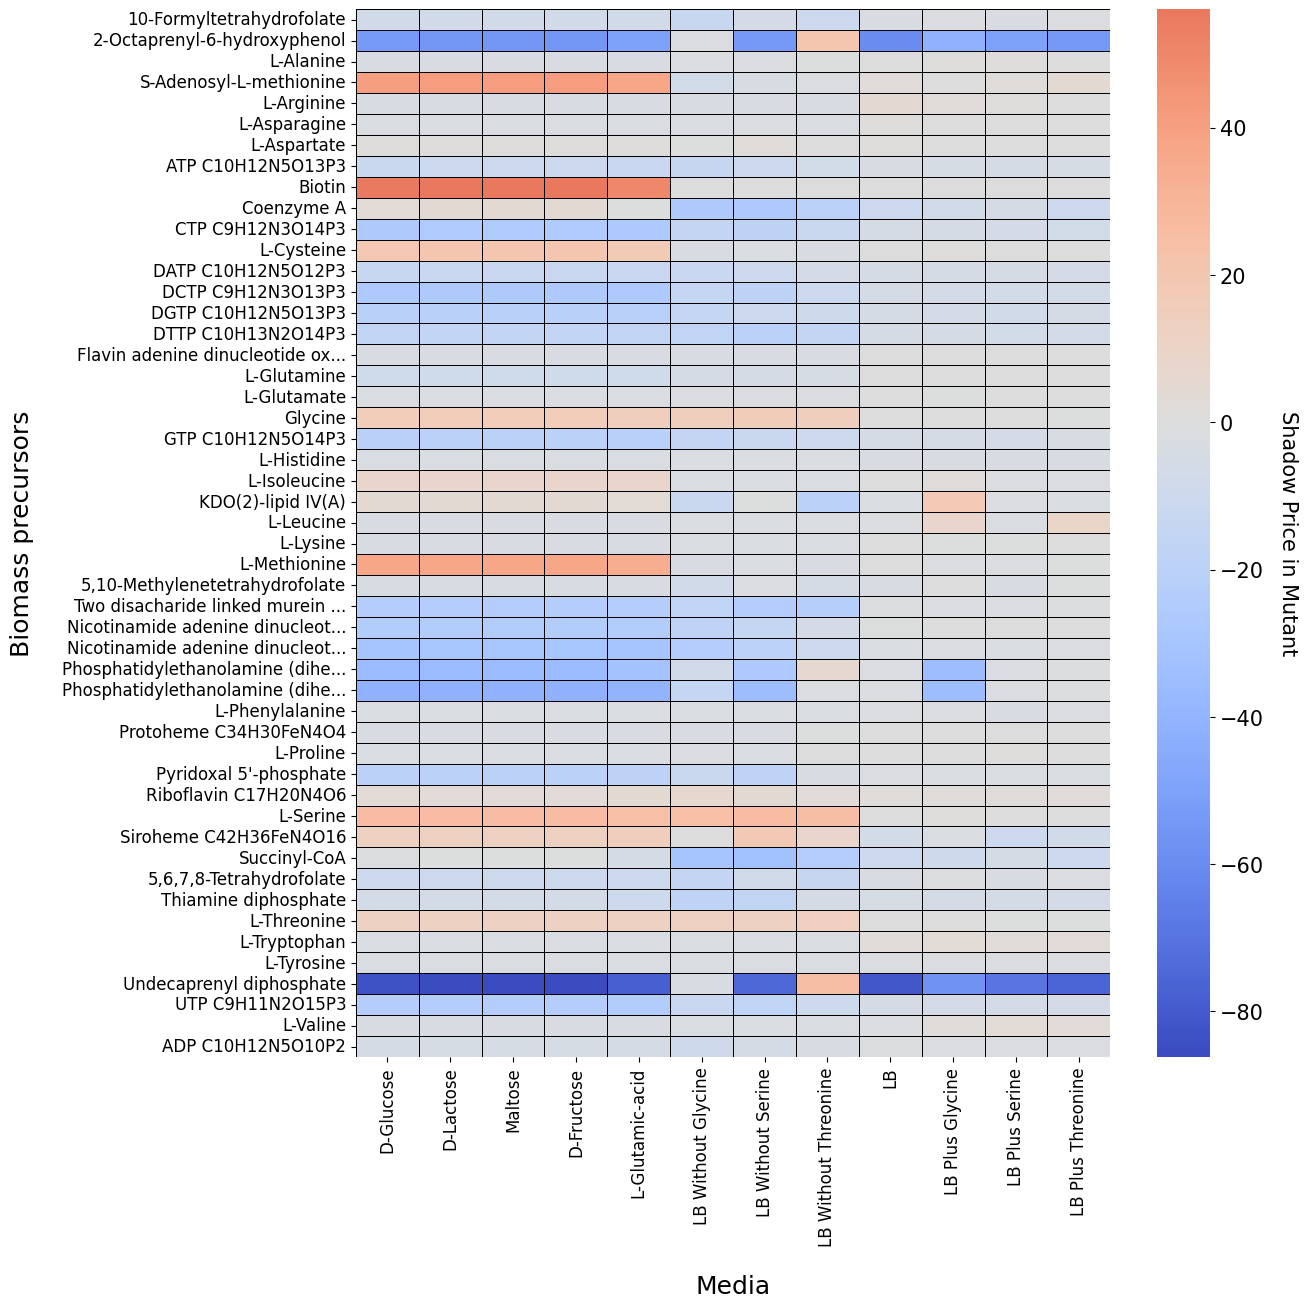

In [ ]:
#@markdown Heatmap showing shadow prices in mutant for metabolites in the biomass function. This heatmap shows only precursors where the shadow price is greater than 10 in at least one condition

KO_mutant = "rxn01101_c0" #@param ["rxn01101_c0"]{allow-input: false}

create_figure = "yes" #@param ["yes", "no"] {allow-input: false}
mutant_modeling_approach = "MOMA_linear" #@param ["FBA", "MOMA_linear", "MOMA"] {allow-input: false}
shadow_prices_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/shadow_prices/" + CBA_mutant + media_condition + ".json"

with open(shadow_prices_file, 'r') as f:
  plot_dict = json.load(f)
met_list = plot_dict["all_metabolites"]

if create_figure == "yes":
  media_list = defined_mets + ["LB/LB_wo_glycine"] + ["LB/LB_wo_serine", "LB/LB_wo_threonine","LB/LB", "LB/LB_plus_glycine", "LB/LB_plus_serine", "LB/LB_plus_threonine"]

  if "ecoli" not in model_name:
    unique_to_DNA = DNA_precursors - mRNA_precursors - prot_precursors - biomass_precursors
    unique_to_RNA = mRNA_precursors - DNA_precursors - prot_precursors - biomass_precursors
    unique_to_protein = prot_precursors - DNA_precursors - mRNA_precursors - biomass_precursors
    others = set(all_precursors) - unique_to_DNA - unique_to_RNA - unique_to_protein - {"cpd11416_c0"}
    precursor_list = list(unique_to_DNA) + list(unique_to_RNA) + list(unique_to_protein) + list(others) + ["cpd11416_c0"]
  else: precursor_list = list(all_precursors)

  filtered_precursors =[]
  data = []

  for my_biomass_met in precursor_list:
    mutant_shadow_price_list = []
    met_index = met_list.index(my_biomass_met)

    for media in media_list:
      shadow_prices = plot_dict[media]
      shadow_price_in_wt = shadow_prices[met_index][0]
      shadow_price_in_mu = shadow_prices[met_index][approach_map[mutant_modeling_approach]]

      mutant_shadow_price_list.append(shadow_price_in_mu)


    #if my_biomass_met in all_mets_produced and not all(element<10 for element in mutant_shadow_price_list) and ('C' in model_0.metabolites.get_by_id(my_biomass_met).elements): #if the production capacity in wt and mutant differ by more than 1%
    if my_biomass_met in all_mets_produced and not all(element==0 for element in mutant_shadow_price_list) and ('C' in model_0.metabolites.get_by_id(my_biomass_met).elements): #if the production capacity in wt and mutant differ by more than 1%
      filtered_precursors.append(my_biomass_met)
      data.append(mutant_shadow_price_list)

  data_array = np.array(data)

  col_names = [(media_list_map[item] if item in media_list_map else item) for item in media_list]
  rows = filtered_precursors
  row_names = [abbreviate_pathways(model_0.metabolites.get_by_id(i).name.replace("[c0]","")) for i in filtered_precursors]


  # Creating figure
  plt.figure(figsize=(14, 14))

  ax = sns.heatmap(data_array, annot=False, fmt=".2f", cmap='coolwarm', center=0, cbar=True, linewidths=.5,
                   linecolor='black', xticklabels=col_names, yticklabels=row_names, annot_kws={"size": 12})

  #save_array_as_tsv(data_array, col_names, row_names, "biomass/precursor_production_capacity.tsv")

  plt.xticks(rotation=90, fontsize = 12)#, fontweight='bold')
  plt.yticks(rotation=0, fontsize = 12)#, fontweight='bold')
  plt.xlabel("Media", fontsize=18, labelpad=20)#, fontweight='bold')
  plt.ylabel("Biomass precursors", fontsize=18, labelpad=20)#, fontweight='bold')
  #plt.title("Biomass Precursor Production in Wild Type vs Mutant\n[" + mutant_dict[KO_mutant]+"]", fontsize=18, pad=30)

  # Adjust color bar position and size
  cbar = ax.collections[0].colorbar
  cbar.ax.tick_params(labelsize=15)
  cbar.ax.set_ylabel('Shadow Price in Mutant', rotation=270, fontsize=15, labelpad=25)

  fig = plt.gcf()
  fig.tight_layout(pad=4.0)
  #figure_name = "figures/production_capacity_ratio/" + KO_mutant + model_name.replace("/","") + media_condition + ".svg"
  #plt.savefig(figure_name, dpi=500, bbox_inches="tight", format="svg")

  plt.show()

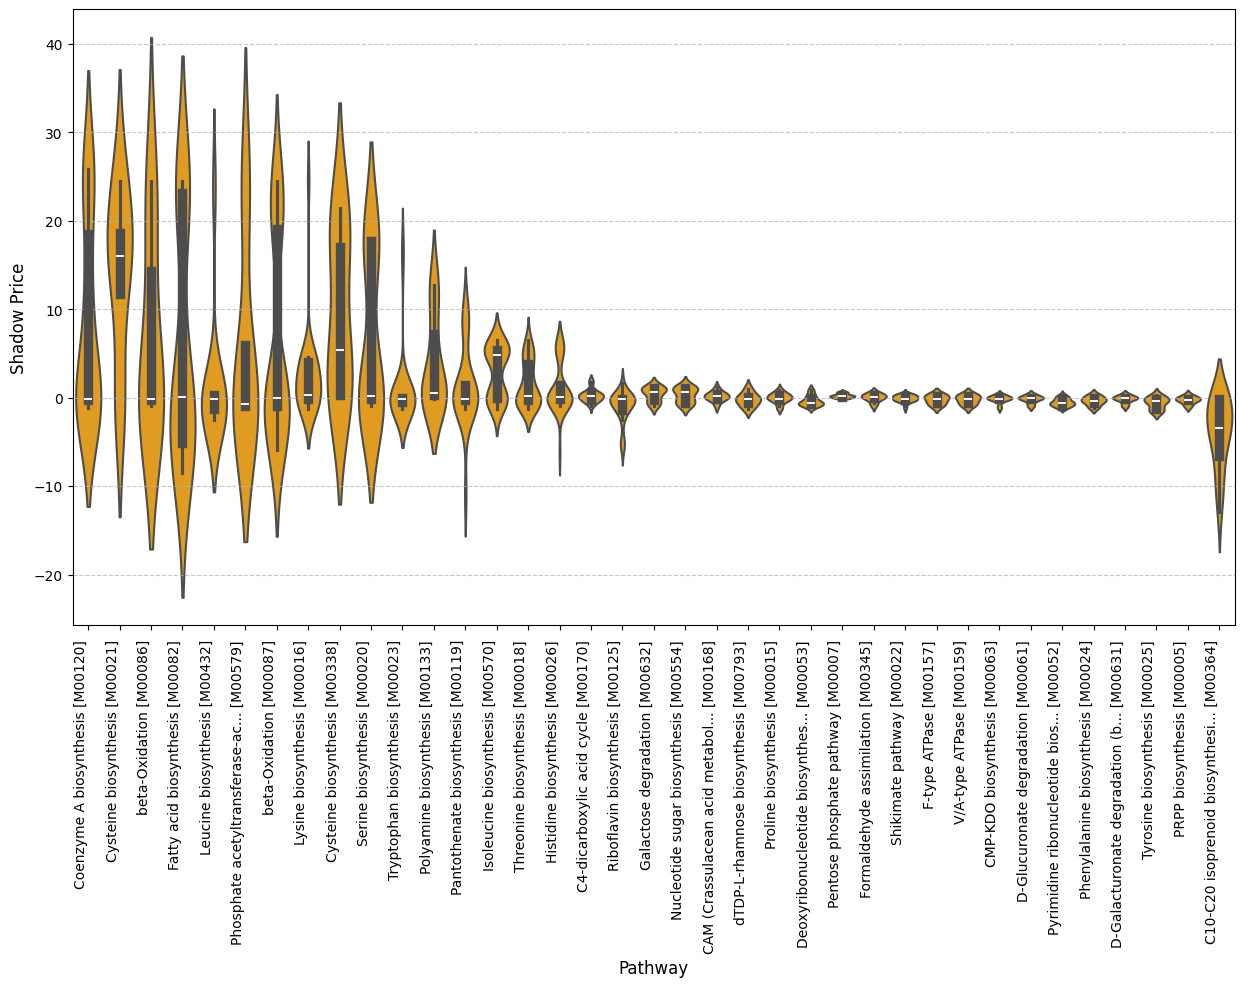

In [ ]:
#@markdown Violin plot showing shadow prices for metabolites in different pathway. (Can choose carbon source)

mutant = "rxn01101_c0" #@param ["rxn01485_c0-181a7", "rxn01101_c0"]{allow-input: false}
mutant_modeling_approach = "MOMA" #@param ["FBA", "MOMA_linear", "MOMA"] {allow-input: false}
database = "kegg" #@param ["kegg", "metacyc"] {allow-input: false}
strain = "Mutant" #@param ["Mutant", "Wild Type", "both"] {allow-input: false}
carbon_source = 'LB/LB_wo_glycine' #@param ['D-Glucose', 'D-Lactose', 'Maltose', 'Sucrose', 'D-Fructose', 'L-Glutamic-acid', 'Salicin', 'LB/LB', 'LB/LB_wo_serine', 'LB/LB_wo_glycine', 'LB/LB_wo_threonine', 'LB/LB_plus_serine', 'LB/LB_plus_glycine', 'LB/LB_plus_threonine']

create_figure = "yes" #@param ["yes", "no"] {allow-input: false}

approach_map = {"FBA": 1, "MOMA_linear": 2, "MOMA": 3}

############################################################
shadow_prices_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/shadow_prices/" + CBA_mutant + media_condition + ".json"

if database == "kegg": db_reaction_module_dict, db_module_reaction_dict, db_module_description, db_annotations, db_reactions_in_model = kegg_reaction_module_dict, kegg_module_reaction_dict, kegg_module_description, kegg_annotations, kegg_reactions_in_model
elif database == "metacyc": db_reaction_module_dict, db_module_reaction_dict, db_module_description, db_annotations, db_reactions_in_model = metacyc_reaction_module_dict, metacyc_module_reaction_dict, metacyc_module_description, metacyc_annotations, metacyc_reactions_in_model

module_exclude_list = ["M00365", "M00366", "M00367", "M00868", "M00580", "M00158", "M00160", "PWY-7851", "COA-PWY-1"]

module_shadowP_dict = defaultdict(list)

with open(shadow_prices_file, 'r') as f:
  plot_dict = json.load(f)

shadow_prices = plot_dict[carbon_source]
met_list = plot_dict["all_metabolites"]
met_rxn_dict = {item: [rxn.id for rxn in model_0.metabolites.get_by_id(item).reactions] for item in met_list}

for met_id in met_rxn_dict:
  if met_id in all_mets_produced:
    met_id_index = met_list.index(met_id)
    shadow_price_in_wt = shadow_prices[met_id_index][0]
    shadow_price_in_mu = shadow_prices[met_id_index][approach_map[mutant_modeling_approach]]

    for seed_rxn in met_rxn_dict[met_id]:
      if seed_rxn in db_annotations:
        for db_rxn in db_annotations[seed_rxn]:
          if db_rxn in db_reaction_module_dict:
            db_mods = db_reaction_module_dict[db_rxn]

            for db_mod in db_mods:
              #filter for only modules with reactions that are all present in organism
              fraction_of_module_present = len(db_module_reaction_dict[db_mod] & db_reactions_in_model)/len(db_module_reaction_dict[db_mod])
              if fraction_of_module_present >= 1 and db_mod not in module_exclude_list:
                module_shadowP_dict[db_mod].append([shadow_price_in_wt, shadow_price_in_mu])


##############################
# organize data for figure
data_array = []
for key, values in module_shadowP_dict.items():
    for value in values:
        data_array.append({"Pathway": key, "Strain": "Wild Type", "Shadow Price": value[0]})
        data_array.append({"Pathway": key, "Strain": "Mutant", "Shadow Price": value[1]})

shadow_price_df = pd.DataFrame(data_array)

# Sort the pathways based on the mean shadow price in the mutant
# a positive shadow price in the mutant indicates that a metabolite is limiting for the objective

sorted_pathways = (
    shadow_price_df[shadow_price_df["Strain"] == strain if strain!="both" else shadow_price_df["Strain"] == "Mutant" ]
    .groupby("Pathway")["Shadow Price"]
    .max()
    .sort_values(ascending=False)
    .index
)

# Limit to the first i categories
top_categories = sorted_pathways[:]
shadow_price_df = shadow_price_df[shadow_price_df["Pathway"].isin(top_categories)]
shadow_price_df["Pathway"] = pd.Categorical(shadow_price_df["Pathway"], categories=top_categories, ordered=True)

strain_df = shadow_price_df[(shadow_price_df["Strain"] == strain) & (shadow_price_df["Pathway"].isin(top_categories))]
strain_df.loc[:, "Pathway"] = pd.Categorical(strain_df["Pathway"], categories=top_categories, ordered=True)


# Step 4: Create the violin plot
plt.figure(figsize=(15, 8))

if strain ==  "Mutant" or strain ==  "Wild Type":
  ax = sns.violinplot(data=strain_df, x="Pathway", y="Shadow Price", color="orange",
                      linewidth=1.5, density_norm="width")
  plt.xlabel("Pathway", fontsize=12)
  plt.ylabel("Shadow Price", fontsize=12)

if strain == "both":
  ax = sns.violinplot(data=shadow_price_df, x="Pathway", y="Shadow Price", hue="Strain", split=False)
  plt.xlabel("Pathway", fontsize=12)
  plt.ylabel("Shadow Price", fontsize=12)
  plt.legend(title="Strain")

#plt.legend(title="Strain")


tick_labels = [abbreviate_pathways(db_module_description[pathway].split(",")[0]) + " ["+pathway+"] " for pathway in top_categories]

ax.set_xticks(range(len(top_categories)))
ax.set_xticklabels(tick_labels, rotation=90, ha="right")

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()





#### Gapfilling reactions

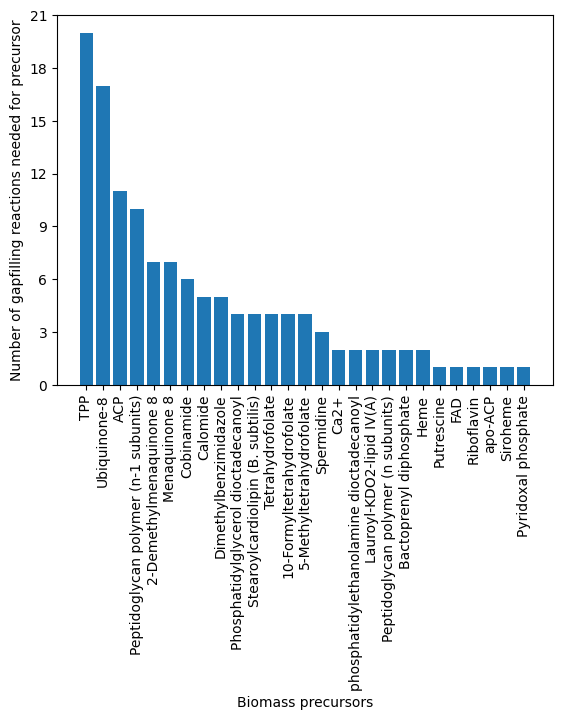

In [ ]:
#@markdown Metabolites that required gapfilling reactions but are not in mRNA, protein and DNA (candidates for removal from biomass function)
create_figure = "yes" #@param ["yes", "no"] {allow-input: false}

if create_figure == "yes" and "ecoli" not in model_name:
  gapfilling_file = working_directory + f"/simulations{media_supplement}/" + model_name + curation + "/other/gapfilling_reactions.tsv"
  gapfilling_report = pd.read_csv(gapfilling_file, sep="\t")
  essential_precursors = mRNA_precursors | prot_precursors | DNA_precursors

  gap_filling_sensitivity = [item.split("; ") for item in list(gapfilling_report["gapfilling_sensitivity_id"])]

  count_biomass_mets = defaultdict(int)
  for sublist in gap_filling_sensitivity:
    if len(set(sublist) & essential_precursors) > 0:
      continue
    for item in sublist:
      count_biomass_mets[item] += 1


  count_biomass_mets = dict(count_biomass_mets)

  # Sort the dictionary
  count_biomass_mets = dict(sorted(count_biomass_mets.items(), key=lambda item: item[1], reverse=True))
  biomass_met_names = [model_0.metabolites.get_by_id(id).name.strip(" [c0]") for id in count_biomass_mets.keys()]

  # Plotting the bar plot
  plt.bar(biomass_met_names, count_biomass_mets.values())
  plt.xlabel('Biomass precursors')
  plt.xticks(rotation=90)
  plt.ylabel('Number of gapfilling reactions needed for precursor')
  plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

  # figure_name = "figures/gapfilling_analysis/" + KO_mutant
  # plt.savefig(figure_name, dpi=1000, bbox_inches="tight")

  plt.show()

## Explore

In [ ]:
maps_folder = "/content/drive/MyDrive/work/data/virocells/my_analysis/version_1/CBA_mutants/escher maps/ModelSEED"

os.chdir(maps_folder)

In [ ]:
file_stats = defaultdict(list)

for filename in os.listdir(maps_folder):
  with open(filename, 'r') as f:
    pathway_map = json.load(f)
    rxns_in_pathway = [rxn["name"] for rxn in list(pathway_map[1]['reactions'].values())]
    mes_in_pathway = [i["bigg_id"]+"_c0" for i in pathway_map[1]["nodes"].values() if i["node_type"]=="metabolite"]
    #cpd_list = [cpd['bigg_id'] for cpd in list(pathway_map[1]['nodes'].values()) if cpd['node_type']=='metabolite']

    #model_rxns = set([item.id.strip("_c0") for item in model_0.reactions])
    rxns_altered_in_mutant = set([item.strip("_c0") for item in filtered_rxns])
    subset_altered_in_mutant = set(rxns_in_pathway) & rxns_altered_in_mutant
    fraction_altered_in_mutant = len(subset_altered_in_mutant)/len(rxns_in_pathway)

    file_stats['filename'].append(filename)
    file_stats['rxns_in_pathway'].append(len(rxns_in_pathway))
    #file_stats['cpd_count'].append(len(cpd_list))
    file_stats['subset_altered_in_mutant'].append(len(subset_altered_in_mutant))
    file_stats['fraction_altered_in_mutant'].append(fraction_altered_in_mutant)

df = pd.DataFrame(file_stats)
df.sort_values(by='fraction_altered_in_mutant', ascending=False)

,filename,rxns_in_pathway,subset_altered_in_mutant,fraction_altered_in_mutant
43,ModelSEED.De Novo Purine Biosynthesis.json,13,11,0.846154
12,ModelSEED.KDO2-Lipid A Biosynthesis.json,13,11,0.846154
2,ModelSEED.TCA Cycle.json,17,14,0.823529
60,ModelSEED.Tryptophan Biosynthesis.json,9,7,0.777778
32,ModelSEED.Chorismate Synthesis.json,8,6,0.750000
...,...,...,...,...
67,ModelSEED.Biotin Biosynthesis A.json,13,0,0.000000
58,ModelSEED.Ribitol et al Utilization.json,8,0,0.000000
16,ModelSEED.Methylcitrate Cycle FBA Checked.json,9,0,0.000000
59,ModelSEED.Methylcitrate Cycle.json,7,0,0.000000


In [ ]:
# fba_solution_wt = cobra.flux_analysis.pfba(wild_type_model)
# moma_soln = cobra.flux_analysis.moma(model=mutant_model, solution=cobra.flux_analysis.pfba(wild_type_model), linear=False)
# model_0.reactions.get_by_id("rxn00371_c0")
# fba_solution_wt["rxn00371_c0"]
# moma_soln["rxn00371_c0"]

In [ ]:
# for E. coli model
CBA_mutant = "rxn00274_c0"
#CBA_mutant = "rxn01101_c0"

#medium_file = "growth_media/LB-Marine-Threonine.tsv"
#medium_file = f"growth_media/defined{media_supplement}/D-Glucose.tsv"
#medium_file = f"growth_media/defined{media_supplement}/Glucose&Glycine.tsv"

#model_x =  set_nutritional_environment(model_0, medium_file, condition=media_condition)
model_x = no_carbon_intake(model_0)

mutant_model_x = deepcopy(model_x)
wild_type_model_x = deepcopy(model_x)

mutant_model_x.reactions.get_by_id(rast_to_bigg[CBA_mutant]).lower_bound = 0
mutant_model_x.reactions.get_by_id(rast_to_bigg[CBA_mutant]).upper_bound = 0

Read LP format model from file /tmp/tmpmnx6iedl.lp
Reading time = 0.03 seconds
: 1877 rows, 5424 columns, 21150 nonzeros
Read LP format model from file /tmp/tmptng2b6l5.lp
Reading time = 0.02 seconds
: 1877 rows, 5424 columns, 21150 nonzeros
Read LP format model from file /tmp/tmp_2_rvg9d.lp
Reading time = 0.03 seconds
: 1877 rows, 5424 columns, 21150 nonzeros


In [ ]:
# fba_soln_x = cobra.flux_analysis.pfba(wild_type_model_x)
# moma_soln_x = cobra.flux_analysis.moma(model=mutant_model_x, solution=cobra.flux_analysis.pfba(wild_type_model_x), linear=False)

which amino acids activate the GLYAT reaction? Threonine (thr__L_e) and Agmantine (agm_e), and L-Threonine O-3-phosphate (thrp_e)

In [ ]:
mets_at_boundary = [list(i.metabolites)[0] for i in model_x.boundary]
boundary_mets_w_carbon = [i.id for i in mets_at_boundary if "C" in i.elements and "_e" in i.id]

In [ ]:
for i in boundary_mets_w_carbon:
  with wild_type_model_x as my_model:
    my_model.reactions.get_by_id("EX_"+i).lower_bound = -10
    my_soln = cobra.flux_analysis.pfba(my_model)
    if abs(my_soln["GLYAT"])>0: print(i, my_soln["GLYAT"])

agm_e -0.756201558519098
thr__L_e -9.698925627220772
thrp_e -9.698925627220772


does adding a different amino acid allow us to revert the phenotype? yep

In [ ]:
threonine_model = deepcopy(wild_type_model_x)
threonine_model.reactions.get_by_id("EX_thr__L_e").lower_bound = -10

Read LP format model from file /tmp/tmpja9dzgqu.lp
Reading time = 0.03 seconds
: 1877 rows, 5424 columns, 21150 nonzeros


In [ ]:
for i in boundary_mets_w_carbon:
  with threonine_model as my_model:
    my_model.reactions.get_by_id("EX_"+i).lower_bound = -10
    my_soln = cobra.flux_analysis.pfba(my_model)
    if abs(my_soln["GLYAT"]) == 0: print(my_model.metabolites.get_by_id(i).name, my_soln["GLYAT"])

Hypoxanthine 0.0
L-Glutamine 0.0
L-Aspartate 0.0
Pyruvate 0.0
Succinate 0.0
D-Xylose 0.0
Formate 0.0
Trehalose 0.0
Hexadecenoate (n-C16:1) 0.0
Dihydroxyacetone 0.0
2-Dehydro-3-deoxy-D-gluconate 0.0
Indole 0.0
Glycerol 3-phosphate 0.0
Maltose C12H22O11 0.0
Uridine 0.0
2(alpha-D-Mannosyl)-D-glycerate 0.0
DTMP C10H13N2O8P 0.0
L-alanine-L-glutamate 0.0
3-Hydroxypropanoate 0.0


Which of these is present in CBA18? aspartate, pyruvate, succinate, formate, maltose, uridine

In [ ]:
# for CBA18 model

mets_at_boundary = [list(i.metabolites)[0] for i in model_0.boundary]
boundary_mets_w_carbon = [i.name for i in mets_at_boundary if "C" in i.elements and "_e0" in i.id]

escher maps stuff

,filename,rxns_in_pathway,subset_altered_in_mutant,fraction_altered_in_mutant
12,ModelSEED.KDO2-Lipid A Biosynthesis.json,13,11,0.846154
60,ModelSEED.Tryptophan Biosynthesis.json,9,7,0.777778
43,ModelSEED.De Novo Purine Biosynthesis.json,13,10,0.769231
64,ModelSEED.Glycine Cleavage System.json,4,3,0.750000
39,ModelSEED.Purine Conversions.json,4,3,0.750000
...,...,...,...,...
52,ModelSEED.L-Rhamnose Utilization.json,7,0,0.000000
54,"ModelSEED.D-Galactarate, D-Glucarate, and D-Gl...",8,0,0.000000
24,ModelSEED.Alginate Biosynthesis.json,10,0,0.000000
58,ModelSEED.Ribitol et al Utilization.json,8,0,0.000000
